## Data Analysis Setup

This section establishes the analytical environment for comprehensive validation of the BART topic classification model.  
The plotting configuration ensures consistent, publication-quality visualizations throughout the analysis.

In [49]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
import emoji
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
    

warnings.filterwarnings('ignore')

# Set plotting style for academic publications
plt.style.use('default')
plt.rcParams.update({
    'font.size': 13,
    'axes.titlesize': 22,
    'axes.labelsize': 17,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'figure.titlesize': 22,
    'legend.fontsize': 14,
    'figure.figsize': [12, 8]
})

## Visualization Color Schemes

Establishes consistent color mappings for topic classifications and media types to ensure visual coherence across all analytical outputs.  

In [31]:
# Consistent color mapping for topic classifications
TOPIC_COLORS = {
    'economics': '#1f77b4',
    'politics': '#d62728',
    'health': '#ff7f0e',
    'science': '#2ca02c',
    'sports': '#9467bd',
    'lifestyle': '#8c564b',
    'unknown': '#7f7f7f'
}

# Media type color scheme using Set2 palette
SET2_COLORS = sns.color_palette("Set2", 8).as_hex()
MEDIA_TYPE_COLORS = {
    'photo': SET2_COLORS[0],
    'video': SET2_COLORS[1],
    'text_only': SET2_COLORS[2],
    'other_link': SET2_COLORS[3],
    'animated_gif': SET2_COLORS[4],
    'other': SET2_COLORS[7]
}

def get_color_palette(categories, color_dict, palette_name='husl'):
    """Generate consistent color palette for categorical data visualization."""
    colors = []
    for cat in categories:
        if cat.lower() in color_dict:
            colors.append(color_dict[cat.lower()])
        else:
            remaining_colors = sns.color_palette(palette_name, len(categories))
            colors.append(remaining_colors[len(colors)])
    return colors

## Analysis Utilities

Helper functions for data processing and output management, including column name standardization and automated figure saving.

In [48]:
def format_column_name(col_name):
    """Convert variable names to readable labels for academic presentation."""
    name_mappings = {
        'misleadingFactualError': 'Misleading Factual Error',
        'misleadingManipulatedMedia': 'Misleading Manipulated Media',
        'misleadingOutdatedInformation': 'Misleading Outdated Information',
        'misleadingMissingImportantContext': 'Misleading Missing Important Context',
        'misleadingUnverifiedClaimAsFact': 'Misleading Unverified Claim As Fact',
        'misleadingSatire': 'Misleading Satire',
        'predicted_classification': 'Predicted Topic',
        'prediction_confidence': 'Prediction Confidence',
        'has_fact_check_link': 'Has Fact Check Link',
        'animated_gif': 'Animated GIF',
        'text_only': 'Text Only',
        'other_link': 'Other Link'
    }
    
    if col_name in name_mappings:
        return name_mappings[col_name]
    
    # Convert camelCase and snake_case to title format
    result = re.sub(r'([a-z])([A-Z])', r'\1 \2', col_name)
    result = result.replace('_', ' ').title()
    return result

# Initialize graph saving system
GRAPHS_DIR = "graphs"
ANALYSIS_DIR = "analysis_results"  # New directory for text files/calculations

os.makedirs(GRAPHS_DIR, exist_ok=True)
os.makedirs(ANALYSIS_DIR, exist_ok=True)  # Create analysis directory

graph_counter = 0

def save_current_plot(filename_prefix, description=""):
    """Save current plot with standardized naming for thesis documentation."""
    global graph_counter
    graph_counter += 1
    
    safe_description = "".join(c for c in description if c.isalnum() or c in (' ', '-', '_')).rstrip()
    safe_description = safe_description.replace(' ', '_').lower()
    
    filename = f"{graph_counter:02d}_{safe_description}.png" if safe_description else f"{graph_counter:02d}_{filename_prefix}.png"
    filepath = os.path.join(GRAPHS_DIR, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')

## Dataset Loading and Preprocessing

Loads the labeled BSC dataset and performs initial data cleaning including duplicate removal based on content similarity.  

In [ ]:
# Load the labeled dataset
DATASET_PATH = "bsc_dataset_labeled_20250529_141840.csv"
df = pd.read_csv(DATASET_PATH)

print(f"Initial dataset size: {len(df):,} samples")

# Remove duplicate content to ensure analysis accuracy
content_columns = []
if 'full_text' in df.columns and 'note_text' in df.columns:
    content_columns = ['full_text', 'note_text']
elif 'full_text' in df.columns:
    content_columns = ['full_text']
elif 'note_text' in df.columns:
    content_columns = ['note_text']

if content_columns:
    initial_count = len(df)
    df = df.drop_duplicates(subset=content_columns, keep='first')
    duplicates_removed = initial_count - len(df)
    print(f"Removed {duplicates_removed:,} duplicate entries")
else:
    df = df.drop_duplicates(keep='first')

print(f"Final dataset size: {len(df):,} samples")
print(f"Available columns: {list(df.columns)}")

Dataset loaded: 23,928 samples after deduplication


## Media Type Distribution Analysis

Analyzes the distribution of media types in the labeled dataset, with enhanced classification that distinguishes between external links and pure text content.

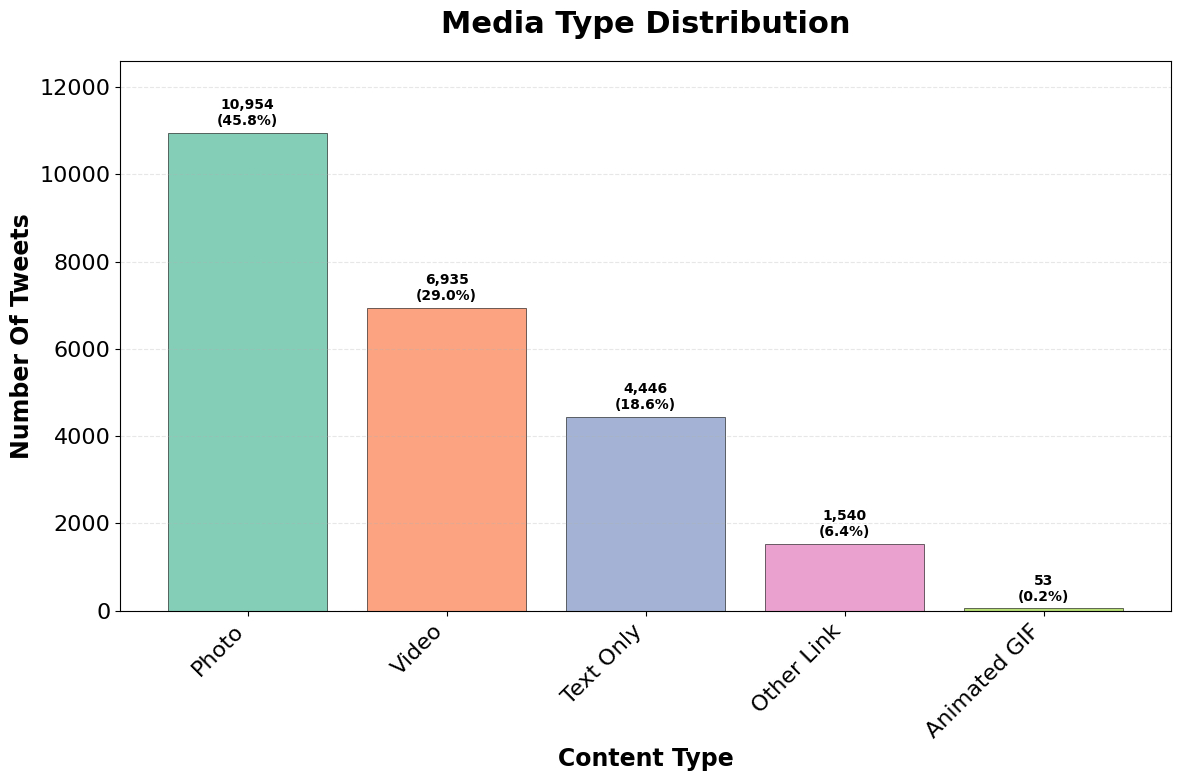

In [ ]:
# Enhanced media type classification
def classify_media_type(row):
    """Classify content type with enhanced external link detection."""
    media_type = row['media_type']
    full_text = str(row['full_text']) if pd.notna(row['full_text']) else ""
    
    if pd.notna(media_type):
        return media_type
    else:
        # Detect external links in text-only content
        if 'https://t.co/' in full_text[-20:]:
            return 'external link'
        elif any(url_pattern in full_text.lower() for url_pattern in ['http://', 'https://', 'www.']):
            return 'other link'
        else:
            return 'text only'

# Apply enhanced media type classification
if 'media_type' in df.columns and 'full_text' in df.columns:
    df['media_type'] = df.apply(classify_media_type, axis=1)
    
    print("\nMedia Type Distribution:")
    media_counts = df['media_type'].value_counts()
    for media_type, count in media_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {format_column_name(media_type)}: {count:,} ({percentage:.1f}%)")

# Generate media type distribution visualization
if 'media_type' in df.columns:
    media_counts = df['media_type'].value_counts()
    media_percentages = media_counts / len(df) * 100
    
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("Set2", len(media_counts))
    bars = plt.bar(range(len(media_counts)), media_counts.values, 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.title('Media Type Distribution', fontweight='bold', pad=20)
    plt.xlabel('Content Type', fontweight='bold')
    plt.ylabel('Number Of Tweets', fontweight='bold')
    
    # Format labels for academic presentation
    formatted_labels = [format_column_name(label) for label in media_counts.index]
    plt.xticks(range(len(media_counts)), formatted_labels, rotation=45, ha='right')
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, media_counts.values)):
        percentage = media_percentages.iloc[i]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(media_counts) * 0.01,
                f'{count:,}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.ylim(0, max(media_counts) * 1.15)
    plt.tight_layout()
    
    save_current_plot('block1', 'media_type_distribution')
    plt.show()

## Topic Classification Distribution Analysis

Analysis of BART model predictions across the six topic categories.  
The dual visualization approach (bar chart and pie chart) provides both absolute counts and relative proportions.

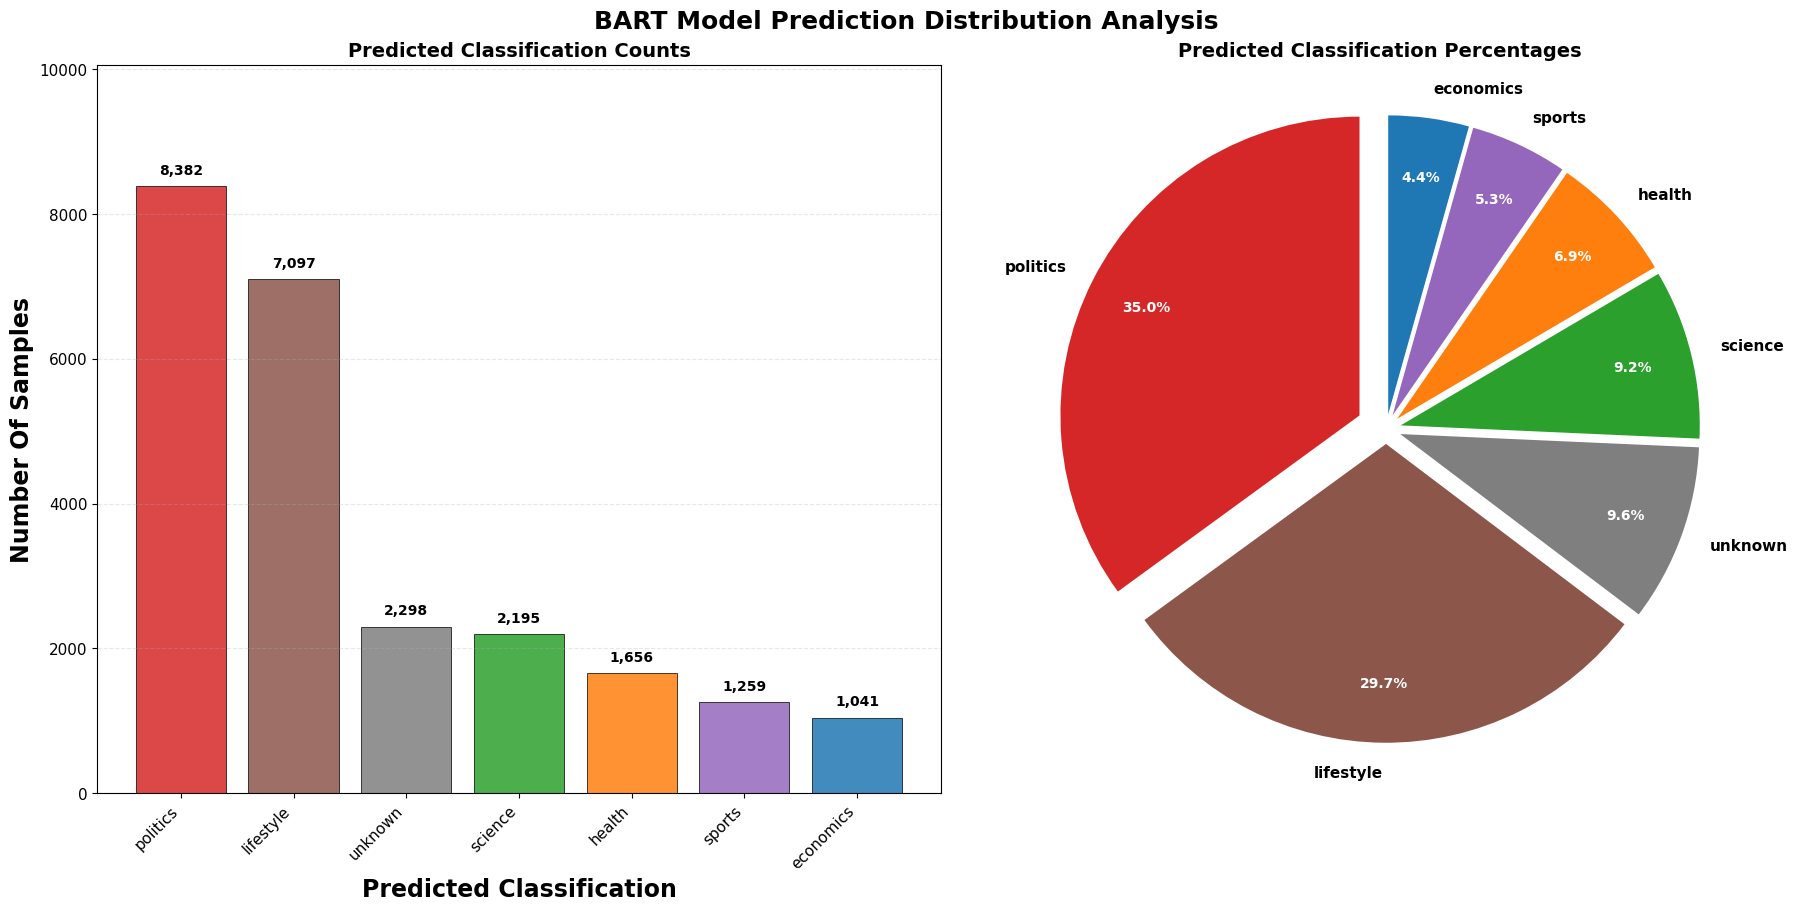

In [ ]:
# BART model prediction distribution analysis
if 'predicted_classification' in df.columns:
    prediction_counts = df['predicted_classification'].value_counts()
    
    print("\nTopic Classification Distribution:")
    for topic, count in prediction_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {topic.title()}: {count:,} ({percentage:.1f}%)")
    prediction_percentages = df['predicted_classification'].value_counts(normalize=True) * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), constrained_layout=True)
    fig.suptitle('BART Model Prediction Distribution Analysis', fontsize=18, fontweight='bold')

    # Get consistent topic colors
    colors = get_color_palette(prediction_counts.index, TOPIC_COLORS)

    # Bar chart for absolute counts
    bars = ax1.bar(prediction_counts.index, prediction_counts.values,
                   color=colors, alpha=0.85, edgecolor='black', linewidth=0.6)
    
    ax1.set_title('Predicted Classification Counts', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Number Of Samples', fontweight='bold')
    ax1.set_xlabel('Predicted Classification', fontweight='bold')
    ax1.set_xticklabels(prediction_counts.index, rotation=45, ha='right', fontsize=11)
    ax1.tick_params(axis='y', labelsize=11)

    # Add count labels
    for i, (cat, count) in enumerate(prediction_counts.items()):
        ax1.text(i, count + max(prediction_counts) * 0.015, f'{count:,}',
                 ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_ylim(0, max(prediction_counts) * 1.2)

    # Pie chart for proportional analysis
    explode = [0.1 if i == 0 else 0.05 for i in range(len(prediction_counts))]
    wedges, texts, autotexts = ax2.pie(
        prediction_counts.values,
        labels=prediction_counts.index,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        explode=explode,
        pctdistance=0.8,
        textprops={'fontsize': 11, 'fontweight': 'bold'}
    )

    ax2.set_title('Predicted Classification Percentages', fontweight='bold', fontsize=14)
    ax2.axis('equal')

    # Style percentage labels
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(10)

    save_current_plot('bart_analysis', 'prediction_distribution_analysis')
    plt.show()

## Media Type Distribution Across Topic Categories

Analyzes how different media types are distributed across the six topic classifications.

<Figure size 1400x800 with 0 Axes>

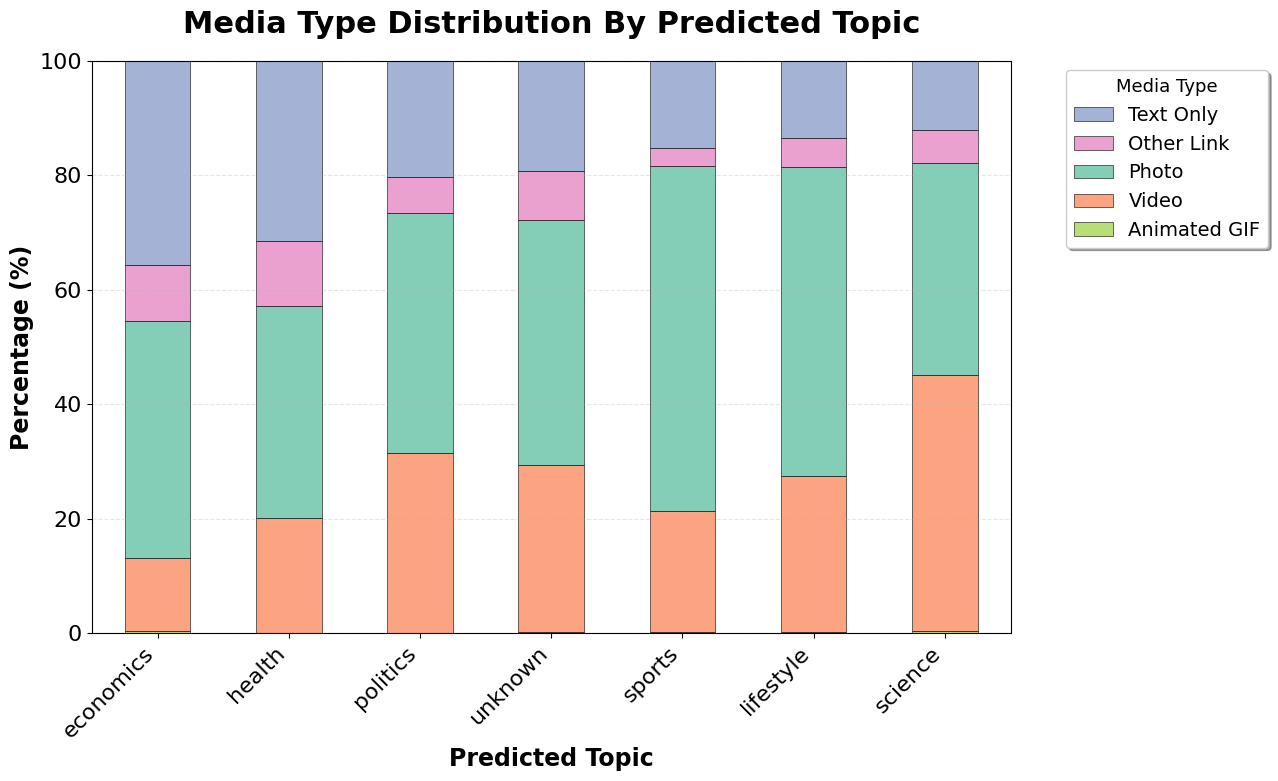

In [ ]:
# Media type distribution by predicted topic analysis
if 'media_type' in df.columns and 'predicted_classification' in df.columns:
    
    print(f"\nAnalyzing media type distribution across {df['predicted_classification'].nunique()} topics")
    print(f"Media types found: {sorted(df['media_type'].unique())}")
    
    # Create percentage-based crosstab (normalized by topic)
    media_topic_percentages = pd.crosstab(
        df['predicted_classification'], 
        df['media_type'], 
        normalize='index'
    ) * 100
    
    # Sort topics by text-only content percentage for logical ordering
    if 'text only' in media_topic_percentages.columns:
        sorted_topics = media_topic_percentages.sort_values('text only', ascending=False)
    else:
        sorted_topics = media_topic_percentages
    
    # Format column names for academic presentation
    formatted_columns = [format_column_name(col) for col in sorted_topics.columns]
    sorted_topics.columns = formatted_columns
    
    # Reorder columns for optimal visual stacking (multimedia types first)
    desired_order = ['Animated GIF', 'Video', 'Photo', 'Other Link', 'Text Only']
    ordered_columns = []
    
    for desired_col in desired_order:
        if desired_col in sorted_topics.columns:
            ordered_columns.append(desired_col)
    
    # Add any remaining columns not in predefined order
    remaining_columns = [col for col in sorted_topics.columns if col not in ordered_columns]
    ordered_columns.extend(remaining_columns)
    
    sorted_topics = sorted_topics[ordered_columns]
    
    # Generate consistent color palette for media types
    colors = get_color_palette([col.lower().replace(' ', '_') for col in sorted_topics.columns], MEDIA_TYPE_COLORS)
    
    # Create stacked percentage bar chart
    plt.figure(figsize=(14, 8))
    ax = sorted_topics.plot(kind='bar', stacked=True, 
                           color=colors, alpha=0.8, 
                           edgecolor='black', linewidth=0.5)
    
    plt.title('Media Type Distribution By Predicted Topic', fontweight='bold', pad=20)
    plt.xlabel('Predicted Topic', fontweight='bold')
    plt.ylabel('Percentage (%)', fontweight='bold')
    
    # Configure legend for academic presentation
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(list(reversed(handles)), list(reversed(labels)), 
               title='Media Type', bbox_to_anchor=(1.05, 1), loc='upper left',
               frameon=True, fancybox=True, shadow=True)
    
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    
    save_current_plot('block2', 'media_type_by_topic_percentage')
    plt.show()

## Sentiment Analysis Across Topic Categories

Performs VADER sentiment analysis on tweet content across the six topic classifications.

In [ ]:
# Sentiment analysis by predicted topic
if 'predicted_classification' in df.columns and 'full_text' in df.columns:
    
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()
    
    # Prepare data for sentiment analysis
    df_sentiment = df[df['full_text'].notna() & (df['predicted_classification'] != 'unknown')].copy()
    df_sentiment['full_text'] = df_sentiment['full_text'].astype(str).fillna('')
    
    print(f"Analyzing sentiment for {len(df_sentiment):,} tweets across {df_sentiment['predicted_classification'].nunique()} topics")
    
    # Calculate VADER sentiment scores
    df_sentiment['sentiment_score'] = df_sentiment['full_text'].apply(
        lambda x: sid.polarity_scores(x)['compound']
    )
    
    # Calculate mean sentiment by topic
    mean_sentiment_by_topic = df_sentiment.groupby('predicted_classification')['sentiment_score'].mean().sort_values()
    
    print("\nAverage Sentiment by Topic:")
    for topic, sentiment in mean_sentiment_by_topic.items():
        sample_count = len(df_sentiment[df_sentiment['predicted_classification'] == topic])
        print(f"  {format_column_name(topic)}: {sentiment:.3f} (n={sample_count:,})")
    
    # Create sentiment visualization
    plt.figure(figsize=(12, 8))
    colors = get_color_palette(mean_sentiment_by_topic.index, TOPIC_COLORS)
    bars = plt.bar(range(len(mean_sentiment_by_topic)), mean_sentiment_by_topic.values, 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.title('Average Sentiment (VADER) by Predicted Topic', fontweight='bold', pad=20)
    plt.ylabel('Average Compound Sentiment\n(-1 Negative, +1 Positive)', fontweight='bold')
    plt.xlabel('Predicted Topic', fontweight='bold')
    
    # Format labels for academic presentation
    formatted_labels = [format_column_name(label) for label in mean_sentiment_by_topic.index]
    plt.xticks(range(len(mean_sentiment_by_topic)), formatted_labels, rotation=45, ha='right')
    
    # Add neutral reference line
    plt.axhline(0, color='grey', linewidth=2, linestyle='--', alpha=0.7, label='Neutral (0.0)')
    
    # Add value labels on bars
    for i, (topic, value) in enumerate(mean_sentiment_by_topic.items()):
        plt.text(i, value + (max(mean_sentiment_by_topic) * 0.02 if value >= 0 else min(mean_sentiment_by_topic) * 0.02), 
                f'{value:.3f}', 
                ha='center', va='bottom' if value >= 0 else 'top', 
                fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    y_range = max(mean_sentiment_by_topic) - min(mean_sentiment_by_topic)
    plt.ylim(min(mean_sentiment_by_topic) - y_range * 0.1, max(mean_sentiment_by_topic) + y_range * 0.1)
    
    plt.legend(loc='upper left')
    plt.tight_layout()
    save_current_plot('block3', 'sentiment_analysis_by_topic')
    plt.show()
    
    # Export representative examples for thesis documentation
    N_EXAMPLES = 5
    export_filename = f"{ANALYSIS_DIR}/sentiment_examples_complete.txt"
    
    print(f"\nExporting top {N_EXAMPLES} sentiment examples per topic to: {export_filename}")
    
    with open(export_filename, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("SENTIMENT ANALYSIS EXAMPLES BY TOPIC\n")
        f.write(f"Generated from {len(df_sentiment):,} tweets\n")
        f.write(f"Top {N_EXAMPLES} most extreme examples per topic\n")
        f.write("="*80 + "\n\n")
        
        for topic in mean_sentiment_by_topic.index:
            topic_data = df_sentiment[df_sentiment['predicted_classification'] == topic]
            
            if len(topic_data) >= 4:
                f.write(f"TOPIC: {format_column_name(topic).upper()}\n")
                f.write(f"Average Sentiment: {mean_sentiment_by_topic[topic]:.3f}\n")
                f.write(f"Total Tweets: {len(topic_data):,}\n")
                f.write("-" * 70 + "\n\n")
                
                # Get extreme examples
                n_to_show = min(N_EXAMPLES, len(topic_data) // 2)
                most_positive = topic_data.nlargest(n_to_show, 'sentiment_score')
                most_negative = topic_data.nsmallest(n_to_show, 'sentiment_score')
                
                f.write(f"TOP {n_to_show} MOST POSITIVE EXAMPLES:\n")
                f.write("-" * 40 + "\n")
                for idx, (_, tweet_row) in enumerate(most_positive.iterrows(), 1):
                    tweet_text = tweet_row['full_text']
                    score = tweet_row['sentiment_score']
                    f.write(f"{idx:2d}. Score: {score:+.3f}\n")
                    f.write(f"    Text: \"{tweet_text}\"\n\n")
                
                f.write(f"TOP {n_to_show} MOST NEGATIVE EXAMPLES:\n")
                f.write("-" * 40 + "\n")
                for idx, (_, tweet_row) in enumerate(most_negative.iterrows(), 1):
                    tweet_text = tweet_row['full_text']
                    score = tweet_row['sentiment_score']
                    f.write(f"{idx:2d}. Score: {score:+.3f}\n")
                    f.write(f"    Text: \"{tweet_text}\"\n\n")
                
                f.write("\n" + "="*70 + "\n\n")
    
    print("Sentiment analysis examples exported successfully")

LookupError: 
**********************************************************************
  Resource [93mvader_lexicon[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('vader_lexicon')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93msentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt[0m

  Searched in:
    - '/Users/esben/nltk_data'
    - '/Users/esben/opt/anaconda3/envs/ex1/nltk_data'
    - '/Users/esben/opt/anaconda3/envs/ex1/share/nltk_data'
    - '/Users/esben/opt/anaconda3/envs/ex1/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


## Linguistic Feature Analysis by Topic

Examines textual characteristics across topic classifications including text length, capitalization patterns, exclamation marks, emojis, and ALL CAPS word usage.

Analyzing linguistic features for 21,630 tweets across 6 topics

Linguistic Features Summary by Topic:

Lifestyle (n=7,097):
  Avg Text Length: 133.9 chars
  Avg Exclamations: 0.20
  Tweets with Emojis: 30.2%
  Tweets with ALL CAPS: 23.0%

Sports (n=1,259):
  Avg Text Length: 138.6 chars
  Avg Exclamations: 0.17
  Tweets with Emojis: 47.7%
  Tweets with ALL CAPS: 29.8%

Science (n=2,195):
  Avg Text Length: 189.7 chars
  Avg Exclamations: 0.21
  Tweets with Emojis: 26.0%
  Tweets with ALL CAPS: 24.2%

Health (n=1,656):
  Avg Text Length: 219.3 chars
  Avg Exclamations: 0.16
  Tweets with Emojis: 14.6%
  Tweets with ALL CAPS: 31.2%

Politics (n=8,382):
  Avg Text Length: 212.6 chars
  Avg Exclamations: 0.21
  Tweets with Emojis: 24.8%
  Tweets with ALL CAPS: 30.9%

Economics (n=1,041):
  Avg Text Length: 228.3 chars
  Avg Exclamations: 0.18
  Tweets with Emojis: 21.0%
  Tweets with ALL CAPS: 33.8%


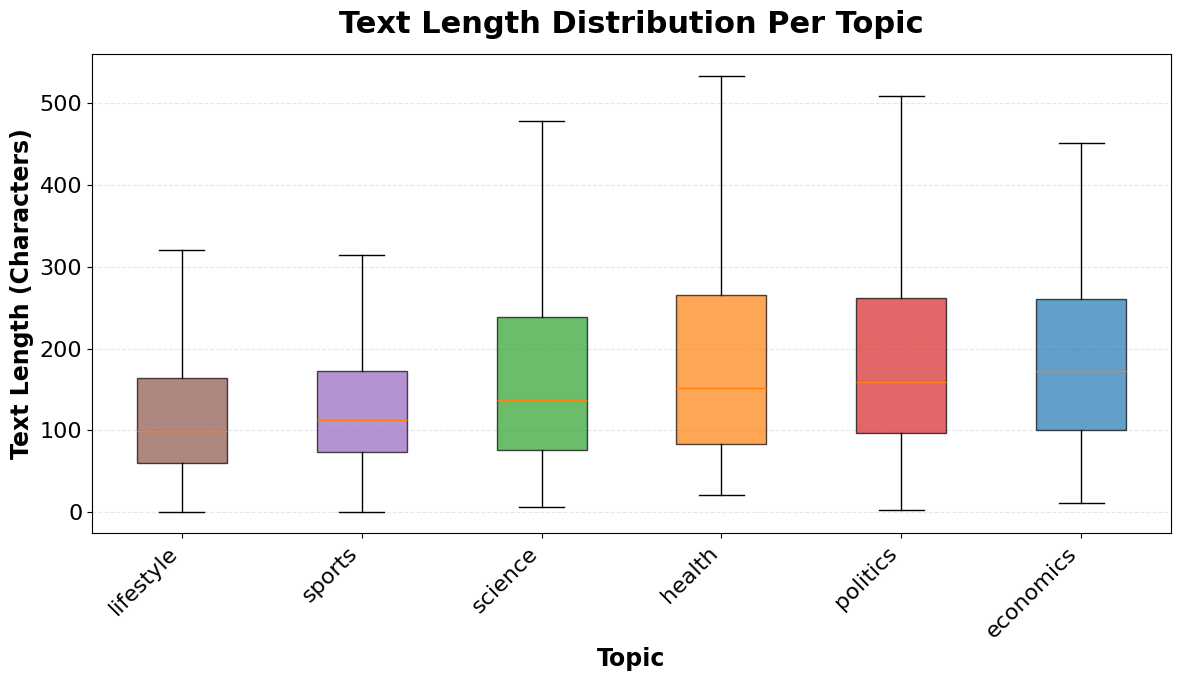

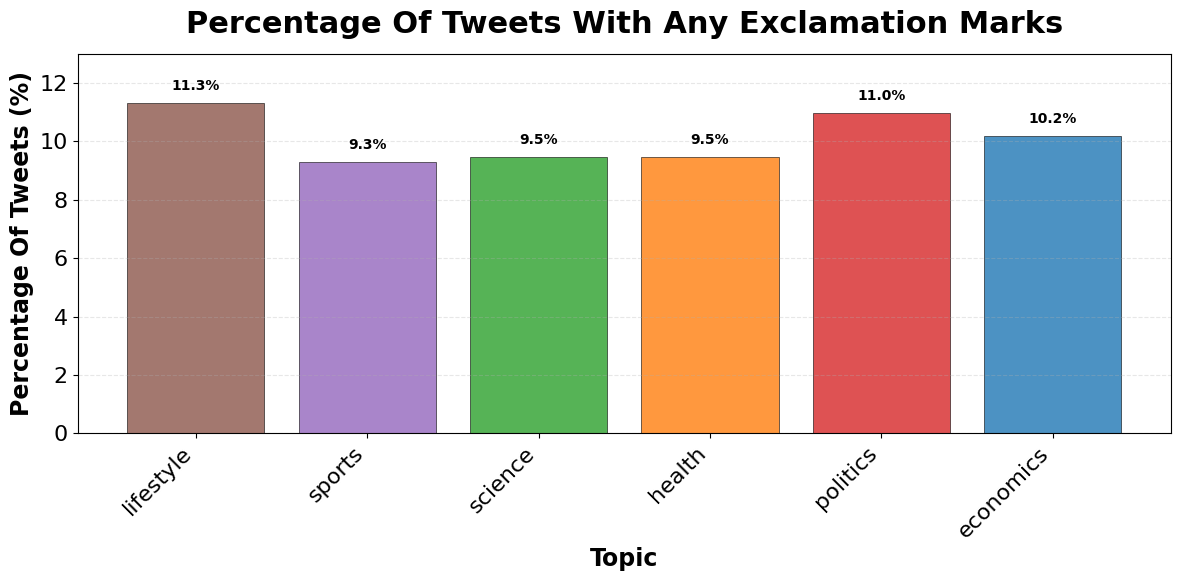

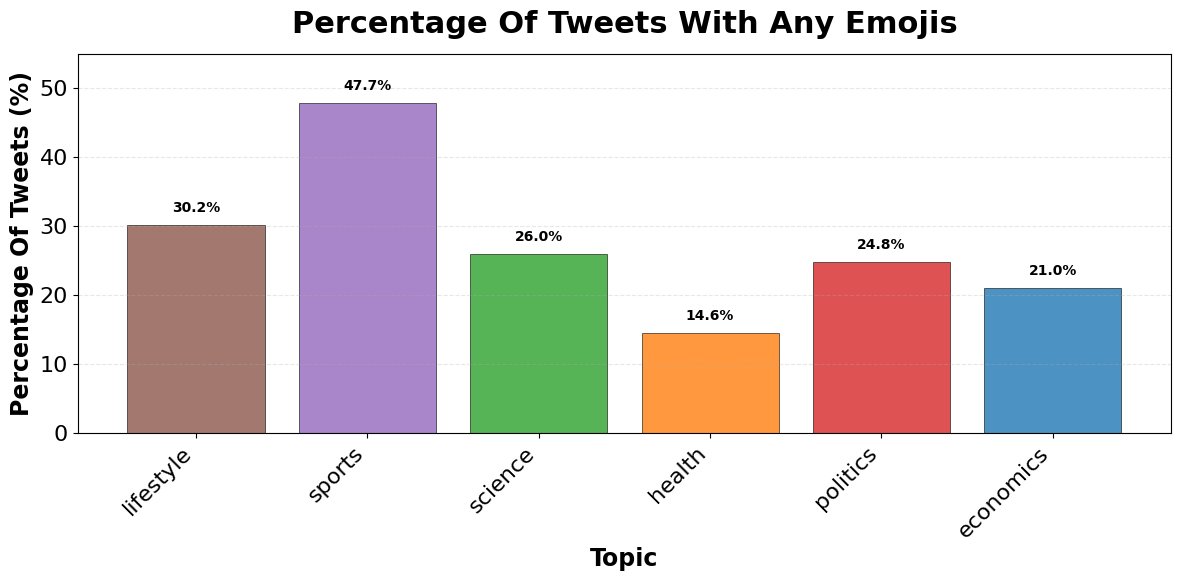

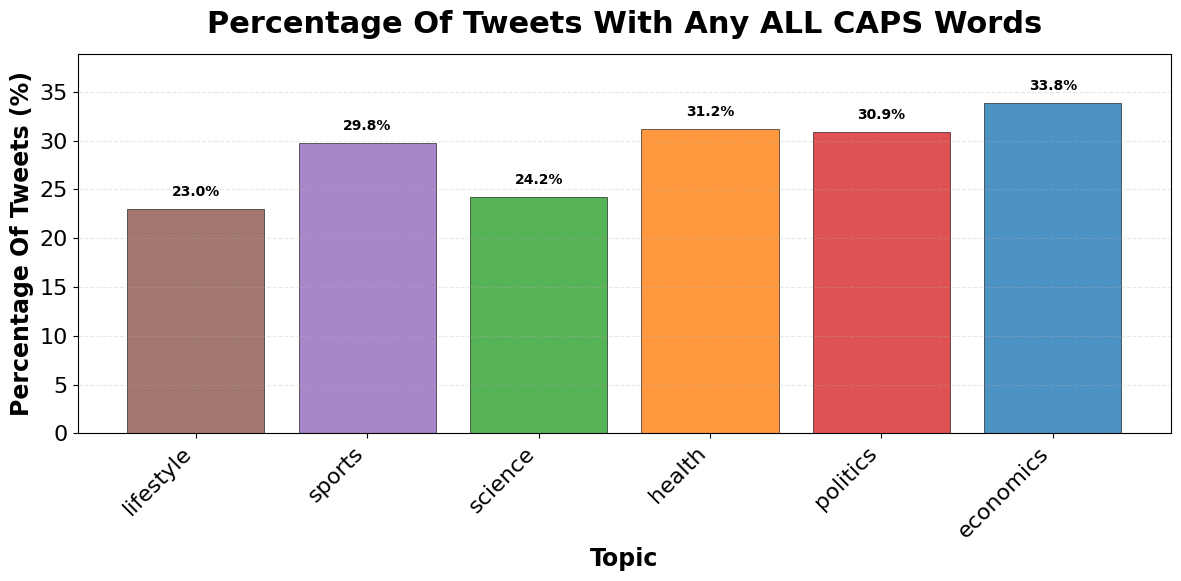

In [46]:
# Linguistic feature analysis by predicted topic
if 'predicted_classification' in df.columns and 'full_text' in df.columns:
    
    # Prepare data excluding unknown classifications
    df_linguistic = df[df['full_text'].notna() & (df['predicted_classification'] != 'unknown')].copy()
    df_linguistic['full_text'] = df_linguistic['full_text'].astype(str).fillna('')
    
    print(f"Analyzing linguistic features for {len(df_linguistic):,} tweets across {df_linguistic['predicted_classification'].nunique()} topics")
    
    # Calculate linguistic features
    df_linguistic['text_length'] = df_linguistic['full_text'].apply(len)
    df_linguistic['num_caps'] = df_linguistic['full_text'].apply(lambda x: sum(1 for c in x if c.isupper()))
    df_linguistic['num_exclamations'] = df_linguistic['full_text'].str.count('!')
    
    def count_all_caps_words(text):
        """Count words that are entirely uppercase (length >= 2)."""
        if pd.isna(text):
            return 0
        words = str(text).split()
        return sum(1 for word in words if word.isupper() and len(word) >= 2 and word.isalpha())
    
    df_linguistic['num_all_caps_words'] = df_linguistic['full_text'].apply(count_all_caps_words)
    
    try:
        df_linguistic['num_emojis'] = df_linguistic['full_text'].apply(emoji.emoji_count)
    except:
        df_linguistic['num_emojis'] = 0
    
    # Calculate summary statistics by topic
    linguistic_features = ['text_length', 'num_caps', 'num_exclamations', 'num_emojis', 'num_all_caps_words']
    available_features = [col for col in linguistic_features if col in df_linguistic.columns]
    
    if available_features:
        linguistic_summary = df_linguistic.groupby('predicted_classification')[available_features].mean().round(2)
        
        # Order topics by text length for consistency
        if 'text_length' in df_linguistic.columns:
            topic_order = df_linguistic.groupby('predicted_classification')['text_length'].median().sort_values().index
        else:
            topic_order = sorted(df_linguistic['predicted_classification'].unique())
        
        print(f"\nLinguistic Features Summary by Topic:")
        for topic in topic_order:
            topic_data = df_linguistic[df_linguistic['predicted_classification'] == topic]
            print(f"\n{format_column_name(topic)} (n={len(topic_data):,}):")
            print(f"  Avg Text Length: {topic_data['text_length'].mean():.1f} chars")
            print(f"  Avg Exclamations: {topic_data['num_exclamations'].mean():.2f}")
            print(f"  Tweets with Emojis: {(topic_data['num_emojis'] > 0).mean()*100:.1f}%")
            print(f"  Tweets with ALL CAPS: {(topic_data['num_all_caps_words'] > 0).mean()*100:.1f}%")
        
        # Generate visualizations for each feature
        colors = get_color_palette(topic_order, TOPIC_COLORS)
        
        for feature in available_features:
            
            if feature in ['num_exclamations', 'num_emojis', 'num_all_caps_words']:
                # Percentage analysis for sparse features
                df_linguistic[f'has_{feature}'] = (df_linguistic[feature] > 0)
                percentage_with_feature = df_linguistic.groupby('predicted_classification')[f'has_{feature}'].mean() * 100
                percentage_ordered = percentage_with_feature.loc[topic_order]
                
                plt.figure(figsize=(12, 6))
                bars = plt.bar(range(len(topic_order)), percentage_ordered.values,
                               color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
                
                feature_titles = {
                    'num_exclamations': 'Tweets With Any Exclamation Marks',
                    'num_emojis': 'Tweets With Any Emojis', 
                    'num_all_caps_words': 'Tweets With Any ALL CAPS Words'
                }
                
                plt.title(f'Percentage Of {feature_titles.get(feature, feature)}', 
                         fontweight='bold', pad=15)
                plt.ylabel('Percentage Of Tweets (%)', fontweight='bold')
                plt.xlabel('Topic', fontweight='bold')
                plt.xticks(range(len(topic_order)), topic_order, rotation=45, ha='right')
                
                # Add percentage labels with proper spacing
                for i, (bar, value) in enumerate(zip(bars, percentage_ordered.values)):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(percentage_ordered) * 0.03,
                            f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

                plt.grid(axis='y', alpha=0.3, linestyle='--')
                plt.ylim(0, max(percentage_ordered) * 1.15)  # Add 15% space at top for labels
                plt.tight_layout()
                
                if feature == 'num_exclamations':
                    save_current_plot('block4', 'exclamation_marks_percentage')
                elif feature == 'num_emojis':
                    save_current_plot('block4', 'emojis_percentage')
                elif feature == 'num_all_caps_words':
                    save_current_plot('block4', 'all_caps_words_percentage')
                plt.show()
                
            elif feature == 'text_length':
                # Box plot for text length distribution
                plt.figure(figsize=(12, 7))
                plot_data = [df_linguistic[df_linguistic['predicted_classification'] == topic][feature] 
                           for topic in topic_order]
                
                bp = plt.boxplot(plot_data, labels=topic_order, patch_artist=True, showfliers=False)
                
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                    patch.set_edgecolor('black')
                
                plt.title('Text Length Distribution Per Topic', fontweight='bold', pad=15)
                plt.ylabel('Text Length (Characters)', fontweight='bold')
                plt.xlabel('Topic', fontweight='bold')
                plt.xticks(rotation=45, ha='right')
                plt.grid(axis='y', alpha=0.3, linestyle='--')
                plt.tight_layout()
                save_current_plot('block4', 'text_length_distribution')
                plt.show()

## Text Readability Analysis by Topic

Applies Flesch Reading Ease scoring to evaluate text complexity across topic categories.


Readability analysis for 20,008 tweets with meaningful text content

Readability by Topic (Flesch Reading Ease):
  Politics: 44.4 (n=7,919.0)
  Science: 44.7 (n=2,013.0)
  Health: 47.3 (n=1,488.0)
  Lifestyle: 47.4 (n=6,403.0)
  Sports: 49.7 (n=1,188.0)
  Economics: 53.1 (n=997.0)


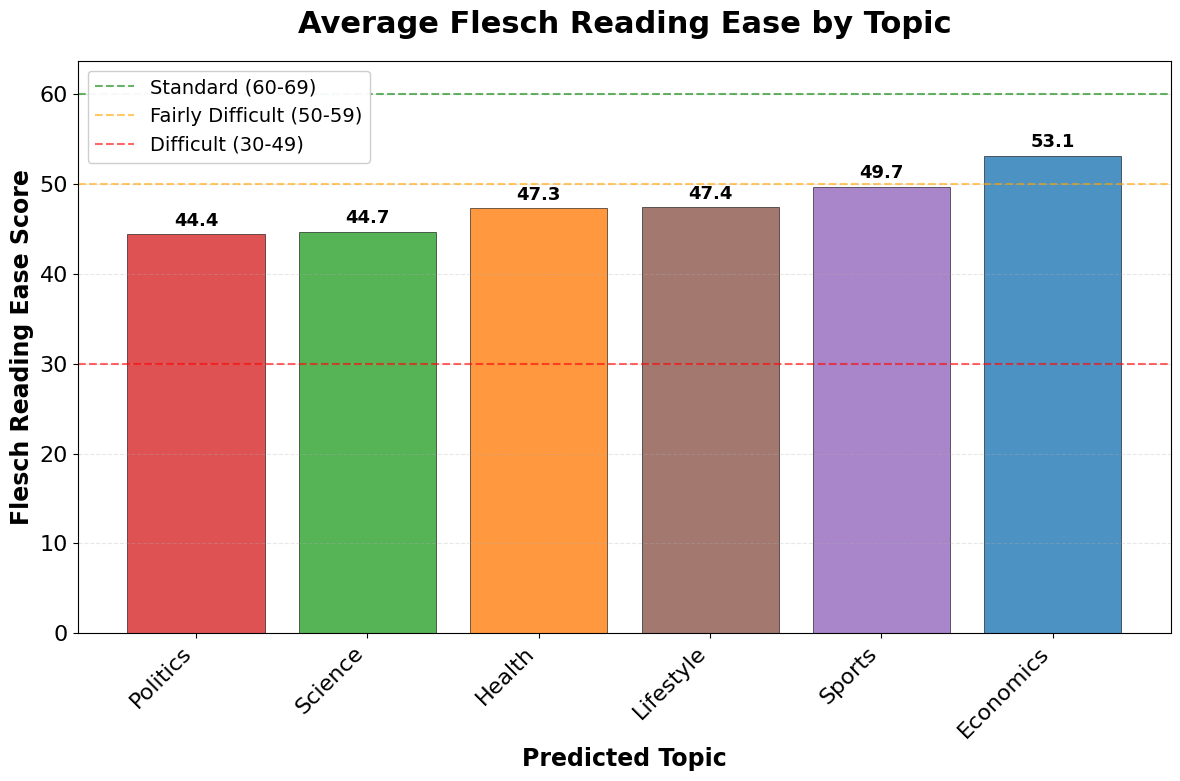

Readability analysis completed successfully


In [47]:
# Readability analysis with URL filtering
if 'predicted_classification' in df.columns and 'full_text' in df.columns:
    
    df_readability = df[df['predicted_classification'] != 'unknown'].copy()
    
    def is_meaningful_text(text):
        """Filter tweets with meaningful readable content (not just URLs)."""
        if pd.isna(text) or text == '':
            return False
        
        text_str = str(text).strip()
        url_pattern = r'https?://[^\s]+|www\.[^\s]+|t\.co/[^\s]+'
        text_without_urls = re.sub(url_pattern, '', text_str).strip()
        
        # Require substantial content after URL removal
        if len(text_without_urls) < 10:
            return False
        
        words = re.findall(r'\b[a-zA-Z]+\b', text_without_urls)
        if len(words) < 3:
            return False
        
        return True
    
    # Apply meaningful text filter
    df_readability['has_meaningful_text'] = df_readability['full_text'].apply(is_meaningful_text)
    df_readability = df_readability[df_readability['has_meaningful_text']].copy()
    
    print(f"\nReadability analysis for {len(df_readability):,} tweets with meaningful text content")
    
    if len(df_readability) > 0:
        df_readability['flesch_reading_ease'] = df_readability['full_text'].apply(
            lambda x: textstat.flesch_reading_ease(str(x)) if pd.notna(x) else 0
        )
        
        readability_stats = df_readability.groupby('predicted_classification')['flesch_reading_ease'].agg([
            'mean', 'count', 'std'
        ]).round(1)
        readability_stats = readability_stats.sort_values('mean')
        
        print(f"\nReadability by Topic (Flesch Reading Ease):")
        for topic, stats in readability_stats.iterrows():
            print(f"  {format_column_name(topic)}: {stats['mean']:.1f} (n={stats['count']:,})")
        
        # Create readability visualization
        plt.figure(figsize=(12, 8))
        colors = get_color_palette(readability_stats.index, TOPIC_COLORS)
        bars = plt.bar(range(len(readability_stats)), readability_stats['mean'].values, 
                       color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        plt.title('Average Flesch Reading Ease by Topic', fontweight='bold', pad=20)
        plt.xlabel('Predicted Topic', fontweight='bold')
        plt.ylabel('Flesch Reading Ease Score', fontweight='bold')
        
        formatted_labels = [format_column_name(label) for label in readability_stats.index]
        plt.xticks(range(len(readability_stats)), formatted_labels, rotation=45, ha='right')
        
        # Add score labels
        for i, (bar, topic) in enumerate(zip(bars, readability_stats.index)):
            mean_score = readability_stats.loc[topic, 'mean']
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(readability_stats['mean']) * 0.01,
                    f'{mean_score:.1f}', ha='center', va='bottom', fontweight='bold')
        
        # Add readability reference lines
        plt.axhline(y=60, color='green', linestyle='--', alpha=0.6, linewidth=1.5, label='Standard (60-69)')
        plt.axhline(y=50, color='orange', linestyle='--', alpha=0.6, linewidth=1.5, label='Fairly Difficult (50-59)')
        plt.axhline(y=30, color='red', linestyle='--', alpha=0.6, linewidth=1.5, label='Difficult (30-49)')
        
        plt.legend(loc='upper left', framealpha=0.95)
        plt.grid(axis='y', alpha=0.3, linestyle='--')
        plt.ylim(0, max(readability_stats['mean']) * 1.2)
        plt.tight_layout()
        
        save_current_plot('block4', 'flesch_reading_ease_by_topic_corrected')
        plt.show()
        
        print("Readability analysis completed successfully")

## Emoji Usage and Sentiment Correlation Analysis

Statistical analysis examining the relationship between emoji usage and sentiment scores across topic classifications.

In [68]:
# Emoji-sentiment correlation analysis for thesis calculations
if 'predicted_classification' in df.columns and 'full_text' in df.columns:

    from scipy import stats
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    
    # Prepare data for correlation analysis
    df_correlation = df[df['full_text'].notna() & (df['predicted_classification'] != 'unknown')].copy()
    df_correlation['full_text'] = df_correlation['full_text'].astype(str).fillna('')
    
    # Calculate sentiment scores
    sid = SentimentIntensityAnalyzer()
    df_correlation['sentiment_score'] = df_correlation['full_text'].apply(
        lambda x: sid.polarity_scores(x)['compound']
    )
    
    # Calculate emoji counts
    try:
        df_correlation['num_emojis'] = df_correlation['full_text'].apply(emoji.emoji_count)
    except:
        # Fallback emoji detection
        import re
        emoji_pattern = re.compile(
            "[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|"
            "[\U0001F1E0-\U0001F1FF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]"
        )
        df_correlation['num_emojis'] = df_correlation['full_text'].apply(
            lambda x: len(emoji_pattern.findall(x))
        )
    
    df_correlation = df_correlation[df_correlation['num_emojis'].notna()].copy()
    
    if len(df_correlation) > 50:
        print(f"\nEmoji-Sentiment Correlation Analysis for {len(df_correlation):,} tweets")
        
        # Calculate overall correlation coefficients
        correlation_coef, p_value = stats.pearsonr(df_correlation['num_emojis'], 
                                                  df_correlation['sentiment_score'])
        spearman_coef, spearman_p = stats.spearmanr(df_correlation['num_emojis'], 
                                                   df_correlation['sentiment_score'])
        
        # Regression analysis
        X = df_correlation['num_emojis'].values.reshape(-1, 1)
        y = df_correlation['sentiment_score'].values
        reg_model = LinearRegression()
        reg_model.fit(X, y)
        y_pred = reg_model.predict(X)
        r2 = r2_score(y, y_pred)
        
        print(f"\nOverall Correlation Results:")
        print(f"  Pearson correlation: {correlation_coef:+.4f} (p = {p_value:.3e})")
        print(f"  Spearman correlation: {spearman_coef:+.4f} (p = {spearman_p:.3e})")
        print(f"  R-squared: {r2:.4f}")
        print(f"  Regression slope: {reg_model.coef_[0]:+.4f}")
        
        # Emoji usage categorization and analysis
        def categorize_emoji_usage(num_emojis):
            if num_emojis == 0: return 'No Emojis (0)'
            elif num_emojis == 1: return 'Low (1)'
            elif num_emojis <= 3: return 'Medium (2-3)'
            elif num_emojis <= 5: return 'High (4-5)'
            else: return 'Very High (6+)'
        
        df_correlation['emoji_category'] = df_correlation['num_emojis'].apply(categorize_emoji_usage)
        
        # Calculate statistics by emoji category
        emoji_sentiment_stats = df_correlation.groupby('emoji_category')['sentiment_score'].agg([
            'mean', 'median', 'std', 'count'
        ]).round(3)
        
        category_order = ['No Emojis (0)', 'Low (1)', 'Medium (2-3)', 'High (4-5)', 'Very High (6+)']
        emoji_sentiment_stats = emoji_sentiment_stats.reindex(
            [cat for cat in category_order if cat in emoji_sentiment_stats.index]
        )
        
        print(f"\nEmoji Usage Breakdown:")
        for category, row in emoji_sentiment_stats.iterrows():
            percentage = (row['count'] / len(df_correlation)) * 100
            print(f"  {category}: {int(row['count']):,} tweets ({percentage:.1f}%) - Mean Sentiment: {row['mean']:+.3f}")
        
        # Topic-wise correlation analysis
        topic_correlations = {}
        for topic in df_correlation['predicted_classification'].unique():
            topic_data = df_correlation[df_correlation['predicted_classification'] == topic]
            
            if len(topic_data) >= 20:
                corr, p_val = stats.pearsonr(topic_data['num_emojis'], topic_data['sentiment_score'])
                topic_correlations[topic] = {
                    'correlation': corr,
                    'p_value': p_val,
                    'sample_size': len(topic_data)
                }
        
        if topic_correlations:
            corr_df = pd.DataFrame(topic_correlations).T.sort_values('correlation', ascending=False)
            
            print(f"\nTopic-wise Correlations:")
            for topic, data in corr_df.iterrows():
                sig_level = "***" if data['p_value'] < 0.001 else "**" if data['p_value'] < 0.01 else "*" if data['p_value'] < 0.05 else ""
                print(f"  {format_column_name(topic)}: r = {data['correlation']:+.3f}{sig_level} (n = {int(data['sample_size']):,})")
        
        # Export detailed results for thesis reference
        output_file = f"{ANALYSIS_DIR}/emoji_sentiment_correlation_analysis.txt"
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write("="*80 + "\n")
            f.write("EMOJI USAGE vs SENTIMENT CORRELATION ANALYSIS\n")
            f.write(f"Analysis based on {len(df_correlation):,} tweets\n")
            f.write("="*80 + "\n\n")
            
            f.write("OVERALL CORRELATION RESULTS:\n")
            f.write("-" * 40 + "\n")
            f.write(f"Pearson Correlation:    {correlation_coef:+.4f} (p = {p_value:.3e})\n")
            f.write(f"Spearman Correlation:   {spearman_coef:+.4f} (p = {spearman_p:.3e})\n")
            f.write(f"R-squared (Linear):     {r2:.4f}\n")
            f.write(f"Regression Slope:       {reg_model.coef_[0]:+.4f}\n")
            f.write(f"Regression Intercept:   {reg_model.intercept_:+.4f}\n\n")
            
            # Add emoji breakdown and topic correlations
            f.write("EMOJI USAGE BREAKDOWN:\n")
            f.write("-" * 40 + "\n")
            for category, row in emoji_sentiment_stats.iterrows():
                percentage = (row['count'] / len(df_correlation)) * 100
                f.write(f"{category}: {int(row['count']):,} tweets ({percentage:.1f}%) - Mean Sentiment: {row['mean']:+.3f}\n")
            
            f.write(f"\nTOPIC-WISE CORRELATIONS:\n")
            f.write("-" * 40 + "\n")
            if topic_correlations:
                for topic, data in corr_df.iterrows():
                    sig_level = "***" if data['p_value'] < 0.001 else "**" if data['p_value'] < 0.01 else "*" if data['p_value'] < 0.05 else ""
                    f.write(f"{format_column_name(topic)}: r = {data['correlation']:+.3f}{sig_level} (n = {int(data['sample_size']):,})\n")
        
        print(f"\nCorrelation analysis completed - results exported to analysis_results/emoji_sentiment_correlation_analysis.txt")
    
    else:
        print("Insufficient data for emoji-sentiment correlation analysis")


Emoji-Sentiment Correlation Analysis for 21,630 tweets

Overall Correlation Results:
  Pearson correlation: +0.0509 (p = 6.751e-14)
  Spearman correlation: +0.0659 (p = 2.761e-22)
  R-squared: 0.0026
  Regression slope: +0.0094

Emoji Usage Breakdown:
  No Emojis (0): 15,776 tweets (72.9%) - Mean Sentiment: -0.075
  Low (1): 2,918 tweets (13.5%) - Mean Sentiment: -0.011
  Medium (2-3): 2,267 tweets (10.5%) - Mean Sentiment: -0.021
  High (4-5): 438 tweets (2.0%) - Mean Sentiment: +0.069
  Very High (6+): 231 tweets (1.1%) - Mean Sentiment: +0.101

Topic-wise Correlations:
  Sports: r = +0.133*** (n = 1,259)
  Lifestyle: r = +0.064*** (n = 7,097)
  Politics: r = +0.043*** (n = 8,382)
  Science: r = +0.033 (n = 2,195)
  Economics: r = +0.012 (n = 1,041)
  Health: r = -0.034 (n = 1,656)

Correlation analysis completed - results exported to analysis_results/emoji_sentiment_correlation_analysis.txt


## Misinformation Subtype Distribution by Topic

Analyzes the prevalence of different misinformation subtypes across topic classifications.

Analyzing misinformation subtypes for 21,630 tweets across 6 topics

Misinformation Subtype Analysis Results:

ECONOMICS:
  Most prevalent subtype: Misleading Missing Important Context (65.7%)
  Misleading Missing Important Context: 65.7%
  Misleading Factual Error: 60.1%
  Misleading Unverified Claim As Fact: 27.0%
  Misleading Outdated Information: 15.7%
  Misleading Satire: 3.9%
  Misleading Manipulated Media: 2.3%

HEALTH:
  Most prevalent subtype: Misleading Factual Error (63.9%)
  Misleading Factual Error: 63.9%
  Misleading Missing Important Context: 62.4%
  Misleading Unverified Claim As Fact: 36.0%
  Misleading Outdated Information: 17.4%
  Misleading Satire: 3.4%
  Misleading Manipulated Media: 2.4%

LIFESTYLE:
  Most prevalent subtype: Misleading Missing Important Context (54.7%)
  Misleading Missing Important Context: 54.7%
  Misleading Factual Error: 50.0%
  Misleading Unverified Claim As Fact: 26.6%
  Misleading Manipulated Media: 22.5%
  Misleading Satire: 15.9%
  Mislea

<Figure size 1600x800 with 0 Axes>

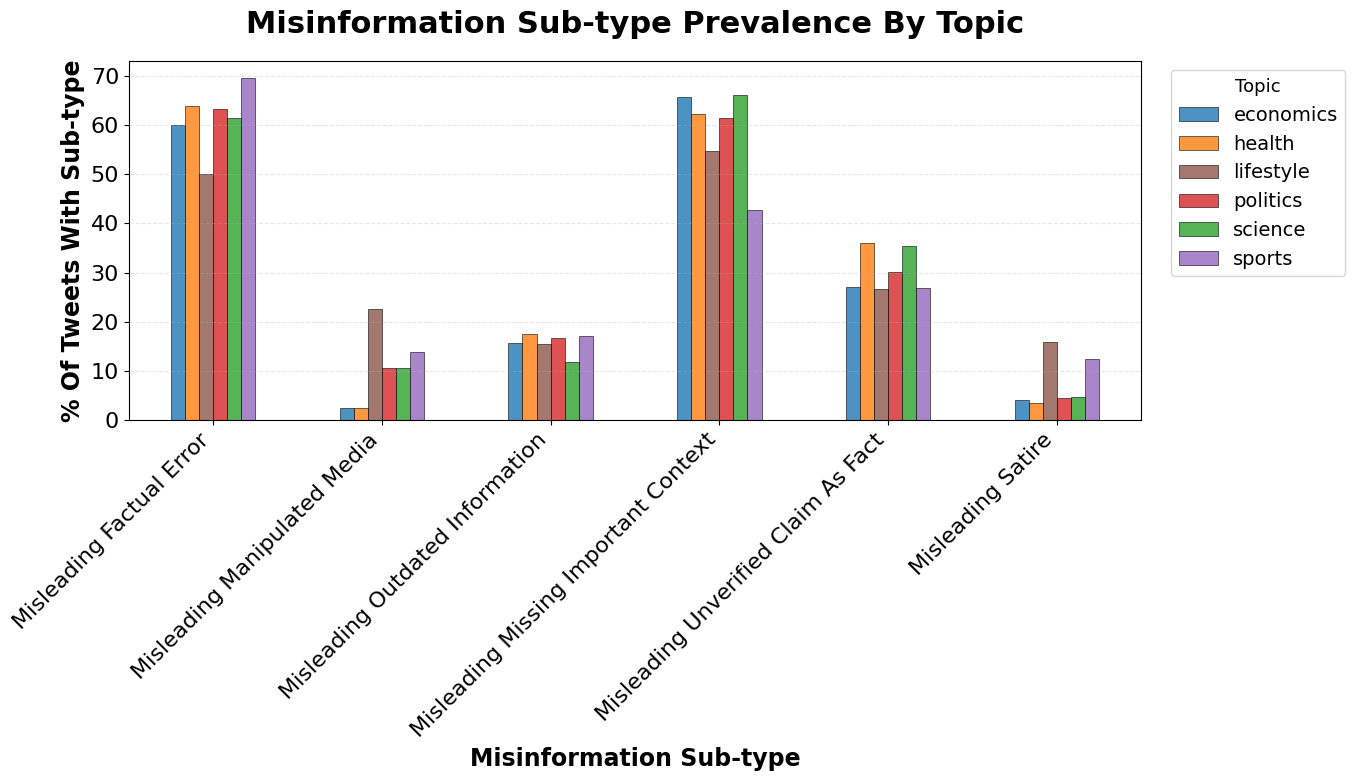


Detailed analysis exported to analysis_results/misinformation_subtypes_analysis.txt


In [52]:
# Topic vs misinformation subtypes analysis
if 'predicted_classification' in df.columns:
    
    # Define misinformation subtype columns
    MISINFO_COLUMNS = [
        'misleadingFactualError',
        'misleadingManipulatedMedia', 
        'misleadingOutdatedInformation',
        'misleadingMissingImportantContext',
        'misleadingUnverifiedClaimAsFact',
        'misleadingSatire'
    ]
    
    # Prepare analysis dataset excluding unknown topics
    unknown_topics = ['unknown', 'other', 'unclear']
    df_subtypes = df[~df['predicted_classification'].isin(unknown_topics)].copy()
    
    if not df_subtypes.empty:
        # Check available misinformation columns
        available_misinfo_cols = [col for col in MISINFO_COLUMNS if col in df_subtypes.columns]
        
        if available_misinfo_cols:
            print(f"Analyzing misinformation subtypes for {len(df_subtypes):,} tweets across {df_subtypes['predicted_classification'].nunique()} topics")
            
            # Calculate percentage of tweets with each subtype per topic
            subtype_percentages = df_subtypes.groupby('predicted_classification')[available_misinfo_cols].mean().mul(100).round(2)
            formatted_columns = [format_column_name(col) for col in subtype_percentages.columns]
            subtype_percentages.columns = formatted_columns
            
            # Print detailed findings for report reference
            print(f"\nMisinformation Subtype Analysis Results:")
            print(f"{'='*60}")
            
            for topic in subtype_percentages.index:
                topic_data = subtype_percentages.loc[topic]
                max_subtype = topic_data.idxmax()
                max_value = topic_data.max()
                
                print(f"\n{format_column_name(topic).upper()}:")
                print(f"  Most prevalent subtype: {max_subtype} ({max_value:.1f}%)")
                
                # Show all subtypes for this topic
                sorted_subtypes = topic_data.sort_values(ascending=False)
                for subtype, percentage in sorted_subtypes.items():
                    print(f"  {subtype}: {percentage:.1f}%")
            
            # Key pattern analysis for thesis findings
            print(f"\n{'='*60}")
            print(f"KEY PATTERNS IDENTIFIED:")
            
            # Find topics with highest prevalence of each subtype
            for subtype in subtype_percentages.columns:
                top_topic = subtype_percentages[subtype].idxmax()
                top_value = subtype_percentages[subtype].max()
                print(f"  {subtype}: Highest in {format_column_name(top_topic)} ({top_value:.1f}%)")
            
            # Create required visualization (transposed bar chart)
            plt.figure(figsize=(16, 8))
            subtype_transposed = subtype_percentages.T
            
            # Get consistent topic colors
            topic_colors = [get_color_palette([topic], TOPIC_COLORS)[0] for topic in subtype_transposed.columns]
            
            ax = subtype_transposed.plot(kind='bar', figsize=(16, 8), 
                                       color=topic_colors, alpha=0.8, 
                                       edgecolor='black', linewidth=0.5)
            
            plt.title('Misinformation Sub-type Prevalence By Topic', fontweight='bold', pad=20)
            plt.ylabel('% Of Tweets With Sub-type', fontweight='bold')
            plt.xlabel('Misinformation Sub-type', fontweight='bold')
            plt.xticks(rotation=45, ha="right")
            
            plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc='upper left')
            plt.grid(axis='y', alpha=0.3, linestyle='--')
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            
            save_current_plot('block5', 'misinformation_subtypes_by_topic_transposed')
            plt.show()
            
            # Export detailed analysis for thesis reference
            output_file = f"{ANALYSIS_DIR}/misinformation_subtypes_analysis.txt"
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write("MISINFORMATION SUBTYPES BY TOPIC ANALYSIS\n")
                f.write("="*50 + "\n\n")
                
                for topic in subtype_percentages.index:
                    f.write(f"{format_column_name(topic).upper()}:\n")
                    topic_data = subtype_percentages.loc[topic].sort_values(ascending=False)
                    for subtype, percentage in topic_data.items():
                        f.write(f"  {subtype}: {percentage:.1f}%\n")
                    f.write("\n")
            
            print(f"\nDetailed analysis exported to analysis_results/misinformation_subtypes_analysis.txt")

## Engagement-Sentiment Correlation Analysis
Calculates Pearson correlation coefficients between engagement metrics (retweets, favorites, replies, quotes) and sentiment scores to understand the relationship between emotional tone and user interaction patterns. Saves detailed statistical results for thesis reference.

In [ ]:
# Engagement-sentiment correlation analysis
if 'predicted_classification' in df.columns and 'full_text' in df.columns:
    
    print("\n" + "="*60)
    print("ENGAGEMENT-SENTIMENT CORRELATION ANALYSIS")
    print("="*60)
    
    try:
        from nltk.sentiment.vader import SentimentIntensityAnalyzer
        from scipy import stats
        from sklearn.linear_model import LinearRegression
        from sklearn.metrics import r2_score
        
        print("✓ Required libraries loaded successfully")
        
        # Initialize sentiment analyzer
        sid = SentimentIntensityAnalyzer()
        
        # Define engagement columns to analyze
        ENGAGEMENT_COLUMNS = [
            'retweet_count',
            'favorite_count', 
            'reply_count',
            'quote_count'
        ]
        
        # Prepare data (exclude unknown topics and ensure meaningful data)
        unknown_topics = ['unknown', 'other', 'unclear']
        df_correlation = df[df['full_text'].notna() & 
                          (~df['predicted_classification'].isin(unknown_topics))].copy()
        df_correlation['full_text'] = df_correlation['full_text'].astype(str).fillna('')
        
        print(f"✓ Analyzing {len(df_correlation):,} tweets for engagement-sentiment correlations")
        
        # Calculate sentiment scores if not already present
        if 'sentiment_score' not in df_correlation.columns:
            print("🔄 Calculating VADER sentiment scores...")
            df_correlation['sentiment_score'] = df_correlation['full_text'].apply(
                lambda x: sid.polarity_scores(x)['compound']
            )
            print("✓ Sentiment scores calculated")
        else:
            print("✓ Using existing sentiment scores")
        
        # Check which engagement columns are available
        engagement_cols_present = [col for col in ENGAGEMENT_COLUMNS if col in df_correlation.columns]
        
        if engagement_cols_present and len(df_correlation) > 50:
            
            print(f"✓ Available engagement metrics: {[format_column_name(col) for col in engagement_cols_present]}")
            
            # Create total engagement metric
            df_correlation['total_engagement'] = df_correlation[engagement_cols_present].sum(axis=1)
            all_engagement_cols = engagement_cols_present + ['total_engagement']
            
            # Calculate correlations between all engagement metrics and sentiment
            sentiment_correlations = {}
            
            for col in all_engagement_cols:
                corr_coef, p_value = stats.pearsonr(df_correlation[col], df_correlation['sentiment_score'])
                sentiment_correlations[col] = {
                    'correlation': corr_coef,
                    'p_value': p_value,
                    'sample_size': len(df_correlation.dropna(subset=[col, 'sentiment_score']))
                }
            
            # Calculate regression analysis for favorites if available
            regression_results = {}
            if 'favorite_count' in engagement_cols_present:
                X_fav = df_correlation['favorite_count'].values.reshape(-1, 1)
                y_sent = df_correlation['sentiment_score'].values
                
                reg_model_fav = LinearRegression()
                reg_model_fav.fit(X_fav, y_sent)
                y_pred_fav = reg_model_fav.predict(X_fav)
                r2_fav = r2_score(y_sent, y_pred_fav)
                
                regression_results['favorite_count'] = {
                    'r_squared': r2_fav,
                    'slope': reg_model_fav.coef_[0],
                    'intercept': reg_model_fav.intercept_
                }
            
            # Calculate engagement metrics intercorrelations
            engagement_intercorr = {}
            for i, metric1 in enumerate(all_engagement_cols):
                for metric2 in all_engagement_cols[i+1:]:
                    if metric1 in df_correlation.columns and metric2 in df_correlation.columns:
                        corr = df_correlation[metric1].corr(df_correlation[metric2])
                        engagement_intercorr[f"{metric1}_vs_{metric2}"] = corr
            
            # Topic-wise correlation analysis
            topic_correlations = {}
            for topic in df_correlation['predicted_classification'].unique():
                topic_data = df_correlation[df_correlation['predicted_classification'] == topic]
                
                if len(topic_data) >= 20:  # Only analyze topics with sufficient data
                    topic_correlations[topic] = {}
                    
                    for metric in ['favorite_count', 'total_engagement']:
                        if metric in topic_data.columns:
                            corr, p_val = stats.pearsonr(topic_data[metric], topic_data['sentiment_score'])
                            topic_correlations[topic][metric] = {
                                'correlation': corr,
                                'p_value': p_val,
                                'sample_size': len(topic_data)
                            }
            
            # Print summary of key findings
            print(f"\n📊 KEY CORRELATION FINDINGS:")
            for metric, data in sentiment_correlations.items():
                corr = data['correlation']
                p_val = data['p_value']
                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                print(f"  {format_column_name(metric)}: r = {corr:+.4f}{significance} (p = {p_val:.3e})")
            
            # Save detailed results to text file
            output_file = f"{ANALYSIS_DIR}/engagement_sentiment_correlation_analysis.txt"
            os.makedirs(ANALYSIS_DIR, exist_ok=True)
            
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write("="*80 + "\n")
                f.write("ENGAGEMENT METRICS vs SENTIMENT CORRELATION ANALYSIS\n")
                f.write(f"Analysis based on {len(df_correlation):,} tweets\n")
                f.write("="*80 + "\n\n")
                
                f.write("OVERALL SENTIMENT CORRELATION RESULTS:\n")
                f.write("-" * 50 + "\n")
                for metric, data in sentiment_correlations.items():
                    corr = data['correlation']
                    p_val = data['p_value']
                    n = data['sample_size']
                    significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                    f.write(f"{format_column_name(metric):20s}: r = {corr:+.4f}{significance:3s} (p = {p_val:.3e}, n = {n:,})\n")
                
                f.write(f"\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05\n\n")
                
                # Detailed analysis for favorite count if available
                if 'favorite_count' in sentiment_correlations:
                    fav_data = sentiment_correlations['favorite_count']
                    f.write("FAVORITE COUNT vs SENTIMENT - DETAILED ANALYSIS:\n")
                    f.write("-" * 50 + "\n")
                    f.write(f"Correlation Coefficient: {fav_data['correlation']:+.4f}\n")
                    f.write(f"P-value: {fav_data['p_value']:.3e}\n")
                    
                    if 'favorite_count' in regression_results:
                        reg_data = regression_results['favorite_count']
                        f.write(f"R-squared (Linear): {reg_data['r_squared']:.4f}\n")
                        f.write(f"Regression Slope: {reg_data['slope']:+.6f}\n")
                        f.write(f"Regression Intercept: {reg_data['intercept']:+.4f}\n")
                    
                    f.write(f"\nINTERPRETATION:\n")
                    
                    # Interpret correlation strength
                    if abs(fav_data['correlation']) < 0.1:
                        strength = "negligible"
                    elif abs(fav_data['correlation']) < 0.3:
                        strength = "weak"
                    elif abs(fav_data['correlation']) < 0.5:
                        strength = "moderate"
                    elif abs(fav_data['correlation']) < 0.7:
                        strength = "strong"
                    else:
                        strength = "very strong"
                    
                    direction = "positive" if fav_data['correlation'] > 0 else "negative"
                    significance = "significant" if fav_data['p_value'] < 0.05 else "not significant"
                    
                    f.write(f"The correlation between favorite count and sentiment is {strength} and {direction}.\n")
                    f.write(f"This correlation is statistically {significance}.\n")
                    
                    if 'favorite_count' in regression_results:
                        reg_slope = regression_results['favorite_count']['slope']
                        f.write(f"Each additional favorite is associated with a {reg_slope:+.6f} change in sentiment score.\n")
                    
                    f.write("\n")
                
                # Engagement metrics intercorrelations
                if engagement_intercorr:
                    f.write("ENGAGEMENT METRICS INTERCORRELATIONS:\n")
                    f.write("-" * 50 + "\n")
                    for pair, corr in engagement_intercorr.items():
                        metric1, metric2 = pair.split('_vs_')
                        f.write(f"{format_column_name(metric1)} vs {format_column_name(metric2)}: {corr:.3f}\n")
                    f.write("\n")
                
                # Topic-wise correlations
                if topic_correlations:
                    f.write("TOPIC-WISE FAVORITE-SENTIMENT CORRELATIONS:\n")
                    f.write("-" * 50 + "\n")
                    for topic, data in topic_correlations.items():
                        if 'favorite_count' in data:
                            fav_corr = data['favorite_count']['correlation']
                            fav_p = data['favorite_count']['p_value']
                            sample_size = data['favorite_count']['sample_size']
                            sig_level = "***" if fav_p < 0.001 else "**" if fav_p < 0.01 else "*" if fav_p < 0.05 else ""
                            f.write(f"{format_column_name(topic):20s}: r = {fav_corr:+.3f}{sig_level:3s} (n = {sample_size:4,})\n")
                    f.write("\n")
                
                # Statistical summary
                f.write("STATISTICAL SUMMARY:\n")
                f.write("-" * 50 + "\n")
                f.write(f"Total tweets analyzed: {len(df_correlation):,}\n")
                f.write(f"Engagement metrics available: {len(engagement_cols_present)}\n")
                f.write(f"Topics analyzed for correlations: {len(topic_correlations)}\n")
                f.write(f"Analysis date: Generated for thesis reference\n")
                
                sentiment_range = df_correlation['sentiment_score'].agg(['min', 'max', 'mean', 'std'])
                f.write(f"\nSentiment score statistics:\n")
                f.write(f"  Range: {sentiment_range['min']:.3f} to {sentiment_range['max']:.3f}\n")
                f.write(f"  Mean: {sentiment_range['mean']:.3f}\n")
                f.write(f"  Standard deviation: {sentiment_range['std']:.3f}\n")
            
            print("✓ Engagement-sentiment correlation analysis completed successfully")
            print(f"✓ Detailed results saved to: {output_file}")
            
            # Show key correlations for thesis reference
            if 'favorite_count' in sentiment_correlations:
                fav_corr = sentiment_correlations['favorite_count']['correlation']
                fav_p = sentiment_correlations['favorite_count']['p_value']
                print(f"📊 Key finding - Favorites vs sentiment: r = {fav_corr:+.4f} (p = {fav_p:.4f})")
                
            if 'reply_count' in sentiment_correlations:
                reply_corr = sentiment_correlations['reply_count']['correlation']
                reply_p = sentiment_correlations['reply_count']['p_value']
                print(f"📊 Key finding - Replies vs sentiment: r = {reply_corr:+.4f} (p = {reply_p:.4f})")
            
        else:
            print("❌ Insufficient data or missing engagement columns for correlation analysis")
            
    except ImportError as e:
        print(f"❌ Required libraries not available: {e}")
        print("📦 Install with: pip install nltk scipy scikit-learn")
        
    except Exception as e:
        print(f"❌ Error in engagement-sentiment correlation analysis: {e}")
        
else:
    missing_cols = []
    if 'predicted_classification' not in df.columns:
        missing_cols.append('predicted_classification')
    if 'full_text' not in df.columns:
        missing_cols.append('full_text')
    print(f"❌ Required columns not found: {missing_cols}")


ENGAGEMENT-SENTIMENT CORRELATION ANALYSIS
✓ Required libraries loaded successfully
✓ Analyzing 21,630 tweets for engagement-sentiment correlations
🔄 Calculating VADER sentiment scores...
✓ Sentiment scores calculated
✓ Available engagement metrics: ['Retweet Count', 'Favorite Count', 'Reply Count', 'Quote Count']

📊 KEY CORRELATION FINDINGS:
  Retweet Count: r = -0.0290*** (p = 2.023e-05)
  Favorite Count: r = +0.0169* (p = 1.271e-02)
  Reply Count: r = -0.0221** (p = 1.179e-03)
  Quote Count: r = -0.0082 (p = 2.252e-01)
  Total Engagement: r = +0.0095 (p = 1.615e-01)
✓ Engagement-sentiment correlation analysis completed successfully
✓ Detailed results saved to: graphs/engagement_sentiment_correlation_analysis.txt
📊 Key finding - Favorites vs sentiment: r = +0.0169 (p = 0.0127)
📊 Key finding - Replies vs sentiment: r = -0.0221 (p = 0.0012)


## Topic Engagement Performance Analysis
Analyzes engagement metrics (retweets, favorites, replies, quotes) across predicted topic categories to identify patterns in user interaction.  
Uses percentage performance relative to the mean of topic medians to enable direct comparison between topics.


TOPIC ENGAGEMENT PERFORMANCE ANALYSIS
✓ Analyzing 21,630 tweets across 6 topics
✓ Using engagement metrics: ['Retweet Count', 'Favorite Count', 'Reply Count', 'Quote Count']

Topic Performance Summary (% above/below topic average):
  Science: -32.9% average performance
  Health: -23.2% average performance
  Economics: +4.9% average performance
  Lifestyle: +7.7% average performance
  Politics: +17.2% average performance
  Sports: +26.4% average performance


<Figure size 1400x1000 with 0 Axes>

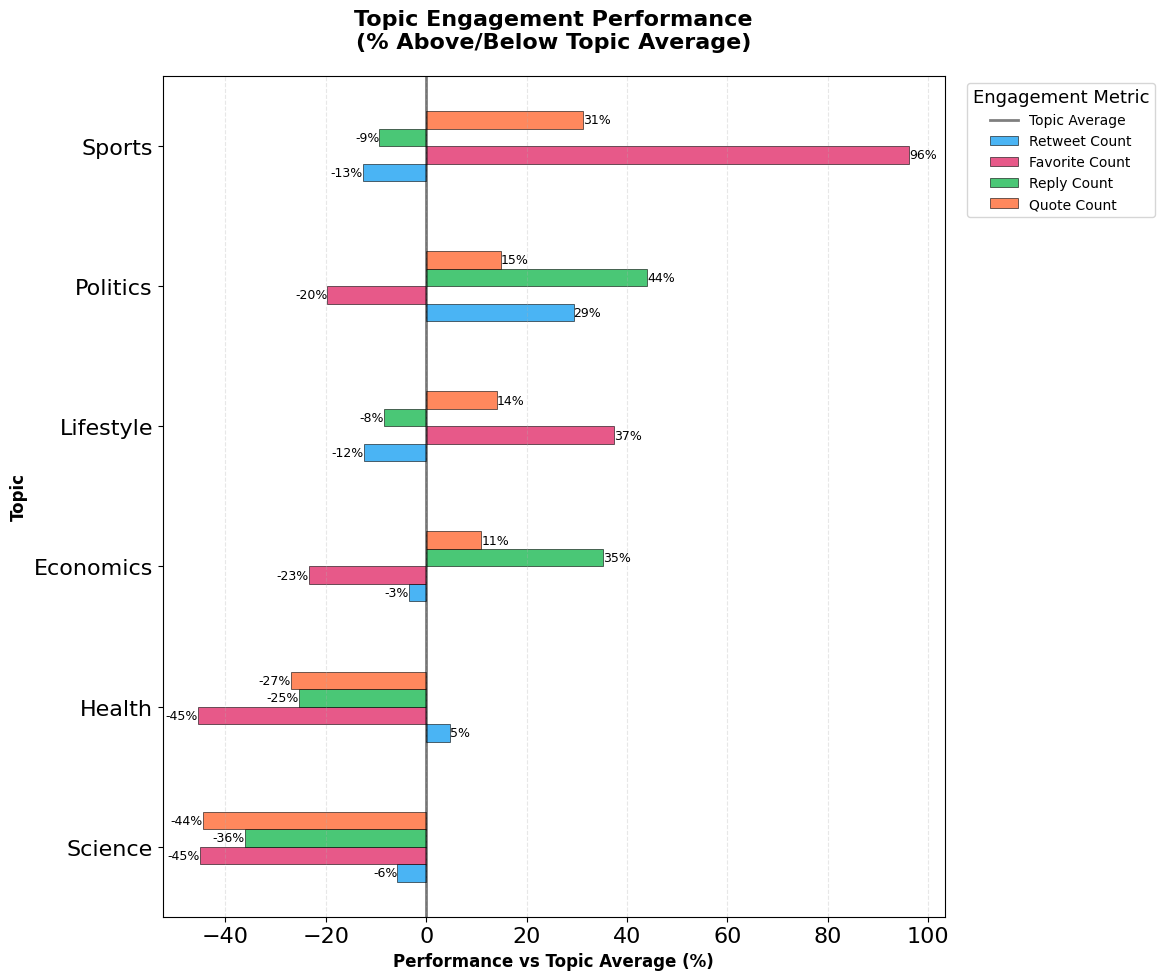

✓ Topic engagement analysis completed successfully


In [57]:
# Topic engagement performance analysis
if 'predicted_classification' in df.columns:
    
    print("\n" + "="*60)
    print("TOPIC ENGAGEMENT PERFORMANCE ANALYSIS")
    print("="*60)
    
    # Define engagement columns
    ENGAGEMENT_COLUMNS = ['retweet_count', 'favorite_count', 'reply_count', 'quote_count']
    
    # Create subset excluding unknown topics
    unknown_topics = ['unknown', 'other', 'unclear']
    df_engagement = df[~df['predicted_classification'].isin(unknown_topics)].copy()
    
    if not df_engagement.empty:
        # Check available engagement columns
        engagement_cols_present = [col for col in ENGAGEMENT_COLUMNS if col in df_engagement.columns]
        
        if engagement_cols_present:
            print(f"✓ Analyzing {len(df_engagement):,} tweets across {df_engagement['predicted_classification'].nunique()} topics")
            print(f"✓ Using engagement metrics: {[format_column_name(col) for col in engagement_cols_present]}")
            
            # Calculate median engagement by topic (robust to outliers)
            engagement_median = df_engagement.groupby('predicted_classification')[engagement_cols_present].median()
            
            # Calculate percentage performance relative to mean of topic medians (matches original methodology)
            topic_medians_mean = engagement_median.mean(axis=0)  # Mean of topic medians for each metric
            topic_performance = ((engagement_median.div(topic_medians_mean, axis=1) - 1) * 100).fillna(0)
            
            # Format metric names for display
            formatted_metrics = [format_column_name(col) for col in topic_performance.columns]
            topic_performance.columns = formatted_metrics
            
            # Format topic names for display
            formatted_topics = [format_column_name(idx) for idx in topic_performance.index]
            topic_performance.index = formatted_topics
            
            # Sort by overall performance (average across all metrics)
            overall_performance = topic_performance.mean(axis=1)
            topic_performance = topic_performance.loc[overall_performance.sort_values(ascending=True).index]
            
            print(f"\nTopic Performance Summary (% above/below topic average):")
            for topic in topic_performance.index:
                avg_performance = topic_performance.loc[topic].mean()
                print(f"  {topic}: {avg_performance:+.1f}% average performance")
            
            # Create horizontal performance chart
            plt.figure(figsize=(14, 10))
            
            # Get colors for metrics
            metric_colors = []
            for col in engagement_cols_present:
                if col == 'retweet_count':
                    metric_colors.append('#1DA1F2')  # Twitter blue
                elif col == 'favorite_count':
                    metric_colors.append('#E1306C')  # Instagram pink
                elif col == 'reply_count':
                    metric_colors.append('#1DB954')  # Spotify green
                elif col == 'quote_count':
                    metric_colors.append('#FF6B35')  # Orange
                else:
                    metric_colors.append('#4ECDC4')  # Default teal
            
            # Create horizontal grouped bar chart
            ax = topic_performance.plot(kind='barh', 
                                       figsize=(14, 10),
                                       color=metric_colors,
                                       alpha=0.8,
                                       edgecolor='black',
                                       linewidth=0.5)
            
            # Add zero reference line (topic average performance)
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=2, label='Topic Average')
            
            # Customize chart
            plt.title('Topic Engagement Performance\n(% Above/Below Topic Average)', 
                      fontweight='bold', pad=20, fontsize=16)
            plt.xlabel('Performance vs Topic Average (%)', fontweight='bold', fontsize=12)
            plt.ylabel('Topic', fontweight='bold', fontsize=12)
            
            # Add grid for readability
            plt.grid(axis='x', alpha=0.3, linestyle='--')
            
            # Customize legend
            plt.legend(title="Engagement Metric", 
                       bbox_to_anchor=(1.02, 1), 
                       loc='upper left',
                       fontsize=10)
            
            # Add value labels on bars for significant values
            for container in ax.containers:
                ax.bar_label(container, fmt='%.0f%%', fontsize=9, padding=0)
            
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            save_current_plot('block13', 'topic_engagement')
            plt.show()
            
            print("✓ Topic engagement analysis completed successfully")
        else:
            print("❌ No engagement columns found in dataset")
    else:
        print("❌ No data available for topic engagement analysis")
else:
    print("❌ Column 'predicted_classification' not found in dataset")

## Media Type Engagement Performance Analysis
Examines how different media types (text, photo, video, links) affect user engagement patterns.  
Calculates performance relative to the mean of media type medians to identify which media formats drive higher interaction rates.


MEDIA TYPE ENGAGEMENT PERFORMANCE ANALYSIS


✓ Analyzing 23,928 tweets across 5 media types
✓ Using engagement metrics: ['Retweet Count', 'Favorite Count', 'Reply Count', 'Quote Count']

Media Type Performance Summary (% above/below media type average):
  Other Link: -36.9% average performance
  Text Only: -11.2% average performance
  Animated GIF: +1.4% average performance
  Photo: +9.2% average performance
  Video: +37.4% average performance


<Figure size 1400x1000 with 0 Axes>

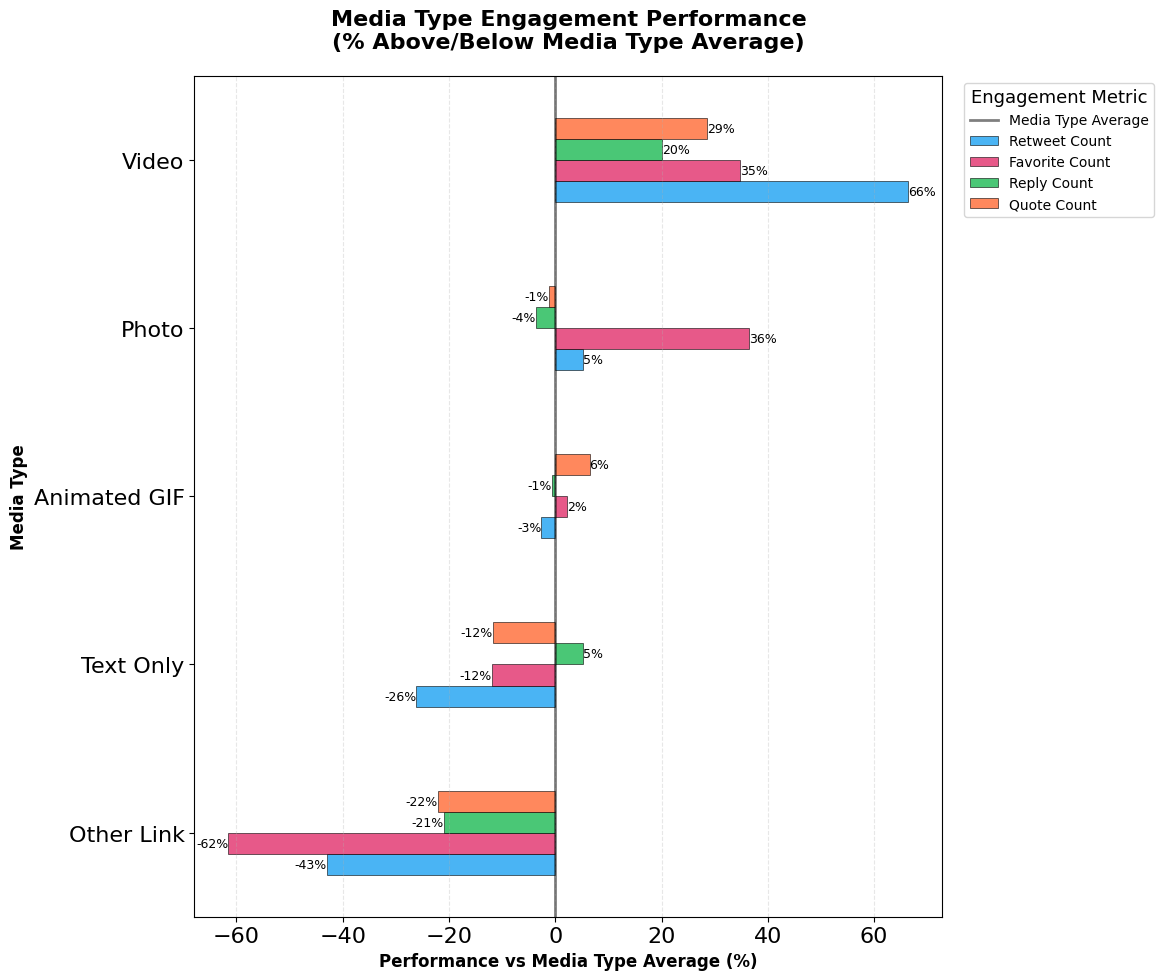

✓ Media type engagement analysis completed successfully


In [59]:
# Media type engagement performance analysis
if 'media_type' in df.columns:
    
    print("\n" + "="*60)
    print("MEDIA TYPE ENGAGEMENT PERFORMANCE ANALYSIS")
    print("="*60)
    
    # Define engagement metrics
    ENGAGEMENT_METRICS = ['retweet_count', 'favorite_count', 'reply_count', 'quote_count']
    available_metrics = [col for col in ENGAGEMENT_METRICS if col in df.columns]
    
    if available_metrics:
        # Prepare data
        df_media_engagement = df[df[available_metrics].notna().any(axis=1)].copy()
        
        print(f"✓ Analyzing {len(df_media_engagement):,} tweets across {df_media_engagement['media_type'].nunique()} media types")
        print(f"✓ Using engagement metrics: {[format_column_name(col) for col in available_metrics]}")
        
        # Calculate median engagement by media type (robust to outliers)
        media_engagement_median = df_media_engagement.groupby('media_type')[available_metrics].median()
        
        # Calculate percentage performance relative to mean of media type medians (matches original methodology)
        media_medians_mean = media_engagement_median.mean(axis=0)  # Mean of media type medians for each metric
        media_performance = ((media_engagement_median.div(media_medians_mean, axis=1) - 1) * 100).fillna(0)
        
        # Format metric names for display
        formatted_metrics = [format_column_name(col) for col in media_performance.columns]
        media_performance.columns = formatted_metrics
        
        # Format media type names for display
        formatted_media_types = [format_column_name(idx) for idx in media_performance.index]
        media_performance.index = formatted_media_types
        
        # Sort by overall performance (average across all metrics)
        overall_performance = media_performance.mean(axis=1)
        media_performance = media_performance.loc[overall_performance.sort_values(ascending=True).index]
        
        print(f"\nMedia Type Performance Summary (% above/below media type average):")
        for media_type in media_performance.index:
            avg_performance = media_performance.loc[media_type].mean()
            print(f"  {media_type}: {avg_performance:+.1f}% average performance")
        
        # Create horizontal performance chart
        plt.figure(figsize=(14, 10))
        
        # Get colors for metrics (consistent with topic analysis)
        metric_colors = []
        for col in available_metrics:
            if col == 'retweet_count':
                metric_colors.append('#1DA1F2')  # Twitter blue
            elif col == 'favorite_count':
                metric_colors.append('#E1306C')  # Instagram pink
            elif col == 'reply_count':
                metric_colors.append('#1DB954')  # Spotify green
            elif col == 'quote_count':
                metric_colors.append('#FF6B35')  # Orange
            else:
                metric_colors.append('#4ECDC4')  # Default teal
        
        # Create horizontal grouped bar chart
        ax = media_performance.plot(kind='barh', 
                                   figsize=(14, 10),
                                   color=metric_colors,
                                   alpha=0.8,
                                   edgecolor='black',
                                   linewidth=0.5)
        
        # Add zero reference line (media type average performance)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=2, label='Media Type Average')
        
        # Customize chart
        plt.title('Media Type Engagement Performance\n(% Above/Below Media Type Average)', 
                  fontweight='bold', pad=20, fontsize=16)
        plt.xlabel('Performance vs Media Type Average (%)', fontweight='bold', fontsize=12)
        plt.ylabel('Media Type', fontweight='bold', fontsize=12)
        
        # Add grid for readability
        plt.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Customize legend
        plt.legend(title="Engagement Metric", 
                   bbox_to_anchor=(1.02, 1), 
                   loc='upper left',
                   fontsize=10)
        
        # Add value labels on bars for significant values
        for container in ax.containers:
            ax.bar_label(container, fmt='%.0f%%', fontsize=9, padding=0)
        
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        save_current_plot('block14', 'media_engagement')
        plt.show()
        
        print("✓ Media type engagement analysis completed successfully")
    else:
        print("❌ No engagement metrics found in dataset")
else:
    print("❌ Column 'media_type' not found in dataset")

## Topic-Media Interaction Effects Analysis
Investigates how specific combinations of topics and media formats affect engagement beyond general media type trends.  
Uses text-only content as baseline to measure additional engagement boost or penalty from visual media within each topic category.


TOPIC-MEDIA INTERACTION EFFECTS ANALYSIS
✓ Analyzing interaction effects for 21,630 tweets
✓ Topics: 6
✓ Media types: 4

Interaction Effects Summary:
  Economics: photo: -8.9%, video: -4.3%, other link: -22.8%
  Politics: photo: +3.2%, video: +8.4%, other link: -5.3%
  Sports: photo: +16.2%, video: +11.1%, other link: -19.9%
  Science: photo: +0.7%, video: +10.3%, other link: -3.4%
  Health: photo: +6.1%, video: +11.4%, other link: -6.8%
  Lifestyle: photo: +18.9%, video: +18.0%, other link: -7.9%


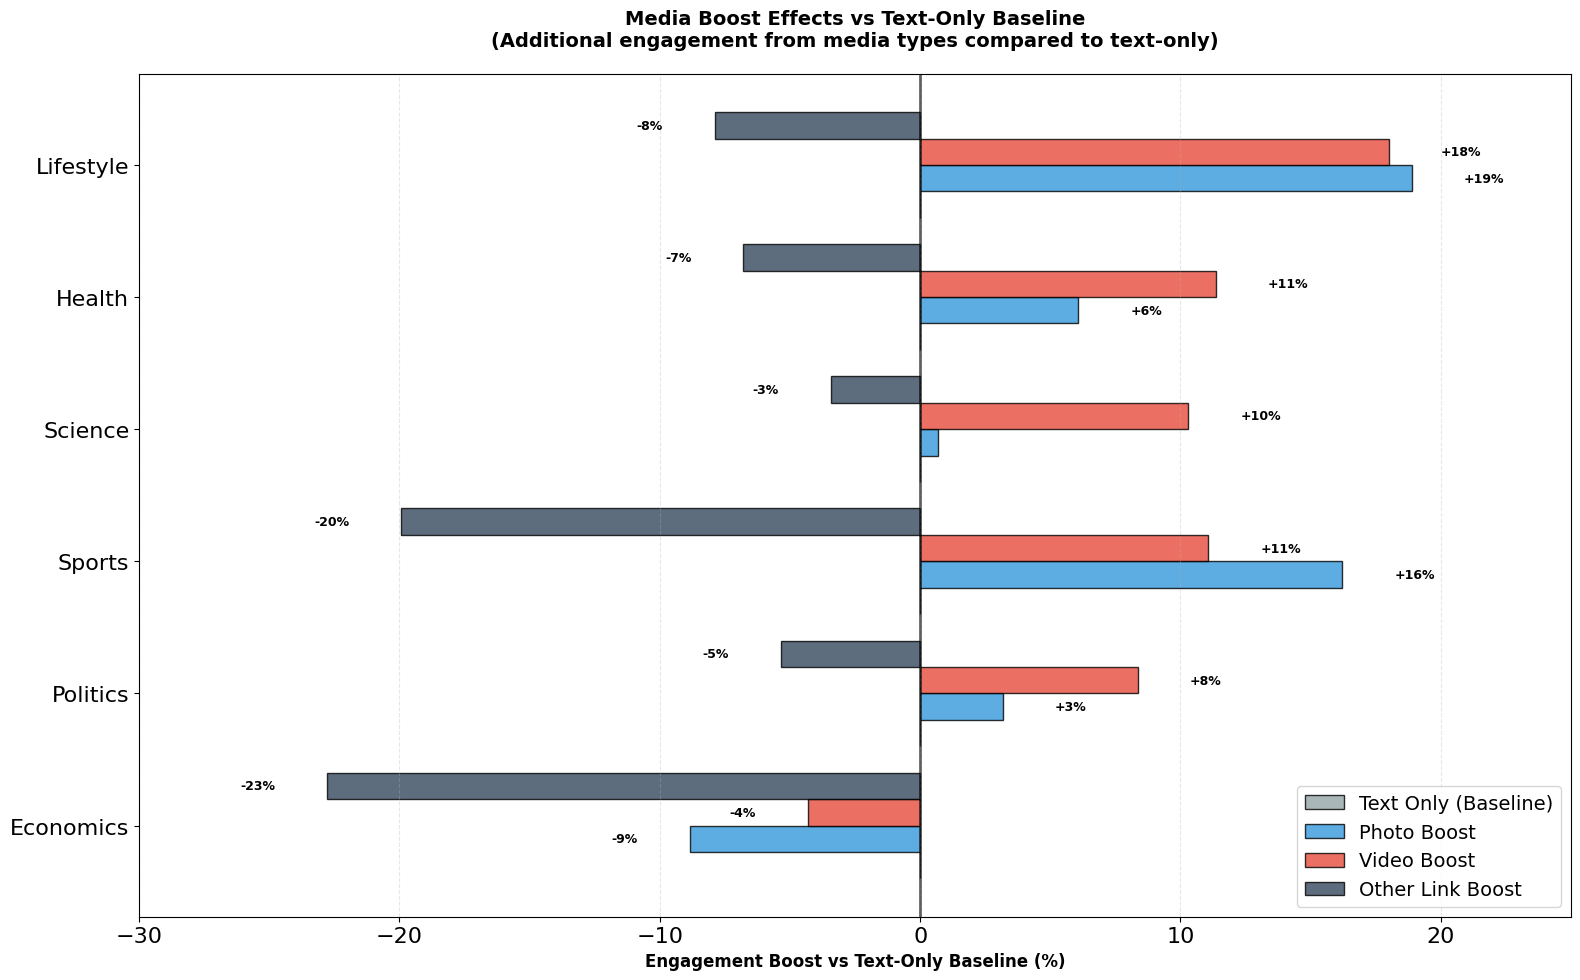

✓ Topic-media interaction analysis completed successfully


In [60]:
# Topic-media interaction effects analysis
if 'predicted_classification' in df.columns and 'media_type' in df.columns:
    
    print("\n" + "="*70)
    print("TOPIC-MEDIA INTERACTION EFFECTS ANALYSIS")
    print("="*70)
    
    # Prepare data
    ENGAGEMENT_METRICS = ['retweet_count', 'favorite_count', 'reply_count', 'quote_count']
    available_metrics = [col for col in ENGAGEMENT_METRICS if col in df.columns]
    
    if available_metrics:
        unknown_topics = ['unknown', 'other', 'unclear']
        df_interaction = df[~df['predicted_classification'].isin(unknown_topics)].copy()
        df_interaction = df_interaction[df_interaction[available_metrics].notna().any(axis=1)].copy()
        
        # Calculate overall dataset mean for baseline approach
        overall_means = df_interaction[available_metrics].mean()
        overall_mean_combined = overall_means.mean()
        
        topics = ['economics', 'politics', 'sports', 'science', 'health', 'lifestyle']
        media_types = ['text only', 'photo', 'video', 'other link']
        
        print(f"✓ Analyzing interaction effects for {len(df_interaction):,} tweets")
        print(f"✓ Topics: {len([t for t in topics if t in df_interaction['predicted_classification'].values])}")
        print(f"✓ Media types: {len([m for m in media_types if m in df_interaction['media_type'].values])}")
        
        # Calculate text-baseline interaction effects
        interaction_data = {}
        
        for topic in topics:
            if topic not in df_interaction['predicted_classification'].values:
                continue
            
            # Get all data for this topic
            topic_data = df_interaction[df_interaction['predicted_classification'] == topic]
            
            # Calculate text-only baseline for this topic
            text_only_data = topic_data[topic_data['media_type'] == 'text only']
            if len(text_only_data) >= 10:
                text_only_performance = text_only_data[available_metrics].median().mean()
                text_baseline_perf = ((text_only_performance / overall_mean_combined) - 1) * 100
            else:
                text_baseline_perf = 0
                text_only_performance = overall_mean_combined
            
            interaction_data[topic] = {}
            
            for media in media_types:
                media_data = topic_data[topic_data['media_type'] == media]
                
                if len(media_data) >= 10:
                    media_performance = media_data[available_metrics].median().mean()
                    
                    if media == 'text only':
                        interaction_data[topic][media] = 0  # Text is baseline
                    else:
                        media_vs_overall = ((media_performance / overall_mean_combined) - 1) * 100
                        interaction_data[topic][media] = media_vs_overall - text_baseline_perf
                else:
                    interaction_data[topic][media] = None
        
        # Filter out topics with insufficient data
        valid_topics = [topic for topic in interaction_data.keys() 
                       if any(v is not None for v in interaction_data[topic].values())]
        
        print(f"\nInteraction Effects Summary:")
        for topic in valid_topics:
            effects = [f"{media}: {interaction_data[topic][media]:+.1f}%" 
                      for media in media_types[1:] 
                      if interaction_data[topic][media] is not None]
            print(f"  {format_column_name(topic)}: {', '.join(effects)}")
        
        # Create interaction effects visualization
        if valid_topics:
            plt.figure(figsize=(16, 10))
            
            # Extract data for plotting
            text_only_effects = [interaction_data[topic].get('text only', 0) for topic in valid_topics]
            photo_effects = [interaction_data[topic].get('photo', 0) if interaction_data[topic].get('photo') is not None else 0 for topic in valid_topics]
            video_effects = [interaction_data[topic].get('video', 0) if interaction_data[topic].get('video') is not None else 0 for topic in valid_topics]
            link_effects = [interaction_data[topic].get('other link', 0) if interaction_data[topic].get('other link') is not None else 0 for topic in valid_topics]
            
            y_pos = np.arange(len(valid_topics))
            bar_height = 0.2
            
            # Create horizontal bars
            bars1 = plt.barh(y_pos - 1.5*bar_height, text_only_effects, bar_height, 
                             label='Text Only (Baseline)', color='#95a5a6', alpha=0.8, edgecolor='black')
            bars2 = plt.barh(y_pos - 0.5*bar_height, photo_effects, bar_height, 
                             label='Photo Boost', color='#3498db', alpha=0.8, edgecolor='black')
            bars3 = plt.barh(y_pos + 0.5*bar_height, video_effects, bar_height,
                             label='Video Boost', color='#e74c3c', alpha=0.8, edgecolor='black')
            bars4 = plt.barh(y_pos + 1.5*bar_height, link_effects, bar_height,
                             label='Other Link Boost', color='#34495e', alpha=0.8, edgecolor='black')
            
            # Add zero reference line
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.6, linewidth=2)
            
            # Customize chart
            plt.yticks(y_pos, [format_column_name(topic) for topic in valid_topics])
            plt.xlabel('Engagement Boost vs Text-Only Baseline (%)', fontweight='bold', fontsize=12)
            plt.title('Media Boost Effects vs Text-Only Baseline\n(Additional engagement from media types compared to text-only)', 
                      fontweight='bold', fontsize=14, pad=20)
            
            # Add value labels for significant effects
            for i, (photo_val, video_val, link_val) in enumerate(zip(photo_effects, video_effects, link_effects)):
                if abs(photo_val) > 3:
                    x_pos = photo_val + (2 if photo_val > 0 else -2)
                    ha = 'left' if photo_val > 0 else 'right'
                    plt.text(x_pos, y_pos[i] - 0.5*bar_height, f'{photo_val:+.0f}%',
                            ha=ha, va='center', fontweight='bold', fontsize=9)
                if abs(video_val) > 3:
                    x_pos = video_val + (2 if video_val > 0 else -2)
                    ha = 'left' if video_val > 0 else 'right'
                    plt.text(x_pos, y_pos[i] + 0.5*bar_height, f'{video_val:+.0f}%',
                            ha=ha, va='center', fontweight='bold', fontsize=9)
                if abs(link_val) > 3:
                    x_pos = link_val + (2 if link_val > 0 else -2)
                    ha = 'left' if link_val > 0 else 'right'
                    plt.text(x_pos, y_pos[i] + 1.5*bar_height, f'{link_val:.0f}%',
                            ha=ha, va='center', fontweight='bold', fontsize=9)
            
            plt.legend(loc='lower right')
            plt.grid(axis='x', alpha=0.3, linestyle='--')
            plt.xlim(-30, 25)
            plt.tight_layout()
            save_current_plot('block15', 'media_effect_vs_text')
            plt.show()
            
            print("✓ Topic-media interaction analysis completed successfully")
        else:
            print("❌ Insufficient data for interaction analysis")
    else:
        print("❌ No engagement metrics found in dataset")
else:
    print("❌ Required columns not found in dataset")

## Fact-Check Links Analysis by Topic
Analyzes the distribution of fact-check links across topic categories.


FACT-CHECK LINKS ANALYSIS BY TOPIC
✓ Analyzing 21,630 tweets across 6 topics

Fact-Check Links by Topic:
  Health: 29.9% (495/1,656 tweets)
  Science: 26.1% (573/2,195 tweets)
  Politics: 14.0% (1,172/8,382 tweets)
  Economics: 10.5% (109/1,041 tweets)
  Lifestyle: 9.6% (678/7,097 tweets)
  Sports: 1.8% (23/1,259 tweets)

Overall: 14.1% of tweets contain fact-check links (3,050/21,630)


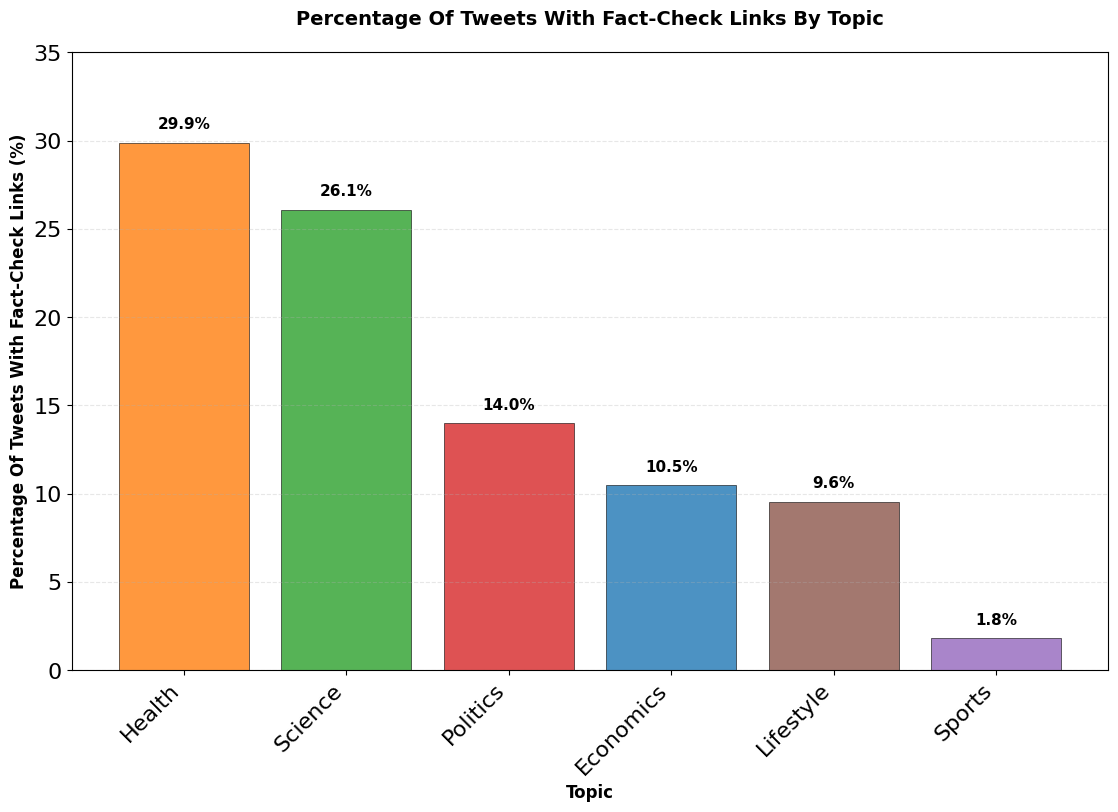

✓ Fact-check links analysis completed successfully


In [ ]:
# Fact-check links analysis by topic
if 'predicted_classification' in df.columns and 'has_fact_check_link' in df.columns:
    
    print("\n" + "="*60)
    print("FACT-CHECK LINKS ANALYSIS BY TOPIC")
    print("="*60)
    
    # Create subset excluding unknown topics
    unknown_topics = ['unknown', 'other', 'unclear']
    df_factcheck = df[~df['predicted_classification'].isin(unknown_topics)].copy()
    
    if not df_factcheck.empty:
        print(f"✓ Analyzing {len(df_factcheck):,} tweets across {df_factcheck['predicted_classification'].nunique()} topics")
        
        # Ensure has_fact_check_link is treated as boolean
        df_factcheck['has_fact_check_link_clean'] = df_factcheck['has_fact_check_link'].fillna(False)
        
        # Calculate fact-check link statistics by topic
        factcheck_stats = df_factcheck.groupby('predicted_classification')['has_fact_check_link_clean'].agg([
            'sum',    # Number with fact-check links
            'count',  # Total tweets
            'mean'    # Percentage
        ]).round(4)
        
        factcheck_stats['percentage'] = factcheck_stats['mean'] * 100
        factcheck_stats = factcheck_stats.sort_values('percentage', ascending=False)
        
        print(f"\nFact-Check Links by Topic:")
        for topic, stats in factcheck_stats.iterrows():
            print(f"  {format_column_name(topic)}: {stats['percentage']:.1f}% ({int(stats['sum']):,}/{int(stats['count']):,} tweets)")
        
        # Overall statistics
        total_with_factcheck = int(factcheck_stats['sum'].sum())
        total_tweets = int(factcheck_stats['count'].sum())
        overall_percentage = (total_with_factcheck / total_tweets) * 100
        print(f"\nOverall: {overall_percentage:.1f}% of tweets contain fact-check links ({total_with_factcheck:,}/{total_tweets:,})")
        
        # Create fact-check links visualization
        plt.figure(figsize=(12, 8))
        
        # Get consistent colors for topics
        colors = get_color_palette(factcheck_stats.index, TOPIC_COLORS)
        
        # Create bar chart showing percentage with fact-check links
        bars = plt.bar(range(len(factcheck_stats)), factcheck_stats['percentage'].values,
                       color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Customize chart
        plt.title('Percentage Of Tweets With Fact-Check Links By Topic', 
                  fontweight='bold', pad=20, fontsize=14)
        plt.ylabel('Percentage Of Tweets With Fact-Check Links (%)', fontweight='bold', fontsize=12)
        plt.xlabel('Topic', fontweight='bold', fontsize=12)
        
        # Format x-axis labels
        formatted_topics = [format_column_name(topic) for topic in factcheck_stats.index]
        plt.xticks(range(len(factcheck_stats)), formatted_topics, rotation=45, ha='right')
        
        # Add percentage labels on bars
        for i, (bar, value) in enumerate(zip(bars, factcheck_stats['percentage'].values)):
            plt.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_height() + max(factcheck_stats['percentage']) * 0.02,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add grid for readability
        plt.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Set Y-axis range for better visual spacing
        plt.ylim(0, 35)
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15, left=0.12)  # Extra space for labels
        
        save_current_plot('block16', 'has_fact_check_link_percentage_by_topic')
        plt.show()
        
        print("✓ Fact-check links analysis completed successfully")
    else:
        print("❌ No data available for fact-check analysis after excluding unknown topics")
else:
    missing_cols = []
    if 'predicted_classification' not in df.columns:
        missing_cols.append('predicted_classification')
    if 'has_fact_check_link' not in df.columns:
        missing_cols.append('has_fact_check_link')
    print(f"❌ Required columns not found: {missing_cols}")

## N-gram Analysis with Sentiment Integration
Conducts TF-IDF analysis combined with VADER sentiment analysis to identify distinctive terms for each topic.  
Extracts top unigrams and high-scoring bigrams/trigrams with their associated sentiment scores for thesis reference.

In [72]:
# N-gram analysis with sentiment integration
if 'predicted_classification' in df.columns and 'full_text' in df.columns:
    
    print("\n" + "="*60)
    print("N-GRAM ANALYSIS WITH SENTIMENT INTEGRATION")
    print("="*60)
    
    try:
        from sklearn.feature_extraction.text import TfidfVectorizer
        import nltk
        
        # Try to download required NLTK data
        try:
            nltk.download('stopwords', quiet=True)
            nltk.download('vader_lexicon', quiet=True)
            from nltk.corpus import stopwords
            from nltk.sentiment.vader import SentimentIntensityAnalyzer
            sid = SentimentIntensityAnalyzer()
            nltk_available = True
            sentiment_available = True
            print("✓ NLTK libraries loaded successfully")
        except:
            nltk_available = False
            sentiment_available = False
            print("⚠️  NLTK not available - using basic stopwords, no sentiment analysis")
        
        # Prepare data - exclude unknown topics and ensure text quality
        df_ngram = df[
            (df['predicted_classification'] != 'unknown') & 
            (df['full_text'].notna()) & 
            (df['full_text'].str.len() > 10)
        ].copy()
        
        print(f"✓ Analyzing {len(df_ngram):,} tweets for n-gram patterns")
        
        # Clean and preprocess text
        def preprocess_text(text):
            """Clean text for n-gram analysis"""
            if pd.isna(text):
                return ""
            
            text = str(text).lower()
            
            # Remove URLs and mentions but keep hashtags
            text = re.sub(r'https?://[^\s]+|www\.[^\s]+|t\.co/[^\s]+', '', text)
            text = re.sub(r'@[^\s]+', '', text)
            
            # Remove special characters but keep spaces and hashtags
            text = re.sub(r'[^\w\s#]', ' ', text)
            
            # Remove extra whitespace
            text = ' '.join(text.split())
            
            return text
        
        df_ngram['clean_text'] = df_ngram['full_text'].apply(preprocess_text)
        
        # Calculate sentiment scores if available
        if sentiment_available:
            df_ngram['sentiment_score'] = df_ngram['full_text'].apply(
                lambda x: sid.polarity_scores(str(x))['compound']
            )
            print("✓ Sentiment scores calculated")
        
        # Filter out empty texts after cleaning
        df_ngram = df_ngram[df_ngram['clean_text'].str.len() > 5]
        
        # Define stopwords
        if nltk_available:
            stop_words = set(stopwords.words('english'))
        else:
            stop_words = set([
                'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
                'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
                'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
                'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                'while', 'of', 'at', 'by', 'for', 'with', 'through', 'during', 'before', 'after',
                'above', 'below', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
                'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
                'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor',
                'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will',
                'just', 'don', 'should', 'now', 'get', 'go', 'would', 'could', 'get', 'one'
            ])
        
        # Add social media specific stopwords
        social_media_stops = {'rt', 'via', 'amp', 'like', 'see', 'know', 'think', 'say', 
                             'said', 'new', 'time', 'today', 'way', 'make', 'take', 'us', 'people',
                             'https', 'http', 'com', 'www', 'co', 'want', 'need', 'much', 'many',
                             'back', 'still', 'also', 'even', 'really', 'never', 'always', 'well'}
        stop_words.update(social_media_stops)
        stop_words_list = list(stop_words)
        
        # Get topic distribution and filter topics with sufficient data
        topic_counts = df_ngram['predicted_classification'].value_counts()
        topics_to_analyze = topic_counts[topic_counts >= 50].index.tolist()
        
        print(f"✓ Topics for analysis: {len(topics_to_analyze)}")
        
        # Function to calculate n-gram sentiment
        def calculate_ngram_sentiment(ngram_term, topic_data, clean_texts):
            """Calculate mean sentiment for tweets containing this n-gram"""
            if not sentiment_available:
                return None
            
            sentiments = []
            for i, clean_text in enumerate(clean_texts):
                if ngram_term in clean_text:
                    sentiments.append(topic_data.iloc[i]['sentiment_score'])
            
            return np.mean(sentiments) if sentiments else None
        
        # Store results for thesis table
        thesis_results = {}
        vaccines_autism_analysis = None
        
        # Process each topic
        for topic in topics_to_analyze:
            topic_data = df_ngram[df_ngram['predicted_classification'] == topic]
            topic_texts = topic_data['clean_text'].tolist()
            topic_count = len(topic_texts)
            
            # Unified parameters for consistent analysis
            unified_params = {
                'max_features': min(150, topic_count),
                'min_df': max(2, int(topic_count * 0.005)),
                'max_df': 0.6,
                'stop_words': stop_words_list,
                'lowercase': True
            }
            
            topic_results = {'topic_name': topic, 'sample_size': topic_count}
            
            # UNIGRAM ANALYSIS
            try:
                tfidf_1gram = TfidfVectorizer(ngram_range=(1, 1), **unified_params)
                tfidf_matrix_1gram = tfidf_1gram.fit_transform(topic_texts)
                feature_names_1gram = tfidf_1gram.get_feature_names_out()
                mean_scores_1gram = tfidf_matrix_1gram.mean(axis=0).A1
                
                top_unigrams = [(feature_names_1gram[i], mean_scores_1gram[i]) 
                               for i in mean_scores_1gram.argsort()[-15:][::-1]]
                
                # Add sentiment scores
                unigrams_with_sentiment = []
                for term, tfidf_score in top_unigrams:
                    sentiment = calculate_ngram_sentiment(term, topic_data, topic_texts)
                    unigrams_with_sentiment.append((term, tfidf_score, sentiment))
                
                topic_results['unigrams'] = unigrams_with_sentiment
                
            except ValueError:
                topic_results['unigrams'] = []
            
            # BIGRAM ANALYSIS
            try:
                tfidf_2gram = TfidfVectorizer(ngram_range=(2, 2), **unified_params)
                tfidf_matrix_2gram = tfidf_2gram.fit_transform(topic_texts)
                feature_names_2gram = tfidf_2gram.get_feature_names_out()
                mean_scores_2gram = tfidf_matrix_2gram.mean(axis=0).A1
                
                top_bigrams = [(feature_names_2gram[i], mean_scores_2gram[i]) 
                              for i in mean_scores_2gram.argsort()[-15:][::-1]]
                
                # Add sentiment scores
                bigrams_with_sentiment = []
                for term, tfidf_score in top_bigrams:
                    sentiment = calculate_ngram_sentiment(term, topic_data, topic_texts)
                    bigrams_with_sentiment.append((term, tfidf_score, sentiment))
                
                topic_results['bigrams'] = bigrams_with_sentiment
                
            except ValueError:
                topic_results['bigrams'] = []
            
            # TRIGRAM ANALYSIS
            try:
                tfidf_3gram = TfidfVectorizer(ngram_range=(3, 3), **unified_params)
                tfidf_matrix_3gram = tfidf_3gram.fit_transform(topic_texts)
                feature_names_3gram = tfidf_3gram.get_feature_names_out()
                mean_scores_3gram = tfidf_matrix_3gram.mean(axis=0).A1
                
                top_trigrams = [(feature_names_3gram[i], mean_scores_3gram[i]) 
                               for i in mean_scores_3gram.argsort()[-15:][::-1]]
                
                # Add sentiment scores
                trigrams_with_sentiment = []
                for term, tfidf_score in top_trigrams:
                    sentiment = calculate_ngram_sentiment(term, topic_data, topic_texts)
                    trigrams_with_sentiment.append((term, tfidf_score, sentiment))
                
                topic_results['trigrams'] = trigrams_with_sentiment
                
                # Special analysis for "vaccines cause autism"
                if any("vaccines cause autism" in term for term, score, sent in trigrams_with_sentiment):
                    if sentiment_available:
                        autism_tweets = []
                        for i, clean_text in enumerate(topic_texts):
                            if "vaccines cause autism" in clean_text:
                                original_text = topic_data.iloc[i]['full_text']
                                sentiment_score = topic_data.iloc[i]['sentiment_score']
                                autism_tweets.append((original_text, sentiment_score))
                        
                        if autism_tweets:
                            vaccines_autism_analysis = {
                                'total_tweets': len(autism_tweets),
                                'percentage_of_topic': (len(autism_tweets) / topic_count) * 100,
                                'tfidf_score': next((score for term, score, sent in trigrams_with_sentiment 
                                                   if "vaccines cause autism" in term), None),
                                'mean_sentiment': sum(x[1] for x in autism_tweets) / len(autism_tweets),
                                'sentiment_range': (min(x[1] for x in autism_tweets), max(x[1] for x in autism_tweets)),
                                'sentiment_std': np.std([x[1] for x in autism_tweets]),
                                'sorted_tweets': sorted(autism_tweets, key=lambda x: x[1])
                            }
                
            except ValueError:
                topic_results['trigrams'] = []
            
            thesis_results[topic] = topic_results
        
        # Save results to text file
        output_file = f"{ANALYSIS_DIR}/ngram_analysis_results.txt"
        os.makedirs(ANALYSIS_DIR, exist_ok=True)
        
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write("N-GRAM ANALYSIS WITH SENTIMENT INTEGRATION\n")
            f.write("=" * 60 + "\n")
            f.write("Results for thesis Table: Top Unigrams and High-TF-IDF Bigrams/Trigrams\n\n")
            
            f.write("DATASET SUMMARY\n")
            f.write("-" * 30 + "\n")
            total_tweets = sum(results['sample_size'] for results in thesis_results.values())
            f.write(f"Total tweets analyzed: {total_tweets:,}\n")
            f.write(f"Number of topics: {len(thesis_results)}\n")
            f.write(f"Methodology: TF-IDF + VADER sentiment analysis\n")
            f.write(f"Criteria: Top 3 unigrams + bigrams/trigrams with TF-IDF > 0.02\n\n")
            
            # Write results for thesis table
            f.write("THESIS TABLE DATA\n")
            f.write("=" * 60 + "\n")
            f.write("Format: Topic | N-gram | TF-IDF | Sentiment\n")
            f.write("-" * 60 + "\n")
            
            for topic, results in thesis_results.items():
                f.write(f"\n{format_column_name(topic).upper()}\n")
                f.write("-" * 30 + "\n")
                f.write(f"Sample size: {results['sample_size']:,} tweets\n\n")
                
                # Top 10 unigrams
                if results['unigrams']:
                    f.write("Top 10 Unigrams:\n")
                    for i, (term, tfidf, sentiment) in enumerate(results['unigrams'][:10], 1):
                        sentiment_str = f"{sentiment:+.3f}" if sentiment is not None else "N/A"
                        f.write(f"  {i}. {term:<15} | TF-IDF: {tfidf:.4f} | Sentiment: {sentiment_str}\n")
                    f.write("\n")
                
                # High-scoring bigrams (> 0.02)
                high_bigrams = [(term, tfidf, sent) for term, tfidf, sent in results.get('bigrams', []) if tfidf > 0.02]
                if high_bigrams:
                    f.write("Bigrams with TF-IDF > 0.02:\n")
                    for term, tfidf, sentiment in high_bigrams:
                        sentiment_str = f"{sentiment:+.3f}" if sentiment is not None else "N/A"
                        f.write(f"  • {term:<20} | TF-IDF: {tfidf:.4f} | Sentiment: {sentiment_str}\n")
                    f.write("\n")
                
                # High-scoring trigrams (> 0.02)
                high_trigrams = [(term, tfidf, sent) for term, tfidf, sent in results.get('trigrams', []) if tfidf > 0.02]
                if high_trigrams:
                    f.write("Trigrams with TF-IDF > 0.02:\n")
                    for term, tfidf, sentiment in high_trigrams:
                        sentiment_str = f"{sentiment:+.3f}" if sentiment is not None else "N/A"
                        f.write(f"  • {term:<25} | TF-IDF: {tfidf:.4f} | Sentiment: {sentiment_str}\n")
                    f.write("\n")
            
            # Special analysis for "vaccines cause autism"
            if vaccines_autism_analysis:
                f.write("\n" + "=" * 60 + "\n")
                f.write("SPECIAL ANALYSIS: 'VACCINES CAUSE AUTISM'\n")
                f.write("=" * 60 + "\n")
                f.write(f"Total occurrences: {vaccines_autism_analysis['total_tweets']} tweets\n")
                f.write(f"Percentage of Health topic: {vaccines_autism_analysis['percentage_of_topic']:.1f}%\n")
                f.write(f"TF-IDF score: {vaccines_autism_analysis['tfidf_score']:.4f}\n")
                f.write(f"Mean sentiment: {vaccines_autism_analysis['mean_sentiment']:+.3f}\n")
                f.write(f"Sentiment range: {vaccines_autism_analysis['sentiment_range'][0]:+.3f} to {vaccines_autism_analysis['sentiment_range'][1]:+.3f}\n")
                f.write(f"Sentiment std dev: {vaccines_autism_analysis['sentiment_std']:.3f}\n\n")
                
                # Example tweets by sentiment
                sorted_tweets = vaccines_autism_analysis['sorted_tweets']
                
                f.write("MOST NEGATIVE EXAMPLES (Top 10):\n")
                for i, (tweet, sentiment) in enumerate(sorted_tweets[:10], 1):
                    f.write(f"{i}. ({sentiment:+.3f}) {tweet[:120]}{'...' if len(tweet) > 120 else ''}\n")
                
                f.write("\nMOST NEUTRAL EXAMPLE:\n")
                neutral_tweet = min(sorted_tweets, key=lambda x: abs(x[1]))
                f.write(f"1. ({neutral_tweet[1]:+.3f}) {neutral_tweet[0][:120]}{'...' if len(neutral_tweet[0]) > 120 else ''}\n")
                
                f.write("\nMOST POSITIVE EXAMPLES (Top 10):\n")
                for i, (tweet, sentiment) in enumerate(sorted_tweets[-10:], 1):
                    f.write(f"{i}. ({sentiment:+.3f}) {tweet[:120]}{'...' if len(tweet) > 120 else ''}\n")
            
            f.write(f"\n\nAnalysis completed: {len(thesis_results)} topics processed\n")
            f.write("File generated for thesis reference\n")
        
        print(f"✓ N-gram analysis completed")
        print(f"✓ Results saved to: {output_file}")
        print(f"✓ Processed {len(thesis_results)} topics")
        if vaccines_autism_analysis:
            print(f"✓ Special 'vaccines cause autism' analysis included")
        
    except ImportError as e:
        print(f"❌ Required libraries not available: {e}")
    except Exception as e:
        print(f"❌ Error in n-gram analysis: {e}")
else:
    missing_cols = []
    if 'predicted_classification' not in df.columns:
        missing_cols.append('predicted_classification')
    if 'full_text' not in df.columns:
        missing_cols.append('full_text')
    print(f"❌ Required columns not found: {missing_cols}")


N-GRAM ANALYSIS WITH SENTIMENT INTEGRATION
✓ NLTK libraries loaded successfully
✓ Analyzing 21,617 tweets for n-gram patterns
✓ Sentiment scores calculated
✓ Topics for analysis: 6
✓ N-gram analysis completed
✓ Results saved to: analysis_results/ngram_analysis_results.txt
✓ Processed 6 topics
✓ Special 'vaccines cause autism' analysis included


## N-gram Confidence Boosters Analysis
Analyzes which n-grams (unigrams, bigrams, trigrams) increase model confidence in topic classification.  
Uses two-phase analysis: overall TF-IDF extraction followed by topic-specific confidence impact assessment to identify terms that help the BART-MNLI model make more confident predictions.


N-GRAM CONFIDENCE BOOSTERS ANALYSIS
✓ Required libraries loaded successfully
✓ Reusing preprocessed data from previous analysis
✓ Analyzing 20,621 tweets for n-gram confidence patterns

📊 CONFIDENCE SCORE OVERVIEW:
Mean confidence: 0.995
Median confidence: 1.000
Range: 0.900 - 1.000
✓ Using comprehensive stopwords for better topic distinctiveness
✓ Topics for analysis: 6 topics with ≥50 tweets
  Politics: 8,171 tweets (avg confidence: 0.995)
  Lifestyle: 6,679 tweets (avg confidence: 0.995)
  Science: 2,048 tweets (avg confidence: 0.994)
  Health: 1,503 tweets (avg confidence: 0.992)
  Sports: 1,212 tweets (avg confidence: 0.994)
  Economics: 1,008 tweets (avg confidence: 0.990)

EXTRACTING TOPIC-DISTINCTIVE N-GRAMS
🔤 Analyzing n-gram confidence impact...
✓ Analyzed 300 n-grams for confidence impact

CREATING 2x3 GRID CONFIDENCE BOOSTERS VISUALIZATION
✓ Topic order for grid: ['Politics', 'Lifestyle', 'Science', 'Health', 'Sports', 'Economics']
Creating panel 1/6: Politics
  ✓ Politics

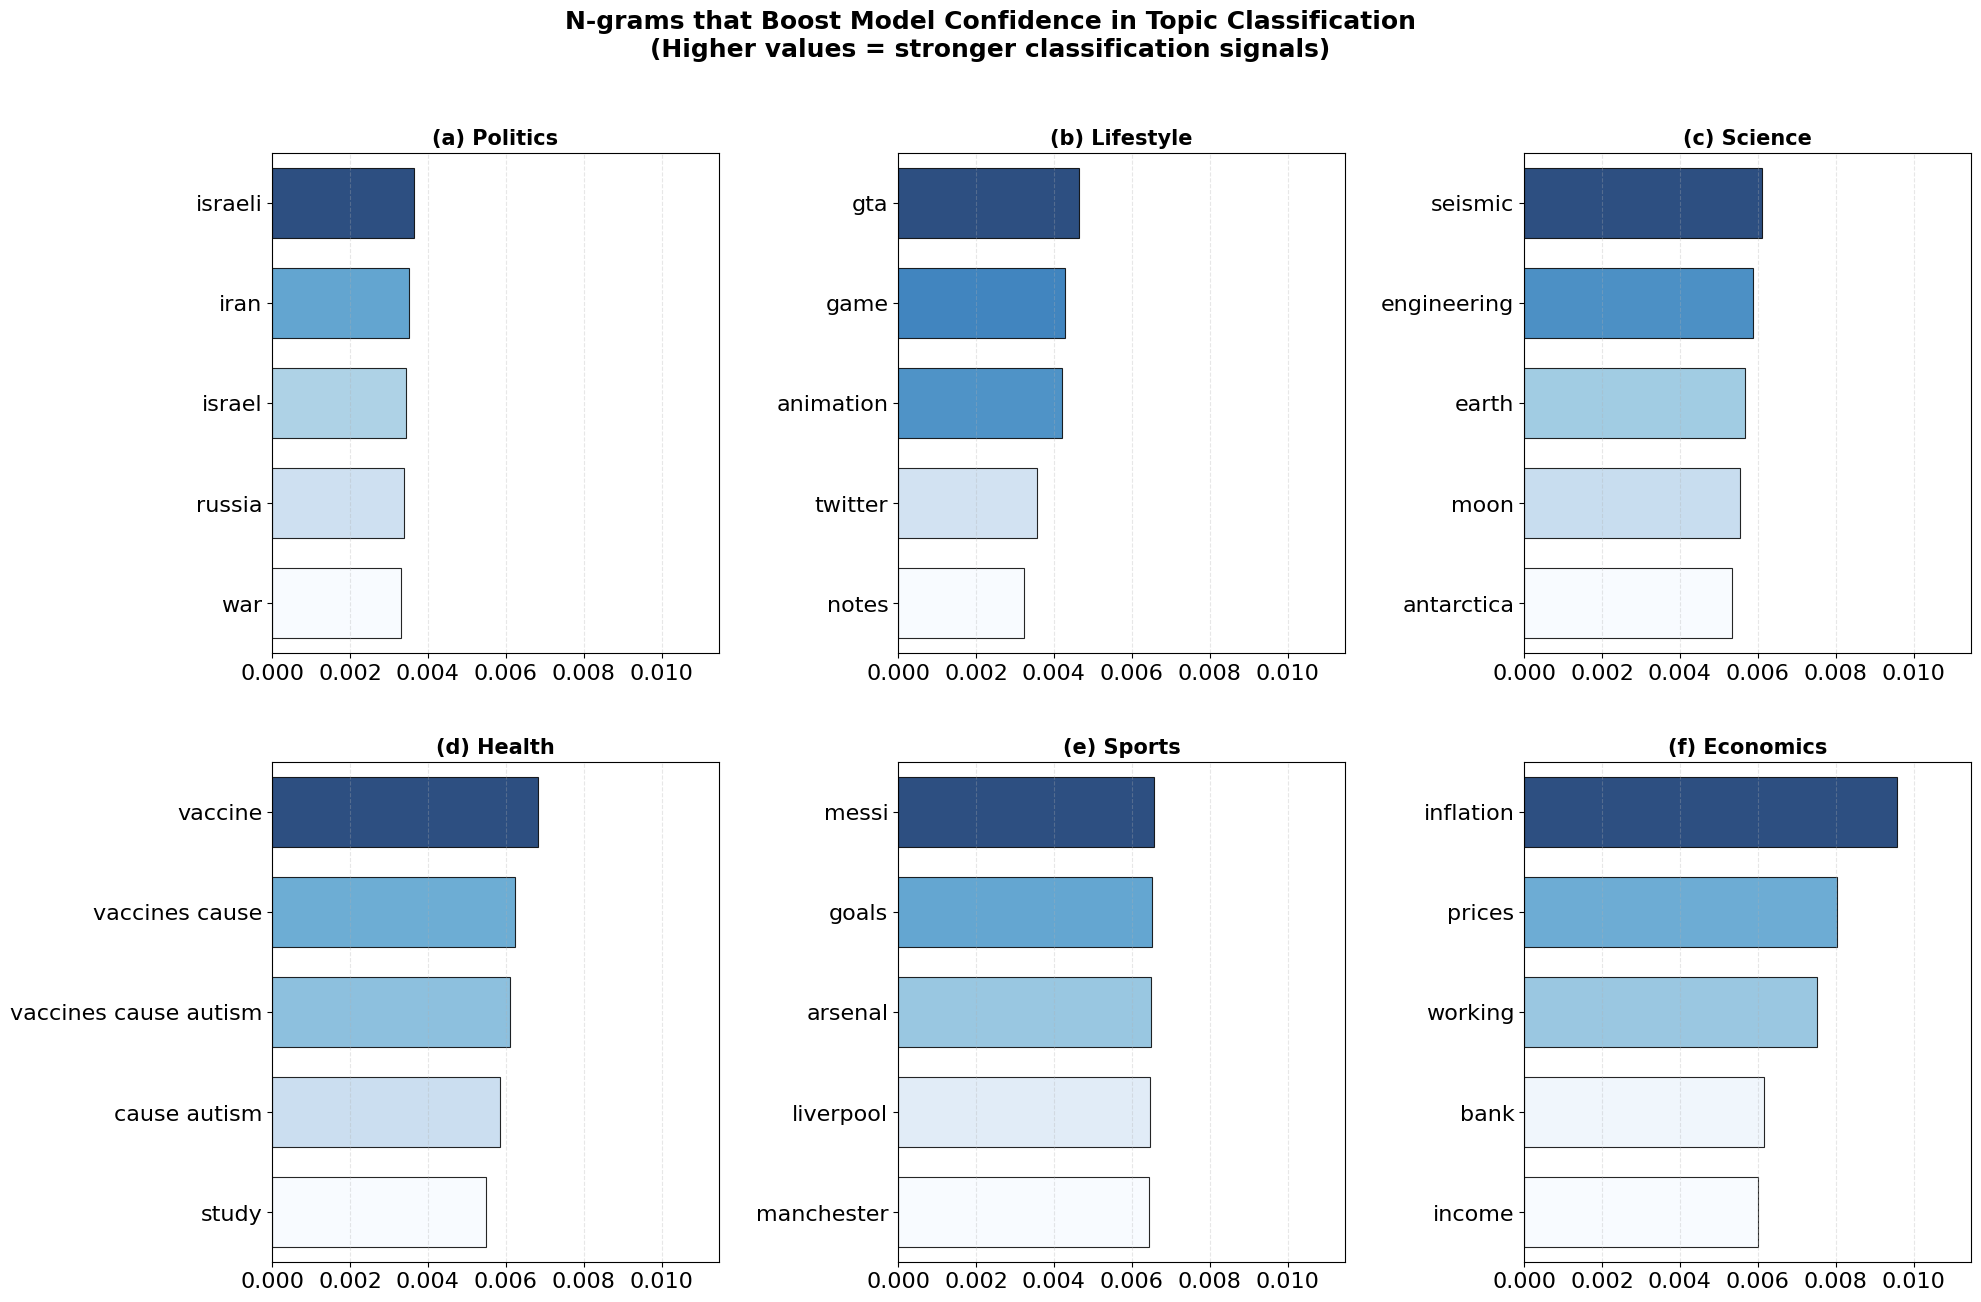

✓ N-gram confidence boosters analysis completed successfully
✓ 2x3 grid visualization created with descending order and local color gradients


In [ ]:
# N-gram confidence boosters analysis
if 'predicted_classification' in df.columns and 'prediction_confidence' in df.columns and 'full_text' in df.columns:
    
    print("\n" + "="*60)
    print("N-GRAM CONFIDENCE BOOSTERS ANALYSIS")
    print("="*60)
    
    try:
        from scipy import stats
        from sklearn.feature_extraction.text import TfidfVectorizer
        import matplotlib.colors as mcolors
        
        print("✓ Required libraries loaded successfully")
        
        # Reuse preprocessing from Block 17 if available, otherwise create fresh
        if 'df_ngram' in locals():
            print("✓ Reusing preprocessed data from previous analysis")
            df_confidence = df_ngram[df_ngram['prediction_confidence'].notna() & (df_ngram['prediction_confidence'] > 0)].copy()
        else:
            print("🧹 Creating fresh preprocessed data...")
            # Prepare data - exclude unknown topics and ensure data quality
            df_confidence = df[
                (df['predicted_classification'] != 'unknown') & 
                (df['full_text'].notna()) & 
                (df['prediction_confidence'].notna()) & 
                (df['full_text'].str.len() > 10) &
                (df['prediction_confidence'] > 0)
            ].copy()
            
            # Clean and preprocess text
            def preprocess_text(text):
                if pd.isna(text):
                    return ""
                text = str(text).lower()
                text = re.sub(r'https?://[^\s]+|www\.[^\s]+|t\.co/[^\s]+', '', text)
                text = re.sub(r'@[^\s]+', '', text)
                text = re.sub(r'[^\w\s#]', ' ', text)
                text = ' '.join(text.split())
                return text
            
            df_confidence['clean_text'] = df_confidence['full_text'].apply(preprocess_text)
            df_confidence = df_confidence[df_confidence['clean_text'].str.len() > 5]
        
        print(f"✓ Analyzing {len(df_confidence):,} tweets for n-gram confidence patterns")
        
        # Get basic confidence statistics
        print(f"\n📊 CONFIDENCE SCORE OVERVIEW:")
        print(f"Mean confidence: {df_confidence['prediction_confidence'].mean():.3f}")
        print(f"Median confidence: {df_confidence['prediction_confidence'].median():.3f}")
        print(f"Range: {df_confidence['prediction_confidence'].min():.3f} - {df_confidence['prediction_confidence'].max():.3f}")
        
        # Define stopwords (from your working code)
        try:
            import nltk
            nltk.download('stopwords', quiet=True)
            from nltk.corpus import stopwords
            stop_words = set(stopwords.words('english'))
            nltk_available = True
        except:
            stop_words = set([
                'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
                'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
                'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
                'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                'while', 'of', 'at', 'by', 'for', 'with', 'through', 'during', 'before', 'after',
                'above', 'below', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
                'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
                'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor',
                'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will',
                'just', 'don', 'should', 'now', 'get', 'go', 'would', 'could'
            ])
            nltk_available = False
        
        # Add social media specific stopwords
        social_media_stops = {'rt', 'via', 'amp', 'like', 'see', 'know', 'think', 'say', 
                             'said', 'new', 'time', 'today', 'way', 'make', 'take', 'us', 'people',
                             'https', 'http', 'com', 'www', 'co', 'want', 'need', 'much', 'many',
                             'back', 'still', 'also', 'even', 'really', 'never', 'always', 'well'}
        stop_words.update(social_media_stops)
        stop_words_list = list(stop_words)
        
        print("✓ Using comprehensive stopwords for better topic distinctiveness")
        
        # Get topics with sufficient data
        topic_counts = df_confidence['predicted_classification'].value_counts()
        topics_to_analyze = topic_counts[topic_counts >= 50].index.tolist()
        
        print(f"✓ Topics for analysis: {len(topics_to_analyze)} topics with ≥50 tweets")
        for topic in topics_to_analyze:
            count = topic_counts[topic]
            mean_conf = df_confidence[df_confidence['predicted_classification'] == topic]['prediction_confidence'].mean()
            print(f"  {format_column_name(topic)}: {count:,} tweets (avg confidence: {mean_conf:.3f})")
        
        # Function to analyze confidence impact of n-grams
        def analyze_ngram_confidence_impact(ngram_term, df_data):
            """Analyze confidence difference for tweets with/without specific n-gram"""
            # Handle multi-word n-grams by creating appropriate regex pattern
            if ' ' in ngram_term:
                pattern = r'\b' + re.escape(ngram_term) + r'\b'
            else:
                pattern = r'\b' + re.escape(ngram_term) + r'\b'
            
            contains_ngram = df_data['clean_text'].str.contains(pattern, case=False, na=False)
            
            if contains_ngram.sum() < 2:  # Need at least 2 tweets
                return None
            
            confidence_with = df_data[contains_ngram]['prediction_confidence']
            confidence_without = df_data[~contains_ngram]['prediction_confidence']
            
            if len(confidence_with) == 0 or len(confidence_without) == 0:
                return None
            
            mean_with = confidence_with.mean()
            mean_without = confidence_without.mean()
            confidence_boost = mean_with - mean_without
            
            # Statistical significance test
            try:
                t_stat, p_value = stats.ttest_ind(confidence_with, confidence_without)
            except:
                t_stat, p_value = 0, 1
            
            return {
                'term': ngram_term,
                'mean_confidence_with': mean_with,
                'mean_confidence_without': mean_without,
                'confidence_boost': confidence_boost,
                'tweets_with_term': len(confidence_with),
                'tweets_without_term': len(confidence_without),
                'p_value': p_value,
                'significant': p_value < 0.05
            }
        
        # OVERALL ANALYSIS: Extract terms from all topics combined
        print(f"\n" + "="*60)
        print("EXTRACTING TOPIC-DISTINCTIVE N-GRAMS")
        print("="*60)
        
        # Create TF-IDF vectorizer with n-grams (1-3) - OVERALL ANALYSIS
        tfidf_ngrams = TfidfVectorizer(
            ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
            max_features=300,
            stop_words=stop_words_list,
            min_df=10,
            max_df=0.7,
            lowercase=True
        )
        
        # Fit on all texts
        tfidf_matrix_ngrams = tfidf_ngrams.fit_transform(df_confidence['clean_text'])
        feature_names_ngrams = tfidf_ngrams.get_feature_names_out()
        
        # Analyze all n-grams for confidence impact
        print("🔤 Analyzing n-gram confidence impact...")
        ngram_confidence_results = []
        
        for term in feature_names_ngrams:
            result = analyze_ngram_confidence_impact(term, df_confidence)
            if result is not None:
                ngram_confidence_results.append(result)
        
        # Sort by confidence boost
        ngram_confidence_results.sort(key=lambda x: x['confidence_boost'], reverse=True)
        
        print(f"✓ Analyzed {len(ngram_confidence_results)} n-grams for confidence impact")
        
        # TOPIC-SPECIFIC ANALYSIS FOR VISUALIZATION
        print(f"\n" + "="*60)
        print("CREATING 2x3 GRID CONFIDENCE BOOSTERS VISUALIZATION")
        print("="*60)
        
        # Define topic order to match original (modify as needed)
        desired_topic_order = ['politics', 'lifestyle', 'science', 'health', 'sports', 'economics']
        topics_for_grid = [topic for topic in desired_topic_order if topic in topics_to_analyze][:6]
        
        # Fill with remaining topics if needed
        remaining_topics = [topic for topic in topics_to_analyze if topic not in topics_for_grid]
        topics_for_grid.extend(remaining_topics[:6-len(topics_for_grid)])
        
        print(f"✓ Topic order for grid: {[format_column_name(topic) for topic in topics_for_grid]}")
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 14))
        fig.suptitle('N-grams that Boost Model Confidence in Topic Classification\n(Higher values = stronger classification signals)', 
                    fontweight='bold', fontsize=18, y=0.96)
        
        # Flatten axes for easier indexing
        axes_flat = axes.flatten()
        
        # First pass: collect all boost values to determine global x-axis range only
        all_boost_values = []
        topic_data_collection = {}
        
        for topic in topics_for_grid:
            topic_data = df_confidence[df_confidence['predicted_classification'] == topic].copy()
            topic_data_collection[topic] = topic_data
            
            if len(topic_data) >= 20:
                # Topic-specific TF-IDF to get relevant terms
                topic_tfidf = TfidfVectorizer(
                    ngram_range=(1, 3),
                    max_features=50,
                    stop_words=stop_words_list,
                    min_df=2,
                    max_df=0.8,
                    lowercase=True
                )
                try:
                    topic_matrix = topic_tfidf.fit_transform(topic_data['clean_text'])
                    topic_features = topic_tfidf.get_feature_names_out()
                    
                    for term in topic_features:
                        result = analyze_ngram_confidence_impact(term, topic_data)
                        if result is not None and result['tweets_with_term'] >= 3 and result['confidence_boost'] > 0:
                            all_boost_values.append(result['confidence_boost'])
                except:
                    continue
        
        # Determine global x-axis range only
        if all_boost_values:
            max_boost = max(all_boost_values)
            global_x_limit = max(0.010, max_boost * 1.2)
        else:
            global_x_limit = 0.010
        
        # Create subplot for each topic
        for i, topic in enumerate(topics_for_grid):
            ax = axes_flat[i]
            topic_data = topic_data_collection[topic]
            
            print(f"Creating panel {i+1}/6: {format_column_name(topic)}")
            
            if len(topic_data) >= 20:
                # Topic-specific TF-IDF to get relevant terms
                topic_tfidf = TfidfVectorizer(
                    ngram_range=(1, 3),
                    max_features=50,
                    stop_words=stop_words_list,
                    min_df=2,
                    max_df=0.8,
                    lowercase=True
                )
                
                try:
                    topic_matrix = topic_tfidf.fit_transform(topic_data['clean_text'])
                    topic_features = topic_tfidf.get_feature_names_out()
                    
                    # Analyze confidence impact for each term in this topic
                    topic_confidence_boosters = []
                    for term in topic_features:
                        result = analyze_ngram_confidence_impact(term, topic_data)
                        if result is not None and result['tweets_with_term'] >= 3 and result['confidence_boost'] > 0:
                            topic_confidence_boosters.append(result)
                    
                    # Sort by confidence boost (highest first)
                    topic_confidence_boosters.sort(key=lambda x: x['confidence_boost'], reverse=True)
                    
                    # Get top confidence boosters
                    top_boosters = topic_confidence_boosters[:5] if len(topic_confidence_boosters) >= 5 else topic_confidence_boosters[:3]
                    
                    if len(top_boosters) >= 2:  # Need at least 2 boosters for meaningful visualization
                        # Prepare data for plotting (reverse order so highest is at top)
                        terms = [r['term'] for r in top_boosters]
                        boosts = [r['confidence_boost'] for r in top_boosters]
                        
                        # Create local color normalization within this topic's terms
                        if len(boosts) > 1:
                            local_norm = mcolors.Normalize(vmin=min(boosts), vmax=max(boosts))
                        else:
                            local_norm = mcolors.Normalize(vmin=boosts[0], vmax=boosts[0])
                        
                        # Create fading colors based on local boost values (darker = higher)
                        colors = [plt.cm.Blues(local_norm(boost)) for boost in boosts]
                        
                        # Create horizontal bar plot with terms in descending order (highest at top)
                        y_positions = list(range(len(terms)))[::-1]  # Reverse y positions
                        bars = ax.barh(y_positions, boosts, color=colors, alpha=0.85, 
                                     edgecolor='black', linewidth=0.8, height=0.7)
                        
                        # Customize the subplot
                        ax.set_yticks(y_positions)
                        ax.set_yticklabels(terms, fontsize=16)
                        ax.set_title(f'({chr(97+i)}) {format_column_name(topic)}', fontweight='bold', fontsize=15)
                        
                        # Add grid for readability
                        ax.grid(axis='x', alpha=0.3, linestyle='--')
                        
                        # Set x-axis limits
                        ax.set_xlim(0, global_x_limit)
                        ax.set_ylim(-0.5, len(terms) - 0.5)
                        
                        print(f"  ✓ {format_column_name(topic)}: {len(top_boosters)} confidence boosters shown")
                    
                    else:
                        # Not enough boosters for meaningful visualization
                        ax.text(0.5, 0.5, f'Insufficient\nconfidence boosters\nfor {format_column_name(topic)}\n({len(topic_confidence_boosters)} total)', 
                               ha='center', va='center', transform=ax.transAxes, fontsize=11,
                               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
                        ax.set_xlim(0, global_x_limit)
                        ax.set_ylim(-1, 1)
                        ax.set_title(f'({chr(97+i)}) {format_column_name(topic)}', fontweight='bold', fontsize=15)
                
                except ValueError as e:
                    # Error in TF-IDF analysis
                    ax.text(0.5, 0.5, f'Analysis error\nfor {format_column_name(topic)}\n(Insufficient data)', 
                           ha='center', va='center', transform=ax.transAxes, fontsize=11,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))
                    ax.set_xlim(0, global_x_limit)
                    ax.set_ylim(-1, 1)
                    ax.set_title(f'({chr(97+i)}) {format_column_name(topic)}', fontweight='bold', fontsize=15)
            
            else:
                # Insufficient data for this topic
                ax.text(0.5, 0.5, f'Insufficient data\nfor {format_column_name(topic)}\n({len(topic_data)} tweets)', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=11,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
                ax.set_xlim(0, global_x_limit)
                ax.set_ylim(-1, 1)
                ax.set_title(f'({chr(97+i)}) {format_column_name(topic)}', fontweight='bold', fontsize=15)
        
        # Hide any unused subplots (if fewer than 6 topics)
        for i in range(len(topics_for_grid), 6):
            axes_flat[i].set_visible(False)
        
        # Adjust layout with proper spacing
        plt.tight_layout(rect=[0, 0.03, 1, 0.94], h_pad=3.0, w_pad=2.0)
        
        # Save the plot with correct filename
        save_current_plot('block18', 'ngram_confidence_boosters_2x3_grid')
        plt.show()
        
        print("✓ N-gram confidence boosters analysis completed successfully")
        print(f"✓ 2x3 grid visualization created with descending order and local color gradients")
        
    except ImportError as e:
        print(f"❌ Required libraries not available: {e}")
        print("📦 Install with: pip install scikit-learn scipy")
    except Exception as e:
        print(f"❌ Error in confidence boosters analysis: {e}")
else:
    missing_cols = []
    if 'predicted_classification' not in df.columns:
        missing_cols.append('predicted_classification')
    if 'prediction_confidence' not in df.columns:
        missing_cols.append('prediction_confidence')
    if 'full_text' not in df.columns:
        missing_cols.append('full_text')
    print(f"❌ Required columns not found: {missing_cols}")

## Ratings Data Processing and Merging
Memory-optimized pipeline that processes Community Notes ratings data files,
filters them to only include ratings for notes in the main dataset, and creates
a merged dataset ready for disagreement and helpfulness analysis.

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import gc

print("RATINGS DATA PROCESSING AND MERGING")
print("=" * 70)

# Step 1: Check if main dataset is loaded
if 'df' not in locals() or 'noteId' not in df.columns:
    print("ERROR: Main dataset not loaded or missing noteId column")
    print("Please run the previous blocks to load your main dataset first")
    print("This block requires the main dataset with noteId column")
else:
    print("Main dataset loaded successfully")
    print(f"Dataset contains {len(df):,} tweets with {df['noteId'].nunique():,} unique noteIds")
    
    # Check for required theme column
    theme_col = None
    if 'predicted_classification' in df.columns:
        theme_col = 'predicted_classification'
        print(f"Using 'predicted_classification' as theme column")
    elif 'theme' in df.columns:
        theme_col = 'theme'
        print(f"Using 'theme' as theme column")
    else:
        print("ERROR: No theme column found. Looking for 'predicted_classification' or 'theme'")
        print(f"Available columns: {list(df.columns)}")
        theme_col = None
    
    if theme_col is None:
        print("Cannot proceed without theme column - stopping analysis")
    else:
        # Prepare noteId lookup set for efficient filtering
        print("Preparing noteId lookup set...")
        your_note_ids = set(df['noteId'].dropna().astype(str))
        print(f"Your dataset contains {len(your_note_ids):,} unique noteIds")
        
        # Step 2: Check for existing filtered ratings file
        ratings_file = 'filtered_ratings_for_your_notes.tsv'
        
        if os.path.exists(ratings_file):
            print(f"Found existing filtered ratings file: {ratings_file}")
            
            # Verify file integrity
            try:
                test_load = pd.read_csv(ratings_file, sep='\t', nrows=5)
                file_size_mb = os.path.getsize(ratings_file) / (1024 * 1024)
                print(f"File verification successful - Size: {file_size_mb:.1f} MB")
                print("Filtered ratings file already exists and is ready for analysis")
                
            except Exception as e:
                print(f"ERROR: Existing file appears corrupted: {e}")
                print("Will recreate the filtered dataset")
                os.remove(ratings_file)
                
        else:
            print(f"Filtered ratings file not found - creating from source files...")
            
            # Memory-optimized processing function
            def process_ratings_file_chunked(filename, note_ids_set, chunk_size=50000):
                """Process a ratings file in chunks to avoid memory issues"""
                print(f"Processing {filename} in chunks of {chunk_size:,} rows...")
                
                if not os.path.exists(filename):
                    print(f"WARNING: {filename} not found - skipping")
                    return None, 0, 0
                
                total_processed = 0
                total_kept = 0
                first_chunk = True
                temp_output = f"temp_{filename.replace('.tsv', '_filtered.tsv')}"
                
                try:
                    chunk_reader = pd.read_csv(filename, sep='\t', chunksize=chunk_size, low_memory=False)
                    
                    with open(temp_output, 'w', encoding='utf-8') as f:
                        for chunk_num, chunk in enumerate(tqdm(chunk_reader, desc="Processing chunks")):
                            chunk_note_ids = chunk['noteId'].astype(str)
                            mask = chunk_note_ids.isin(note_ids_set)
                            filtered_chunk = chunk[mask].copy()
                            
                            total_processed += len(chunk)
                            total_kept += len(filtered_chunk)
                            
                            if first_chunk and len(filtered_chunk) > 0:
                                filtered_chunk.to_csv(f, sep='\t', index=False, mode='w')
                                first_chunk = False
                            elif len(filtered_chunk) > 0:
                                filtered_chunk.to_csv(f, sep='\t', index=False, mode='a', header=False)
                            
                            # Memory management
                            if chunk_num % 10 == 0:
                                gc.collect()
                    
                    print(f"   Complete: {total_processed:,} -> {total_kept:,} ({total_kept/total_processed*100:.1f}%)")
                    return temp_output, total_processed, total_kept
                    
                except Exception as e:
                    print(f"ERROR processing {filename}: {e}")
                    if os.path.exists(temp_output):
                        os.remove(temp_output)
                    return None, 0, 0
            
            # Process optimal rating files (based on coverage analysis)
            optimal_files = [3, 4]  # Files with best coverage of noteIds
            print(f"Processing optimal rating files: {optimal_files}")
            
            temp_files = []
            total_ratings_processed = 0
            total_ratings_kept = 0
            
            for file_num in optimal_files:
                filename = f'ratings-{file_num:05d}.tsv'
                temp_file, processed, kept = process_ratings_file_chunked(filename, your_note_ids)
                
                if temp_file:
                    temp_files.append(temp_file)
                    total_ratings_processed += processed
                    total_ratings_kept += kept
            
            if not temp_files:
                print("ERROR: No ratings data could be processed")
                print("Please ensure rating files are downloaded from:")
                print("https://x.com/i/communitynotes/download-data")
            else:
                print(f"Combining {len(temp_files)} filtered files...")
                
                first_file = True
                combined_rows = 0
                
                with open(ratings_file, 'w', encoding='utf-8') as outfile:
                    for temp_file in temp_files:
                        print(f"   Adding {temp_file}...")
                        chunk_reader = pd.read_csv(temp_file, sep='\t', chunksize=25000)
                        
                        for chunk in chunk_reader:
                            # Add analysis-ready columns during combination
                            chunk['rating_score'] = chunk.apply(
                                lambda row: 1 if row['agree'] == 1 else (-1 if row['disagree'] == 1 else 0), 
                                axis=1
                            )
                            chunk['engaged'] = ((chunk['agree'] == 1) | (chunk['disagree'] == 1)).astype(int)
                            chunk['created_datetime'] = pd.to_datetime(chunk['createdAtMillis'], unit='ms')
                            
                            if first_file:
                                chunk.to_csv(outfile, sep='\t', index=False, mode='w')
                                first_file = False
                            else:
                                chunk.to_csv(outfile, sep='\t', index=False, mode='a', header=False)
                            
                            combined_rows += len(chunk)
                        
                        # Clean up temporary file
                        os.remove(temp_file)
                        gc.collect()
                
                print(f"   Combined and processed: {combined_rows:,} ratings")
                
                # Verify the created dataset
                try:
                    verification_sample = pd.read_csv(ratings_file, sep='\t', nrows=1000)
                    unique_notes_in_file = pd.read_csv(ratings_file, sep='\t', usecols=['noteId'])['noteId'].nunique()
                    file_size_mb = os.path.getsize(ratings_file) / (1024 * 1024)
                    
                    print(f"Dataset verification successful:")
                    print(f"   File size: {file_size_mb:.1f} MB")
                    print(f"   Total ratings: {combined_rows:,}")
                    print(f"   Unique notes covered: {unique_notes_in_file:,}")
                    print(f"   Coverage: {unique_notes_in_file/len(your_note_ids)*100:.1f}% of your notes")
                    
                    # Check for required columns
                    required_cols = ['noteId', 'helpfulnessLevel', 'agree', 'disagree', 'created_datetime']
                    missing_cols = [col for col in required_cols if col not in verification_sample.columns]
                    
                    if missing_cols:
                        print(f"WARNING: Missing expected columns: {missing_cols}")
                    else:
                        print("All required columns present and verified")
                    
                    print(f"Reduction from original: {(1-total_ratings_kept/total_ratings_processed)*100:.1f}%")
                    
                except Exception as e:
                    print(f"ERROR during verification: {e}")
        
        # Step 3: Generate processing summary and usage instructions
        if os.path.exists(ratings_file):
            print(f"\nPROCESSING SUMMARY:")
            print("-" * 50)
            
            # Read basic file statistics
            file_size_mb = os.path.getsize(ratings_file) / (1024 * 1024)
            
            # Count total rows efficiently
            total_rows = sum(1 for _ in open(ratings_file)) - 1  # Subtract header
            
            # Count unique notes
            unique_notes = pd.read_csv(ratings_file, sep='\t', usecols=['noteId'])['noteId'].nunique()
            
            print(f"Output file: {ratings_file}")
            print(f"File size: {file_size_mb:.1f} MB")
            print(f"Total ratings: {total_rows:,}")
            print(f"Notes covered: {unique_notes:,} out of {len(your_note_ids):,} ({unique_notes/len(your_note_ids)*100:.1f}%)")
            print(f"Average ratings per note: {total_rows/unique_notes:.1f}")
            
            # Create usage instructions for next block
            print(f"\nUSAGE INSTRUCTIONS FOR ANALYSIS:")
            print("-" * 40)
            print(f"# Load the filtered ratings dataset")
            print(f"ratings_df = pd.read_csv('{ratings_file}', sep='\\t')")
            print(f"ratings_df['created_datetime'] = pd.to_datetime(ratings_df['created_datetime'])")
            print(f"print(f'Loaded {{len(ratings_df):,}} ratings for {{ratings_df[\"noteId\"].nunique():,}} notes')")
            
            print(f"\nData processing and merging completed successfully")
            print(f"Ready for controversy and helpfulness analysis in subsequent blocks")
            
        else:
            print("ERROR: Failed to create filtered ratings dataset")
            print("Please check that rating files are available and try again")

print(f"\n" + "="*70)
print("RATINGS DATA PROCESSING AND MERGING COMPLETE")
print("="*70)

❌ Filtered ratings file 'filtered_ratings_for_your_notes.tsv' not found
📋 Please run the filtered ratings creation block first


## Pure Disagreement and Net Helpfulness Analysis
Calculates two core metrics for Community Notes analysis:
1. Pure Disagreement - standard deviation of helpfulness ratings (0 = agreement, 1 = max disagreement)
2. Net Helpfulness - normalized difference between helpful and not-helpful ratings

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

print("PURE DISAGREEMENT AND NET HELPFULNESS ANALYSIS")
print("=" * 70)

# Check if main dataset is loaded
if 'predicted_classification' not in df.columns:
    print("ERROR: Main dataset missing 'predicted_classification' column")
    print("Please run the previous blocks to load your main dataset first")
else:
    try:
        # Load the pre-filtered ratings dataset (created in Block 20)
        ratings_file = 'filtered_ratings_for_your_notes.tsv'
        print(f"Loading pre-filtered ratings file: {ratings_file}")
        
        ratings_df = pd.read_csv(ratings_file, sep='\t', low_memory=False)
        
        if 'created_datetime' in ratings_df.columns:
            ratings_df['created_datetime'] = pd.to_datetime(ratings_df['created_datetime'])
        
        print(f"Loaded {len(ratings_df):,} ratings for {ratings_df['noteId'].nunique():,} notes")
        
        # Check for required helpfulness columns
        if 'helpfulnessLevel' not in ratings_df.columns:
            print("ERROR: helpfulnessLevel column not found in ratings data")
            print("Expected column structure from Community Notes ratings data")
        else:
            print("Found helpfulnessLevel column - proceeding with analysis")
            
            # Create helpfulness score mapping for numerical analysis
            def map_helpfulness_to_score(level):
                """Map helpfulness levels to numeric scores for statistical analysis"""
                if pd.isna(level):
                    return 0
                level_str = str(level).upper()
                if level_str == 'HELPFUL':
                    return 1
                elif level_str == 'NOT_HELPFUL':
                    return -1
                elif level_str == 'SOMEWHAT_HELPFUL':
                    return 0.5
                else:
                    return 0
            
            ratings_df['helpfulness_score'] = ratings_df['helpfulnessLevel'].apply(map_helpfulness_to_score)
            
            # Merge with main dataset to get theme classifications
            df['noteId_str'] = df['noteId'].astype(str)
            ratings_df['noteId_str'] = ratings_df['noteId'].astype(str)
            
            merge_columns = ['noteId_str', 'predicted_classification']
            merged_data = ratings_df.merge(df[merge_columns], on='noteId_str', how='inner')
            
            print(f"Merged {len(merged_data):,} ratings with theme information")
            print(f"Coverage: {merged_data['noteId'].nunique():,} unique notes with themes")
            
            if len(merged_data) == 0:
                print("ERROR: No data available after merging - check noteId consistency")
            else:
                # Set analysis parameters for statistical robustness
                MIN_RATINGS_PER_NOTE = 5
                MIN_NOTES_PER_THEME = 20
                
                print(f"Analysis parameters:")
                print(f"   Minimum ratings per note: {MIN_RATINGS_PER_NOTE}")
                print(f"   Minimum notes per theme: {MIN_NOTES_PER_THEME}")
                
                # Calculate per-note metrics
                note_metrics = merged_data.groupby('noteId').agg({
                    'helpfulness_score': ['count', 'mean', 'std'],
                    'helpfulnessLevel': [
                        lambda x: (x == 'HELPFUL').sum(),
                        lambda x: (x == 'NOT_HELPFUL').sum()
                    ],
                    'predicted_classification': 'first'
                }).round(4)
                
                # Flatten column names for clarity
                note_metrics.columns = [
                    'total_ratings', 'avg_helpfulness_score', 'helpfulness_std',
                    'total_helpful', 'total_not_helpful', 'theme'
                ]
                
                # Filter for notes with sufficient ratings for stable statistics
                note_metrics = note_metrics[note_metrics['total_ratings'] >= MIN_RATINGS_PER_NOTE].copy()
                note_metrics = note_metrics.reset_index()
                
                print(f"Filtered to {len(note_metrics):,} notes with >={MIN_RATINGS_PER_NOTE} ratings each")
                
                if len(note_metrics) == 0:
                    print("ERROR: No notes meet minimum rating threshold")
                else:
                    # Calculate the TWO CORE METRICS for each note
                    
                    # 1. PURE DISAGREEMENT = standard deviation of helpfulness ratings
                    # Range: 0 (perfect agreement) to ~1 (maximum disagreement)
                    note_metrics['disagreement'] = note_metrics['helpfulness_std'].fillna(0)
                    
                    # 2. NET HELPFULNESS = (helpful - not_helpful) / total_ratings  
                    # Range: -1 (all not helpful) to +1 (all helpful)
                    note_metrics['net_helpfulness'] = (
                        (note_metrics['total_helpful'] - note_metrics['total_not_helpful']) / 
                        note_metrics['total_ratings']
                    )
                    
                    # Filter themes with sufficient sample size for reliable statistics
                    theme_counts = note_metrics['theme'].value_counts()
                    valid_themes = theme_counts[theme_counts >= MIN_NOTES_PER_THEME].index
                    
                    print(f"Theme sample sizes:")
                    for theme, count in theme_counts.items():
                        status = "INCLUDED" if count >= MIN_NOTES_PER_THEME else "EXCLUDED"
                        print(f"   {status}: {theme}: {count} notes")
                    
                    if len(valid_themes) < 3:
                        print(f"ERROR: Insufficient themes with adequate sample size (need >=3, got {len(valid_themes)})")
                    else:
                        note_metrics_filtered = note_metrics[note_metrics['theme'].isin(valid_themes)].copy()
                        
                        print(f"Proceeding with {len(valid_themes)} themes with sufficient data")
                        
                        # Calculate theme-level averages for the TWO CORE METRICS
                        theme_results = note_metrics_filtered.groupby('theme').agg({
                            'disagreement': 'mean',
                            'net_helpfulness': 'mean', 
                            'total_ratings': 'mean',
                            'noteId': 'count'
                        }).round(3)
                        
                        # Rename columns for academic clarity
                        theme_results.columns = ['disagreement', 'net_helpfulness', 'ratings_per_note', 'notes']
                        theme_results = theme_results.reset_index()
                        
                        # Sort by disagreement (descending) for interpretability
                        theme_results = theme_results.sort_values('disagreement', ascending=False)
                        
                        # Display comprehensive results
                        print("\n" + "="*80)
                        print("TWO-METRIC ANALYSIS - PURE DISAGREEMENT + NET HELPFULNESS")
                        print("="*80)
                        
                        print("\nCORE METRICS BY THEME:")
                        print("-" * 75)
                        print(f"{'Theme':<12} | {'Notes':<6} | {'Ratings/Note':<12} | {'Disagreement':<12} | {'Net Helpfulness'}")
                        print("-" * 75)
                        
                        for _, row in theme_results.iterrows():
                            theme = row['theme'][:11]  # Truncate for display
                            notes = f"{int(row['notes']):,}"
                            ratings_per_note = f"{row['ratings_per_note']:.1f}"
                            disagreement = f"{row['disagreement']:.3f}"
                            net_help = f"{row['net_helpfulness']:+.3f}"
                            
                            print(f"{theme:<12} | {notes:<6} | {ratings_per_note:<12} | {disagreement:<12} | {net_help}")
                        
                        # Generate key insights for thesis documentation
                        print(f"\nKEY INSIGHTS:")
                        print("-" * 30)
                        
                        most_disagreeable = theme_results.iloc[0]
                        least_disagreeable = theme_results.iloc[-1]
                        most_helpful = theme_results.loc[theme_results['net_helpfulness'].idxmax()]
                        least_helpful = theme_results.loc[theme_results['net_helpfulness'].idxmin()]
                        
                        print(f"Most disagreement: {most_disagreeable['theme']} (σ = {most_disagreeable['disagreement']:.3f})")
                        print(f"Least disagreement: {least_disagreeable['theme']} (σ = {least_disagreeable['disagreement']:.3f})")
                        print(f"Most helpful: {most_helpful['theme']} (net: {most_helpful['net_helpfulness']:+.3f})")
                        print(f"Least helpful: {least_helpful['theme']} (net: {least_helpful['net_helpfulness']:+.3f})")
                        
                        # Primary correlation analysis
                        disagreement_helpfulness_corr = theme_results['disagreement'].corr(theme_results['net_helpfulness'])
                        print(f"Disagreement-Helpfulness correlation: {disagreement_helpfulness_corr:.3f}")
                        
                        if disagreement_helpfulness_corr < -0.3:
                            print("   Interpretation: Strong negative correlation - more disagreeable themes tend to be less helpful")
                        elif disagreement_helpfulness_corr > 0.3:
                            print("   Interpretation: Strong positive correlation - more disagreeable themes tend to be more helpful")
                        else:
                            print("   Interpretation: Weak correlation - disagreement and helpfulness are largely independent")
                        
                        # Additional correlation analysis for comprehensive understanding
                        print(f"\nADDITIONAL CORRELATION ANALYSIS:")
                        print("-" * 50)
                        
                        # Calculate correlations with statistical significance
                        engagement_disagreement_r, engagement_disagreement_p = pearsonr(
                            theme_results['ratings_per_note'], theme_results['disagreement']
                        )
                        engagement_helpfulness_r, engagement_helpfulness_p = pearsonr(
                            theme_results['ratings_per_note'], theme_results['net_helpfulness']
                        )
                        
                        print(f"Engagement-Disagreement: r = {engagement_disagreement_r:+.3f}, p = {engagement_disagreement_p:.3f}")
                        print(f"Engagement-Helpfulness: r = {engagement_helpfulness_r:+.3f}, p = {engagement_helpfulness_p:.3f}")
                        
                        if engagement_disagreement_r > 0.3:
                            print("   Interpretation: Controversial topics attract more community attention")
                        elif engagement_disagreement_r < -0.3:
                            print("   Interpretation: Controversial topics receive less community attention")
                        else:
                            print("   Interpretation: Engagement and disagreement are largely independent")
                        
                        # Display engagement patterns
                        print(f"\nENGAGEMENT vs DISAGREEMENT BY THEME:")
                        print("-" * 55)
                        print(f"{'Theme':<12} | {'Ratings/Note':<12} | {'Disagreement':<12}")
                        print("-" * 55)
                        
                        engagement_sorted = theme_results.sort_values('ratings_per_note', ascending=False)
                        for _, row in engagement_sorted.iterrows():
                            theme = row['theme'][:11]
                            ratings = f"{row['ratings_per_note']:.1f}"
                            disagreement = f"{row['disagreement']:.3f}"
                            print(f"{theme:<12} | {ratings:<12} | {disagreement:<12}")
                        
                        # Summary statistics for thesis documentation
                        print(f"\nSUMMARY STATISTICS:")
                        print(f"Themes analyzed: {len(theme_results)}")
                        print(f"Average disagreement (σ): {theme_results['disagreement'].mean():.3f}")
                        print(f"Average net helpfulness: {theme_results['net_helpfulness'].mean():.3f}")
                        print(f"Total notes analyzed: {theme_results['notes'].sum():,}")
                        print(f"Overall ratings per note: {(theme_results['notes'] * theme_results['ratings_per_note']).sum() / theme_results['notes'].sum():.1f}")
                        
                        # Provide interpretation guide for academic context
                        print(f"\nMETRIC INTERPRETATION:")
                        print(f"DISAGREEMENT SCORE (σ):")
                        print(f"   0.0 = Perfect agreement (everyone rated the same)")
                        print(f"   0.5 = Moderate disagreement")  
                        print(f"   1.0 = Maximum disagreement (ratings split between extremes)")
                        print(f"NET HELPFULNESS:")
                        print(f"   +1.0 = All ratings helpful")
                        print(f"    0.0 = Equal helpful/not-helpful ratings")
                        print(f"   -1.0 = All ratings not helpful")
                        
                        # Statistical significance note for academic rigor
                        print(f"\nSTATISTICAL NOTE:")
                        print(f"With {len(theme_results)} themes, correlations should be interpreted as exploratory.")
                        print(f"P-values indicate statistical significance, but effect sizes matter for practical significance.")
                        
                        # Save results for thesis documentation
                        os.makedirs(ANALYSIS_DIR, exist_ok=True)
                        
                        # Save detailed results
                        output_file = os.path.join(ANALYSIS_DIR, 'pure_disagreement_net_helpfulness_analysis.csv')
                        theme_results.to_csv(output_file, index=False)
                        
                        # Save comprehensive summary
                        summary_text = f"""
PURE DISAGREEMENT AND NET HELPFULNESS ANALYSIS
==============================================

METHODOLOGY:
- Minimum ratings per note: {MIN_RATINGS_PER_NOTE}
- Minimum notes per theme: {MIN_NOTES_PER_THEME}
- Total notes analyzed: {theme_results['notes'].sum():,}
- Themes included: {len(theme_results)}

CORE METRICS:
1. Pure Disagreement (σ): Standard deviation of helpfulness ratings per note
2. Net Helpfulness: (Helpful - Not Helpful) / Total Ratings

THEME RANKINGS:

By Disagreement (highest to lowest):
"""
                        for i, (_, row) in enumerate(theme_results.iterrows(), 1):
                            summary_text += f"{i}. {row['theme']}: σ = {row['disagreement']:.3f}\n"
                        
                        summary_text += f"\nBy Net Helpfulness (highest to lowest):\n"
                        helpfulness_sorted = theme_results.sort_values('net_helpfulness', ascending=False)
                        for i, (_, row) in enumerate(helpfulness_sorted.iterrows(), 1):
                            summary_text += f"{i}. {row['theme']}: {row['net_helpfulness']:+.3f}\n"
                        
                        summary_text += f"""
CORRELATION ANALYSIS:
- Disagreement-Helpfulness: r = {disagreement_helpfulness_corr:.3f}
- Engagement-Disagreement: r = {engagement_disagreement_r:.3f}, p = {engagement_disagreement_p:.3f}
- Engagement-Helpfulness: r = {engagement_helpfulness_r:.3f}, p = {engagement_helpfulness_p:.3f}

SUMMARY STATISTICS:
- Average disagreement: {theme_results['disagreement'].mean():.3f}
- Average net helpfulness: {theme_results['net_helpfulness'].mean():.3f}
- Average ratings per note: {(theme_results['notes'] * theme_results['ratings_per_note']).sum() / theme_results['notes'].sum():.1f}
"""
                        
                        summary_file = os.path.join(ANALYSIS_DIR, 'disagreement_helpfulness_summary.txt')
                        with open(summary_file, 'w') as f:
                            f.write(summary_text)
                        
                        print(f"\nResults saved:")
                        print(f"   Detailed data: {output_file}")
                        print(f"   Summary: {summary_file}")
                        
                        # Store results globally for further analysis
                        disagreement_helpfulness_results = theme_results.copy()
                        print(f"Results stored in 'disagreement_helpfulness_results' variable")
                        
                        print("\n" + "="*80)
                        print("PURE DISAGREEMENT AND NET HELPFULNESS ANALYSIS COMPLETE")
                        print("="*80)
            
    except FileNotFoundError:
        print(f"ERROR: Filtered ratings file '{ratings_file}' not found")
        print("Please run Block 20 (Data Processing) first to create the filtered dataset")
        
    except Exception as e:
        print(f"ERROR in analysis: {str(e)}")
        import traceback
        traceback.print_exc()

## Statistical Analysis - ANOVA and Effect Sizes
Performs comprehensive statistical analysis including one-way ANOVA, effect size calculations,
and post-hoc tests to examine differences in disagreement and net helpfulness across themes.

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, pearsonr
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

print("STATISTICAL ANALYSIS - ANOVA AND EFFECT SIZES")
print("=" * 70)

def perform_comprehensive_statistical_analysis():
    """
    Perform ANOVA and effect size analysis on Community Notes metrics
    """
    
    # Check if we have the required data from Block 21
    if 'note_metrics_filtered' not in locals() and 'note_metrics_filtered' not in globals():
        print("ERROR: note_metrics_filtered not found. Please run Block 21 (disagreement analysis) first.")
        return None
    
    print("Comprehensive Statistical Analysis - ANOVA, Effect Sizes, and Post-Hoc Tests")
    print("-" * 70)
    
    # Use the note-level data for proper ANOVA (individual observations, not theme means)
    data = note_metrics_filtered.copy()
    
    print(f"Analyzing {len(data):,} individual notes across {data['theme'].nunique()} themes")
    print(f"Sample sizes by theme:")
    theme_counts = data['theme'].value_counts().sort_values(ascending=False)
    for theme, count in theme_counts.items():
        print(f"   {theme.title()}: {count:,} notes")
    
    # Initialize results dictionary
    statistical_results = {}
    
    # Step 1: One-way ANOVA for disagreement
    print(f"\nONE-WAY ANOVA: DISAGREEMENT SCORES BY THEME")
    print("-" * 60)
    
    # Prepare data for ANOVA
    disagreement_groups = []
    theme_names = []
    
    for theme in data['theme'].unique():
        theme_data = data[data['theme'] == theme]['disagreement'].values
        disagreement_groups.append(theme_data)
        theme_names.append(theme)
    
    # Perform ANOVA
    f_stat_disagreement, p_val_disagreement = f_oneway(*disagreement_groups)
    
    # Calculate eta-squared (effect size)
    all_disagreement = data['disagreement'].values
    grand_mean_disagreement = np.mean(all_disagreement)
    
    # Between-groups sum of squares
    ss_between_disagreement = 0
    for theme in data['theme'].unique():
        theme_data = data[data['theme'] == theme]['disagreement']
        group_mean = np.mean(theme_data)
        n_group = len(theme_data)
        ss_between_disagreement += n_group * (group_mean - grand_mean_disagreement) ** 2
    
    # Total sum of squares
    ss_total_disagreement = np.sum((all_disagreement - grand_mean_disagreement) ** 2)
    
    # Eta-squared
    eta_squared_disagreement = ss_between_disagreement / ss_total_disagreement
    
    # Degrees of freedom
    df_between = len(theme_names) - 1
    df_within = len(data) - len(theme_names)
    df_total = len(data) - 1
    
    print(f"ANOVA Results for Disagreement:")
    print(f"  F({df_between}, {df_within}) = {f_stat_disagreement:.3f}")
    print(f"  p-value = {p_val_disagreement:.6f}")
    print(f"  η² = {eta_squared_disagreement:.4f}")
    
    # Interpret effect size
    if eta_squared_disagreement < 0.01:
        effect_size_disagreement = "negligible"
    elif eta_squared_disagreement < 0.06:
        effect_size_disagreement = "small"
    elif eta_squared_disagreement < 0.14:
        effect_size_disagreement = "medium"
    else:
        effect_size_disagreement = "large"
    
    print(f"  Effect size: {effect_size_disagreement}")
    print(f"  Interpretation: {eta_squared_disagreement*100:.2f}% of variance in disagreement explained by theme")
    
    # Store disagreement ANOVA results
    statistical_results['anova_disagreement'] = {
        'F': f_stat_disagreement,
        'p': p_val_disagreement, 
        'eta_squared': eta_squared_disagreement,
        'effect_size': effect_size_disagreement,
        'df_between': df_between,
        'df_within': df_within
    }
    
    # Step 2: One-way ANOVA for net helpfulness
    print(f"\nONE-WAY ANOVA: NET HELPFULNESS BY THEME")
    print("-" * 60)
    
    # Prepare data for ANOVA
    helpfulness_groups = []
    
    for theme in data['theme'].unique():
        theme_data = data[data['theme'] == theme]['net_helpfulness'].values
        helpfulness_groups.append(theme_data)
    
    # Perform ANOVA
    f_stat_helpfulness, p_val_helpfulness = f_oneway(*helpfulness_groups)
    
    # Calculate eta-squared
    all_helpfulness = data['net_helpfulness'].values
    grand_mean_helpfulness = np.mean(all_helpfulness)
    
    # Between-groups sum of squares
    ss_between_helpfulness = 0
    for theme in data['theme'].unique():
        theme_data = data[data['theme'] == theme]['net_helpfulness']
        group_mean = np.mean(theme_data)
        n_group = len(theme_data)
        ss_between_helpfulness += n_group * (group_mean - grand_mean_helpfulness) ** 2
    
    # Total sum of squares
    ss_total_helpfulness = np.sum((all_helpfulness - grand_mean_helpfulness) ** 2)
    
    # Eta-squared
    eta_squared_helpfulness = ss_between_helpfulness / ss_total_helpfulness
    
    print(f"ANOVA Results for Net Helpfulness:")
    print(f"  F({df_between}, {df_within}) = {f_stat_helpfulness:.3f}")
    print(f"  p-value = {p_val_helpfulness:.6f}")
    print(f"  η² = {eta_squared_helpfulness:.4f}")
    
    # Interpret effect size
    if eta_squared_helpfulness < 0.01:
        effect_size_helpfulness = "negligible"
    elif eta_squared_helpfulness < 0.06:
        effect_size_helpfulness = "small"
    elif eta_squared_helpfulness < 0.14:
        effect_size_helpfulness = "medium"
    else:
        effect_size_helpfulness = "large"
    
    print(f"  Effect size: {effect_size_helpfulness}")
    print(f"  Interpretation: {eta_squared_helpfulness*100:.2f}% of variance in helpfulness explained by theme")
    
    # Store helpfulness ANOVA results
    statistical_results['anova_helpfulness'] = {
        'F': f_stat_helpfulness,
        'p': p_val_helpfulness,
        'eta_squared': eta_squared_helpfulness,
        'effect_size': effect_size_helpfulness,
        'df_between': df_between,
        'df_within': df_within
    }
    
    # Step 3: Post-hoc tests (if ANOVA is significant)
    alpha = 0.05
    
    if p_val_disagreement < alpha:
        print(f"\nPOST-HOC ANALYSIS: DISAGREEMENT (Tukey HSD)")
        print("-" * 60)
        print("ANOVA was significant - performing pairwise comparisons...")
        
        # Tukey HSD for disagreement
        tukey_disagreement = pairwise_tukeyhsd(data['disagreement'], data['theme'], alpha=alpha)
        print(tukey_disagreement)
        
        # Count significant pairwise differences
        tukey_results_disagreement = tukey_disagreement.summary()
        tukey_df_disagreement = pd.DataFrame(tukey_results_disagreement.data[1:], 
                                          columns=tukey_results_disagreement.data[0])
        significant_pairs_disagreement = (tukey_df_disagreement['reject'] == True).sum()
        total_pairs_disagreement = len(tukey_df_disagreement)
        
        print(f"\nSummary: {significant_pairs_disagreement}/{total_pairs_disagreement} pairwise comparisons significant")
        
        statistical_results['posthoc_disagreement'] = {
            'significant_pairs': significant_pairs_disagreement,
            'total_pairs': total_pairs_disagreement,
            'tukey_results': tukey_df_disagreement
        }
    
    if p_val_helpfulness < alpha:
        print(f"\nPOST-HOC ANALYSIS: NET HELPFULNESS (Tukey HSD)")
        print("-" * 60)
        print("ANOVA was significant - performing pairwise comparisons...")
        
        # Tukey HSD for helpfulness
        tukey_helpfulness = pairwise_tukeyhsd(data['net_helpfulness'], data['theme'], alpha=alpha)
        print(tukey_helpfulness)
        
        # Count significant pairwise differences
        tukey_results_helpfulness = tukey_helpfulness.summary()
        tukey_df_helpfulness = pd.DataFrame(tukey_results_helpfulness.data[1:], 
                                          columns=tukey_results_helpfulness.data[0])
        significant_pairs_helpfulness = (tukey_df_helpfulness['reject'] == True).sum()
        total_pairs_helpfulness = len(tukey_df_helpfulness)
        
        print(f"\nSummary: {significant_pairs_helpfulness}/{total_pairs_helpfulness} pairwise comparisons significant")
        
        statistical_results['posthoc_helpfulness'] = {
            'significant_pairs': significant_pairs_helpfulness,
            'total_pairs': total_pairs_helpfulness,
            'tukey_results': tukey_df_helpfulness
        }
    
    # Step 4: Descriptive statistics by theme
    print(f"\nDESCRIPTIVE STATISTICS BY THEME")
    print("-" * 80)
    
    descriptive_stats = data.groupby('theme').agg({
        'disagreement': ['count', 'mean', 'std', 'min', 'max'],
        'net_helpfulness': ['mean', 'std', 'min', 'max']
    }).round(4)
    
    # Flatten column names
    descriptive_stats.columns = [
        'n', 'disagreement_mean', 'disagreement_std', 'disagreement_min', 'disagreement_max',
        'helpfulness_mean', 'helpfulness_std', 'helpfulness_min', 'helpfulness_max'
    ]
    
    # Sort by disagreement (descending) to match previous analyses
    descriptive_stats = descriptive_stats.sort_values('disagreement_mean', ascending=False)
    
    print("THEME STATISTICS (sorted by disagreement):")
    print("Theme           | N      | Disagreement     | Net Helpfulness")
    print("                |        | M(SD)   Range    | M(SD)   Range")
    print("-" * 80)
    
    for theme, row in descriptive_stats.iterrows():
        n = int(row['n'])
        disagr_mean = row['disagreement_mean']
        disagr_std = row['disagreement_std']
        disagr_range = f"{row['disagreement_min']:.2f}-{row['disagreement_max']:.2f}"
        help_mean = row['helpfulness_mean']
        help_std = row['helpfulness_std']
        help_range = f"{row['helpfulness_min']:.2f}-{row['helpfulness_max']:.2f}"
        
        print(f"{theme.title():<15} | {n:>6,} | {disagr_mean:.3f}({disagr_std:.3f}) {disagr_range:>9} | {help_mean:+.3f}({help_std:.3f}) {help_range:>9}")
    
    statistical_results['descriptive_stats'] = descriptive_stats
    
    # Step 5: Correlation analysis
    print(f"\nCORRELATION ANALYSIS (Note-Level)")
    print("-" * 60)
    
    r1, p1 = pearsonr(data['disagreement'], data['net_helpfulness'])
    r2, p2 = pearsonr(data['disagreement'], data['total_ratings']) 
    r3, p3 = pearsonr(data['net_helpfulness'], data['total_ratings'])
    
    print(f"Note-level correlations (n = {len(data):,}):")
    print(f"Disagreement ↔ Helpfulness: r = {r1:+.3f}, p = {p1:.3f}")
    print(f"Disagreement ↔ Engagement: r = {r2:+.3f}, p = {p2:.3f}")  
    print(f"Helpfulness ↔ Engagement: r = {r3:+.3f}, p = {p3:.3f}")
    
    statistical_results['correlations'] = {
        'disagreement_helpfulness': {'r': r1, 'p': p1},
        'disagreement_engagement': {'r': r2, 'p': p2},
        'helpfulness_engagement': {'r': r3, 'p': p3}
    }
    
    # Step 6: Statistical summary for reporting
    print(f"\nSTATISTICAL SUMMARY FOR REPORTING")
    print("-" * 60)
    
    print("ANOVA RESULTS (for manuscript):")
    print(f"Disagreement: F({df_between}, {df_within}) = {f_stat_disagreement:.1f}, p {('<0.001' if p_val_disagreement < 0.001 else f'= {p_val_disagreement:.3f}')}, η² = {eta_squared_disagreement:.3f}")
    print(f"Net Helpfulness: F({df_between}, {df_within}) = {f_stat_helpfulness:.1f}, p {('<0.001' if p_val_helpfulness < 0.001 else f'= {p_val_helpfulness:.3f}')}, η² = {eta_squared_helpfulness:.3f}")
    
    print(f"\nLATEX FORMAT:")
    print(f"Disagreement: $F({df_between},{df_within}) = {f_stat_disagreement:.1f}$, $p {('<0.001' if p_val_disagreement < 0.001 else f'= {p_val_disagreement:.3f}')}$, $\\eta^2 = {eta_squared_disagreement:.3f}$")
    print(f"Net Helpfulness: $F({df_between},{df_within}) = {f_stat_helpfulness:.1f}$, $p {('<0.001' if p_val_helpfulness < 0.001 else f'= {p_val_helpfulness:.3f}')}$, $\\eta^2 = {eta_squared_helpfulness:.3f}$")
    
    # Step 7: Statistical interpretation
    print(f"\nSTATISTICAL INTERPRETATION")
    print("-" * 60)
    
    print("KEY FINDINGS:")
    print(f"1. Theme significantly predicts both disagreement and helpfulness")
    print(f"2. Effect sizes are {effect_size_disagreement} for disagreement (η² = {eta_squared_disagreement:.3f}) and {effect_size_helpfulness} for helpfulness (η² = {eta_squared_helpfulness:.3f})")
    print(f"3. Correlation between disagreement and helpfulness at note level (r = {r1:+.3f})")
    
    if eta_squared_disagreement < 0.06 and eta_squared_helpfulness < 0.06:
        print(f"4. Small effect sizes suggest theme is one factor among many influencing outcomes")
    
    print(f"\nIMPLICATIONS:")
    print(f"- Misinformation domain meaningfully predicts community moderation effectiveness")
    print(f"- Systematic differences exist between themes in disagreement and helpfulness")
    print(f"- Different themes show distinct patterns in community evaluation")
    
    # Step 8: Save comprehensive results to text file
    print("\nSaving comprehensive statistical analysis results...")
    
    os.makedirs(ANALYSIS_DIR, exist_ok=True)
    output_file = os.path.join(ANALYSIS_DIR, "statistical_analysis_anova_results.txt")
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("STATISTICAL ANALYSIS - ANOVA AND EFFECT SIZES\n")
        f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Dataset: {len(data):,} individual notes across {data['theme'].nunique()} themes\n")
        f.write("=" * 80 + "\n\n")
        
        # Sample sizes
        f.write("SAMPLE SIZES BY THEME:\n")
        f.write("-" * 30 + "\n")
        for theme, count in theme_counts.items():
            f.write(f"{theme.title()}: {count:,} notes\n")
        f.write(f"\nTotal: {len(data):,} notes\n\n")
        
        # ANOVA results
        f.write("ONE-WAY ANOVA RESULTS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"DISAGREEMENT SCORES:\n")
        f.write(f"  F({df_between}, {df_within}) = {f_stat_disagreement:.3f}\n")
        f.write(f"  p-value = {p_val_disagreement:.6f}\n")
        f.write(f"  η² = {eta_squared_disagreement:.4f}\n")
        f.write(f"  Effect size: {effect_size_disagreement}\n")
        f.write(f"  Variance explained: {eta_squared_disagreement*100:.2f}%\n\n")
        
        f.write(f"NET HELPFULNESS SCORES:\n")
        f.write(f"  F({df_between}, {df_within}) = {f_stat_helpfulness:.3f}\n")
        f.write(f"  p-value = {p_val_helpfulness:.6f}\n")
        f.write(f"  η² = {eta_squared_helpfulness:.4f}\n")
        f.write(f"  Effect size: {effect_size_helpfulness}\n")
        f.write(f"  Variance explained: {eta_squared_helpfulness*100:.2f}%\n\n")
        
        # Post-hoc results
        if 'posthoc_disagreement' in statistical_results:
            f.write("POST-HOC TESTS - DISAGREEMENT:\n")
            f.write("-" * 40 + "\n")
            f.write(f"Tukey HSD test performed (α = 0.05)\n")
            f.write(f"Significant pairwise comparisons: {statistical_results['posthoc_disagreement']['significant_pairs']}/{statistical_results['posthoc_disagreement']['total_pairs']}\n\n")
        
        if 'posthoc_helpfulness' in statistical_results:
            f.write("POST-HOC TESTS - NET HELPFULNESS:\n")
            f.write("-" * 40 + "\n")
            f.write(f"Tukey HSD test performed (α = 0.05)\n")
            f.write(f"Significant pairwise comparisons: {statistical_results['posthoc_helpfulness']['significant_pairs']}/{statistical_results['posthoc_helpfulness']['total_pairs']}\n\n")
        
        # Descriptive statistics
        f.write("DESCRIPTIVE STATISTICS BY THEME:\n")
        f.write("-" * 50 + "\n")
        f.write("Theme           | N      | Disagreement M(SD)    | Helpfulness M(SD)\n")
        f.write("-" * 70 + "\n")
        
        for theme, row in descriptive_stats.iterrows():
            n = int(row['n'])
            disagr_mean = row['disagreement_mean']
            disagr_std = row['disagreement_std']
            help_mean = row['helpfulness_mean']
            help_std = row['helpfulness_std']
            
            f.write(f"{theme.title():<15} | {n:>6,} | {disagr_mean:.3f}({disagr_std:.3f})        | {help_mean:+.3f}({help_std:.3f})\n")
        
        # Correlations
        f.write(f"\nCORRELATION ANALYSIS (Note-Level, n = {len(data):,}):\n")
        f.write("-" * 50 + "\n")
        f.write(f"Disagreement ↔ Helpfulness: r = {r1:+.3f}, p = {p1:.3f}\n")
        f.write(f"Disagreement ↔ Engagement: r = {r2:+.3f}, p = {p2:.3f}\n")
        f.write(f"Helpfulness ↔ Engagement: r = {r3:+.3f}, p = {p3:.3f}\n\n")
        
        # Statistical summary for reporting
        f.write("STATISTICAL SUMMARY FOR MANUSCRIPT:\n")
        f.write("-" * 50 + "\n")
        f.write("APA Format:\n")
        f.write(f"Disagreement: F({df_between}, {df_within}) = {f_stat_disagreement:.1f}, p {('<0.001' if p_val_disagreement < 0.001 else f'= {p_val_disagreement:.3f}')}, η² = {eta_squared_disagreement:.3f}\n")
        f.write(f"Net Helpfulness: F({df_between}, {df_within}) = {f_stat_helpfulness:.1f}, p {('<0.001' if p_val_helpfulness < 0.001 else f'= {p_val_helpfulness:.3f}')}, η² = {eta_squared_helpfulness:.3f}\n\n")
        
        f.write("LaTeX Format:\n")
        f.write(f"Disagreement: $F({df_between},{df_within}) = {f_stat_disagreement:.1f}$, $p {('<0.001' if p_val_disagreement < 0.001 else f'= {p_val_disagreement:.3f}')}$, $\\eta^2 = {eta_squared_disagreement:.3f}$\n")
        f.write(f"Net Helpfulness: $F({df_between},{df_within}) = {f_stat_helpfulness:.1f}$, $p {('<0.001' if p_val_helpfulness < 0.001 else f'= {p_val_helpfulness:.3f}')}$, $\\eta^2 = {eta_squared_helpfulness:.3f}$\n\n")
        
        # Interpretation
        f.write("INTERPRETATION:\n")
        f.write("-" * 30 + "\n")
        f.write("Key Findings:\n")
        f.write("1. Theme significantly predicts both disagreement and helpfulness\n")
        f.write(f"2. Effect sizes are {effect_size_disagreement} for disagreement and {effect_size_helpfulness} for helpfulness\n")
        f.write(f"3. Note-level correlation between disagreement and helpfulness: r = {r1:+.3f}\n")
        f.write("\nImplications:\n")
        f.write("- Misinformation domain meaningfully predicts community moderation outcomes\n")
        f.write("- Systematic differences exist between themes in evaluation patterns\n")
        f.write("- Theme-based approach to understanding community notes effectiveness is supported\n")
    
    print(f"Statistical analysis completed successfully")
    print(f"Results saved to: {output_file}")
    print(f"Results stored in 'statistical_results' variable")
    
    return statistical_results

# Run the comprehensive statistical analysis
try:
    statistical_results = perform_comprehensive_statistical_analysis()
except NameError:
    print("ERROR: note_metrics_filtered not found. Please run Block 21 (disagreement analysis) first.")
    print("Make sure you have the individual note-level data available.")

print(f"\n" + "="*70)
print("STATISTICAL ANALYSIS - ANOVA AND EFFECT SIZES COMPLETE")
print("="*70)

ModuleNotFoundError: No module named 'statsmodels'

## Fact-Check Links vs Net Helpfulness Correlation Analysis
Analyzes the correlation between presence of fact-check links and community helpfulness ratings
to understand whether fact-checking resources impact perceived note quality.

In [79]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

print("FACT-CHECK LINKS vs NET HELPFULNESS CORRELATION ANALYSIS")
print("=" * 70)

if 'predicted_classification' not in df.columns:
    print("ERROR: predicted_classification column not found in main dataset")
else:
    try:
        # Load the filtered ratings dataset (created in Block 20)
        ratings_df = pd.read_csv('filtered_ratings_for_your_notes.tsv', sep='\t', low_memory=False)
        
        if 'created_datetime' in ratings_df.columns:
            ratings_df['created_datetime'] = pd.to_datetime(ratings_df['created_datetime'])
        
        print(f"Loaded {len(ratings_df):,} ratings for analysis")
        
        # Check for required columns
        if 'helpfulnessLevel' not in ratings_df.columns:
            print("ERROR: helpfulnessLevel column not found in ratings data")
        else:
            print("Found helpfulnessLevel column - proceeding with correlation analysis")
            
            # Step 1: Prepare helpfulness data
            def map_helpfulness_to_score(level):
                """Map helpfulness levels to numeric scores for analysis"""
                if pd.isna(level):
                    return 0
                level_str = str(level).upper()
                if level_str == 'HELPFUL':
                    return 1
                elif level_str == 'NOT_HELPFUL':
                    return -1
                elif level_str == 'SOMEWHAT_HELPFUL':
                    return 0.5
                else:
                    return 0
            
            ratings_df['helpfulness_score'] = ratings_df['helpfulnessLevel'].apply(map_helpfulness_to_score)
            
            # Step 2: Merge with main dataset to get themes and fact-check info
            df['noteId_str'] = df['noteId'].astype(str)
            ratings_df['noteId_str'] = ratings_df['noteId'].astype(str)
            
            # Identify available fact-check columns
            FACTCHECK_COLUMNS = [
                'has_fact_check_link',
                'fact_check_link_other', 
                'links'
            ]
            
            factcheck_cols_present = [col for col in FACTCHECK_COLUMNS if col in df.columns]
            
            if not factcheck_cols_present:
                print("WARNING: No fact-check columns found in dataset")
                print(f"Expected columns: {FACTCHECK_COLUMNS}")
            else:
                print(f"Found fact-check columns: {factcheck_cols_present}")
                
                # Prepare fact-check binary columns
                df_temp = df.copy()
                
                for col in factcheck_cols_present:
                    if col == 'has_fact_check_link':
                        df_temp[f'{col}_binary'] = df_temp[col].fillna(False)
                        
                    elif col == 'links':
                        # Check if links contain fact-check domains
                        factcheck_domains = ['snopes.com', 'factcheck.org', 'politifact.com', 
                                           'reuters.com/fact-check', 'apnews.com/hub/ap-fact-check', 
                                           'bbc.com/reality-check']
                        
                        def has_factcheck_domain(links_str):
                            if pd.isna(links_str):
                                return False
                            links_str = str(links_str).lower()
                            return any(domain in links_str for domain in factcheck_domains)
                        
                        df_temp[f'{col}_factcheck'] = df_temp[col].apply(has_factcheck_domain)
                        
                    else:
                        # Generic handling for other fact-check columns
                        df_temp[f'{col}_binary'] = df_temp[col].notna() & (df_temp[col] != '')
                
                # Prepare merge columns
                merge_columns = ['noteId_str', 'predicted_classification']
                factcheck_binary_cols = []
                
                for col in factcheck_cols_present:
                    if col == 'has_fact_check_link':
                        binary_col = f'{col}_binary'
                    elif col == 'links':
                        binary_col = f'{col}_factcheck'
                    else:
                        binary_col = f'{col}_binary'
                    
                    factcheck_binary_cols.append(binary_col)
                    merge_columns.append(binary_col)
                
                # Merge ratings with fact-check data
                merged_data = ratings_df.merge(df_temp[merge_columns], on='noteId_str', how='inner')
                
                print(f"Merged {len(merged_data):,} ratings with fact-check and theme information")
                print(f"Coverage: {merged_data['noteId'].nunique():,} unique notes")
                
                if len(merged_data) == 0:
                    print("ERROR: No data available after merging")
                else:
                    # Step 3: Calculate note-level metrics
                    MIN_RATINGS = 5
                    print(f"Minimum ratings per note threshold: {MIN_RATINGS}")
                    
                    # Calculate per-note helpfulness metrics
                    note_agg_dict = {
                        'helpfulness_score': ['count', 'mean'],
                        'helpfulnessLevel': [
                            lambda x: (x == 'HELPFUL').sum(),
                            lambda x: (x == 'NOT_HELPFUL').sum()
                        ],
                        'predicted_classification': 'first'
                    }
                    
                    # Add fact-check columns to aggregation
                    for binary_col in factcheck_binary_cols:
                        note_agg_dict[binary_col] = 'first'  # Take first value (same for all ratings of note)
                    
                    note_metrics = merged_data.groupby('noteId').agg(note_agg_dict).round(4)
                    
                    # Flatten column names
                    new_columns = ['total_ratings', 'avg_helpfulness_score', 'total_helpful', 'total_not_helpful', 'theme']
                    new_columns.extend(factcheck_binary_cols)
                    note_metrics.columns = new_columns
                    
                    # Filter for notes with sufficient ratings
                    note_metrics = note_metrics[note_metrics['total_ratings'] >= MIN_RATINGS].copy()
                    note_metrics = note_metrics.reset_index()
                    
                    # Calculate net helpfulness
                    note_metrics['net_helpfulness'] = (
                        (note_metrics['total_helpful'] - note_metrics['total_not_helpful']) / 
                        note_metrics['total_ratings']
                    )
                    
                    print(f"Analyzing {len(note_metrics):,} notes with >={MIN_RATINGS} ratings each")
                    
                    if len(note_metrics) == 0:
                        print("ERROR: No notes meet minimum rating threshold")
                    else:
                        # Step 4: Overall correlation analysis
                        print("Calculating correlations for each fact-check metric...")
                        
                        factcheck_correlations = {}
                        
                        for fc_col in factcheck_binary_cols:
                            if fc_col in note_metrics.columns:
                                # Convert boolean to numeric for correlation
                                note_metrics[f'{fc_col}_numeric'] = note_metrics[fc_col].astype(int)
                                
                                # Calculate Pearson correlation
                                corr_coef, p_value = stats.pearsonr(
                                    note_metrics[f'{fc_col}_numeric'], 
                                    note_metrics['net_helpfulness']
                                )
                                
                                # Regression analysis for additional metrics
                                X = note_metrics[f'{fc_col}_numeric'].values.reshape(-1, 1)
                                y = note_metrics['net_helpfulness'].values
                                
                                reg_model = LinearRegression()
                                reg_model.fit(X, y)
                                y_pred = reg_model.predict(X)
                                r2 = r2_score(y, y_pred)
                                
                                # Calculate group means
                                no_fc_mean = note_metrics[~note_metrics[fc_col]]['net_helpfulness'].mean()
                                yes_fc_mean = note_metrics[note_metrics[fc_col]]['net_helpfulness'].mean()
                                
                                factcheck_correlations[fc_col] = {
                                    'correlation': corr_coef,
                                    'p_value': p_value,
                                    'r2': r2,
                                    'slope': reg_model.coef_[0],
                                    'intercept': reg_model.intercept_,
                                    'sample_size': len(note_metrics),
                                    'with_factcheck': note_metrics[fc_col].sum(),
                                    'without_factcheck': (~note_metrics[fc_col]).sum(),
                                    'mean_helpfulness_no_fc': no_fc_mean,
                                    'mean_helpfulness_with_fc': yes_fc_mean,
                                    'difference': yes_fc_mean - no_fc_mean
                                }
                        
                        # Step 5: Topic-wise correlation analysis
                        print("Calculating topic-wise correlations...")
                        
                        # Choose primary fact-check column (prefer has_fact_check_link if available)
                        if 'has_fact_check_link_binary' in factcheck_binary_cols:
                            primary_fc_col = 'has_fact_check_link_binary'
                            primary_title = 'Has Fact Check Link'
                        else:
                            primary_fc_col = factcheck_binary_cols[0]
                            primary_title = format_column_name(primary_fc_col.replace('_binary', '').replace('_factcheck', ''))
                        
                        topic_correlations = {}
                        
                        for topic in note_metrics['theme'].unique():
                            topic_data = note_metrics[note_metrics['theme'] == topic]
                            
                            # Need sufficient sample size and variation in fact-check presence
                            if len(topic_data) >= 10 and topic_data[primary_fc_col].sum() >= 2:
                                corr, p_val = stats.pearsonr(
                                    topic_data[f'{primary_fc_col}_numeric'], 
                                    topic_data['net_helpfulness']
                                )
                                
                                no_fc_mean = topic_data[~topic_data[primary_fc_col]]['net_helpfulness'].mean()
                                yes_fc_mean = topic_data[topic_data[primary_fc_col]]['net_helpfulness'].mean()
                                
                                topic_correlations[topic] = {
                                    'correlation': corr,
                                    'p_value': p_val,
                                    'sample_size': len(topic_data),
                                    'with_factcheck': topic_data[primary_fc_col].sum(),
                                    'mean_helpfulness_no_fc': no_fc_mean,
                                    'mean_helpfulness_with_fc': yes_fc_mean,
                                    'difference': yes_fc_mean - no_fc_mean
                                }
                        
                        # Step 6: Export detailed analysis results
                        print("Generating comprehensive analysis report...")
                        
                        os.makedirs(ANALYSIS_DIR, exist_ok=True)
                        output_file = os.path.join(ANALYSIS_DIR, "factcheck_helpfulness_correlation_analysis.txt")
                        
                        with open(output_file, 'w', encoding='utf-8') as f:
                            f.write("=" * 80 + "\n")
                            f.write("FACT-CHECK LINKS vs NET HELPFULNESS CORRELATION ANALYSIS\n")
                            f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                            f.write(f"Dataset: {len(note_metrics):,} notes with sufficient ratings (>={MIN_RATINGS})\n")
                            f.write("=" * 80 + "\n\n")
                            
                            # Overall correlations for all fact-check metrics
                            f.write("OVERALL FACT-CHECK HELPFULNESS CORRELATIONS:\n")
                            f.write("-" * 50 + "\n")
                            
                            for fc_col, data in factcheck_correlations.items():
                                metric_name = format_column_name(fc_col.replace('_binary', '').replace('_factcheck', ''))
                                corr = data['correlation']
                                p_val = data['p_value']
                                r2 = data['r2']
                                with_fc = data['with_factcheck']
                                without_fc = data['without_factcheck']
                                difference = data['difference']
                                
                                # Statistical significance indicators
                                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                                
                                f.write(f"{metric_name}:\n")
                                f.write(f"  Correlation coefficient: {corr:+.4f}{significance}\n")
                                f.write(f"  P-value: {p_val:.3e}\n")
                                f.write(f"  R-squared: {r2:.4f}\n")
                                f.write(f"  Sample sizes: {with_fc:,} with fact-check, {without_fc:,} without\n")
                                f.write(f"  Mean helpfulness difference: {difference:+.4f}\n")
                                f.write(f"  (With FC: {data['mean_helpfulness_with_fc']:+.4f}, Without FC: {data['mean_helpfulness_no_fc']:+.4f})\n\n")
                            
                            f.write("Significance levels: *** p<0.001, ** p<0.01, * p<0.05\n\n")
                            
                            # Primary metric detailed analysis
                            primary_data = factcheck_correlations[primary_fc_col]
                            f.write(f"PRIMARY ANALYSIS - {primary_title.upper()}:\n")
                            f.write("-" * 50 + "\n")
                            f.write(f"Correlation Coefficient: {primary_data['correlation']:+.4f}\n")
                            f.write(f"P-value: {primary_data['p_value']:.3e}\n")
                            f.write(f"R-squared: {primary_data['r2']:.4f}\n")
                            f.write(f"Regression slope: {primary_data['slope']:+.4f}\n")
                            f.write(f"Regression intercept: {primary_data['intercept']:+.4f}\n")
                            f.write(f"Mean helpfulness without fact-check: {primary_data['mean_helpfulness_no_fc']:+.4f}\n")
                            f.write(f"Mean helpfulness with fact-check: {primary_data['mean_helpfulness_with_fc']:+.4f}\n")
                            f.write(f"Difference: {primary_data['difference']:+.4f}\n\n")
                            
                            # Statistical interpretation
                            corr_strength = ("negligible" if abs(primary_data['correlation']) < 0.1 else
                                           "weak" if abs(primary_data['correlation']) < 0.3 else
                                           "moderate" if abs(primary_data['correlation']) < 0.5 else "strong")
                            
                            direction = "positive" if primary_data['correlation'] > 0 else "negative"
                            significance_text = "significant" if primary_data['p_value'] < 0.05 else "not significant"
                            
                            f.write("STATISTICAL INTERPRETATION:\n")
                            f.write(f"The correlation between fact-check links and helpfulness is {corr_strength} and {direction}.\n")
                            f.write(f"This correlation is statistically {significance_text} (p = {primary_data['p_value']:.3e}).\n\n")
                            
                            # Practical interpretation
                            f.write("PRACTICAL FINDINGS:\n")
                            if primary_data['correlation'] > 0.1:
                                f.write("Notes with fact-check links tend to receive higher helpfulness ratings.\n")
                            elif primary_data['correlation'] < -0.1:
                                f.write("Notes with fact-check links tend to receive lower helpfulness ratings.\n")
                            else:
                                f.write("Fact-check links show no meaningful relationship with helpfulness ratings.\n")
                            
                            f.write(f"Effect size: {abs(primary_data['difference']):.4f} points on helpfulness scale.\n\n")
                            
                            # Topic-wise analysis
                            if topic_correlations:
                                f.write("TOPIC-WISE CORRELATION ANALYSIS:\n")
                                f.write("-" * 50 + "\n")
                                f.write(f"Analysis for topics with sufficient sample size (n>=10, variation in fact-check presence)\n\n")
                                
                                # Sort topics by correlation strength
                                sorted_topics = sorted(topic_correlations.keys(), 
                                                     key=lambda x: abs(topic_correlations[x]['correlation']), reverse=True)
                                
                                for topic in sorted_topics:
                                    data = topic_correlations[topic]
                                    corr = data['correlation']
                                    p_val = data['p_value']
                                    sample_size = data['sample_size']
                                    with_fc = data['with_factcheck']
                                    difference = data['difference']
                                    
                                    sig_level = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                                    
                                    f.write(f"{format_column_name(topic)}:\n")
                                    f.write(f"  Correlation: {corr:+.3f}{sig_level} (p = {p_val:.3f})\n")
                                    f.write(f"  Sample size: {sample_size:,} notes ({with_fc:,} with fact-check)\n")
                                    f.write(f"  Helpfulness difference: {difference:+.4f}\n\n")
                                
                                # Summary statistics for topic analysis
                                topic_corrs = [data['correlation'] for data in topic_correlations.values()]
                                f.write(f"TOPIC SUMMARY:\n")
                                f.write(f"Topics analyzed: {len(topic_correlations)}\n")
                                f.write(f"Mean correlation: {np.mean(topic_corrs):+.3f}\n")
                                f.write(f"Correlation range: {np.min(topic_corrs):+.3f} to {np.max(topic_corrs):+.3f}\n")
                                f.write(f"Standard deviation: {np.std(topic_corrs):.3f}\n\n")
                            
                            # Methodological notes
                            f.write("METHODOLOGICAL NOTES:\n")
                            f.write("-" * 30 + "\n")
                            f.write(f"Minimum ratings per note: {MIN_RATINGS}\n")
                            f.write("Helpfulness scale: -1 (Not Helpful) to +1 (Helpful)\n")
                            f.write("Net helpfulness = (Helpful - Not Helpful) / Total Ratings\n")
                            f.write("Statistical test: Pearson product-moment correlation\n")
                            f.write("Multiple comparisons: Not corrected (exploratory analysis)\n")
                        
                        print("Correlation analysis completed successfully")
                        print(f"Detailed results saved to: {output_file}")
                        
                        # Display key findings
                        primary_data = factcheck_correlations[primary_fc_col]
                        print(f"\nKEY FINDINGS:")
                        print(f"Primary correlation ({primary_title}): {primary_data['correlation']:+.4f} (p = {primary_data['p_value']:.3e})")
                        print(f"Sample size: {primary_data['sample_size']:,} notes")
                        print(f"Helpfulness difference: {primary_data['difference']:+.4f} points")
                        
                        if len(topic_correlations) > 0:
                            topic_corrs = [data['correlation'] for data in topic_correlations.values()]
                            print(f"Topic correlations range: {np.min(topic_corrs):+.3f} to {np.max(topic_corrs):+.3f}")
            
    except FileNotFoundError:
        print("ERROR: Filtered ratings file 'filtered_ratings_for_your_notes.tsv' not found")
        print("Please run Block 20 (Data Processing) first to create the filtered dataset")
        
    except Exception as e:
        print(f"ERROR in fact-check helpfulness correlation analysis: {str(e)}")
        import traceback
        traceback.print_exc()

print(f"\n" + "="*70)
print("FACT-CHECK LINKS vs NET HELPFULNESS CORRELATION ANALYSIS COMPLETE")
print("="*70)

FACT-CHECK LINKS vs NET HELPFULNESS CORRELATION ANALYSIS
ERROR: Filtered ratings file 'filtered_ratings_for_your_notes.tsv' not found
Please run Block 20 (Data Processing) first to create the filtered dataset

FACT-CHECK LINKS vs NET HELPFULNESS CORRELATION ANALYSIS COMPLETE
